# 2020 Homework 1 COMP47350 - Covid-19 CDC Statistics

___
### INFO for Homework 2
I am using my submission for Homework 1, which has been amended based on feedback. The following changes have been made:
- Logical Integrity tests 4 & 8 have been removed
- I have filled in the n/a rows in the onset_dt column with  mean/median difference i.e., onset_dt = earliest_dt + mean(onset_dt - earliest_dt) and have also added a missing data feature for this feature.
- I have added a number of features at the bottom as suggested in the feedback. These include:
    - at-risk = where medical condition is true and age is above 60
    - young-old = regroup the age column into a binary category: either young or old
    - month and day were added in part 2 and this has been left here so it can be analysed.
    - number of cases per month and per day
    - time_since_start: Min max scaled cdc_case_earliest_dt column
    
Two datasets are saved at the end of the notebook. 
1. The first one includes the features mentioned above. This will be used throughout 1-5 of the notebook as the main dataset for the training and analysis
2. The second does not scale the datetime period. This will be used in Part 5 to analyse the use of all features in comparison to the above subset.
___

Below you will find my submission for Homework 1 for COMP47350 Data Analytics.<br>
My notebook is laid out into 4 main sections:
1. Prepare a data quality report for the CSV file.
    - In this section I take a look a first look at the dataset
    - I look at statistics for features at an aggregate level
    - I test the logical integrity of the dataset
2. Data Understanding: Data Quality Plan
    - In this section, the results of the tests in the first section are put to the dataset
    - I remove invalid rows from the dataset
    - I also test a few methods of moving forward with the dataset (remove all missing values, remove duplicates)
3. Exploring relationships between feature pairs
    - I take a look in depth at a number of feature combinations
    - I identify which features and values have the strongest relationship to the target feature
4. Transform, extend or combine the existing features to create a few new features (at least 3)
    - I use the encoded dataset to further analyse daily statistics
    - I take a look at various moving averages on these statistics
    - I also create a new feature which is the difference between the time of the report of the case and the onset of the symptoms
    
Introduction:
This homework focuses on data understanding and preparation for a particular problem and dataset.
The data comes from the Centers for Disease Control and Prevention (CDC: https://covid.cdc.gov/covid-data-tracker/). CDC is a USA health protection agency and is in charge of collecting data about the COVID-19 pandemic, and in particular, tracking cases, deaths, and trends of COVID-19 in the United States. CDC collects and makes public deidentified individual-case data on a daily basis, submitted using standardized case reporting forms. In this analysis, we focus on using the data collected by CDC to build a data analytics solution for death risk prediction. CDC collects demographic characteristics, exposure history, disease severity indicators and outcomes, clinical data, laboratory diagnostic test results, and comorbidities. It also includes information on whether the individual survived or not.

The dataset we work with is a sample of the public data released by CDC, where the outcome for the target feature death_yn is known (i.e., either 'yes' or 'no'):
https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf


<a id="S1"></a>
# (1). Prepare a data quality report for the CSV file.

<a id="First-Look-At-The-Data"></a>
## First look at the Data

In [1]:
#Import the required packages
#Import package pandas for data analysis
import pandas as pd

# Import package numpy for numeric computing
import numpy as np

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.figsize"] =(12,9)
import seaborn as sns

#For showing plots directly in the notebook run the command below
%matplotlib inline

# For saving multiple plots into a single pdf file
from matplotlib.backends.backend_pdf import PdfPages

# package for table formatting
from prettytable import PrettyTable

#plotly for interactive plots
import plotly
import plotly.express as px

# statistics
import scipy.stats as ss

# hide notebook warnings
import warnings
warnings.filterwarnings('ignore')

# automated dataset profiling
from pandas_profiling import ProfileReport

In [2]:
# class that can be used to change color and formatting of print output
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
#Read in dataset, read in columns that are date_time using parse_dates
df_1 = pd.read_csv("data/covid19-cdc-17324576.csv", parse_dates=[0,1,2,3])

In [4]:
#profile = ProfileReport(df, title='Pandas Profiling Report - Covid-19 CDC Dataset', explorative=True)
#profile.to_file("reports/pandas_profiling_report.html")

### Check shape of CSV file

In [5]:
#Our dataset has 10,000 rows and 12 columns
df_1.shape

(10000, 12)

### Print first and last 5 rows of CSV file

In [6]:
df_1.head(5)

cdc_case_earliest_dt cdc_report_dt pos_spec_dt   onset_dt  \
0           2020-03-30    2020-04-21         NaT 2020-03-30   
1           2020-12-11           NaT         NaT        NaT   
2           2020-08-19    2020-08-19  2020-08-19        NaT   
3           2020-10-24    2020-10-24         NaT 2020-10-24   
4           2021-01-11    2021-01-11  2021-01-11        NaT   

              current_status     sex      age_group  \
0  Laboratory-confirmed case  Female  30 - 39 Years   
1  Laboratory-confirmed case    Male  50 - 59 Years   
2  Laboratory-confirmed case    Male  70 - 79 Years   
3  Laboratory-confirmed case    Male  70 - 79 Years   
4  Laboratory-confirmed case    Male  10 - 19 Years   

        race_ethnicity_combined  hosp_yn   icu_yn death_yn medcond_yn  
0           Black, Non-Hispanic       No  Missing       No    Missing  
1  Multiple/Other, Non-Hispanic  Missing  Missing       No    Missing  
2           White, Non-Hispanic       No  Unknown       No        Yes  
3                       Unknown       No  Missing       No    Missing  
4           White, Non-Hispanic       No  Unknown       No    Unknown

In [7]:
df_1.tail(5)

cdc_case_earliest_dt cdc_report_dt pos_spec_dt   onset_dt  \
9995           2020-03-21    2020-06-10         NaT        NaT   
9996           2020-12-25    2020-12-30         NaT 2020-12-25   
9997           2020-10-19    2020-10-25         NaT 2020-10-19   
9998           2020-07-13    2020-07-13         NaT        NaT   
9999           2020-10-17    2020-10-24  2020-10-20 2020-10-17   

                 current_status     sex      age_group  \
9995  Laboratory-confirmed case  Female  40 - 49 Years   
9996  Laboratory-confirmed case    Male  60 - 69 Years   
9997  Laboratory-confirmed case  Female  30 - 39 Years   
9998  Laboratory-confirmed case    Male  30 - 39 Years   
9999  Laboratory-confirmed case  Female  20 - 29 Years   

     race_ethnicity_combined  hosp_yn   icu_yn death_yn medcond_yn  
9995                 Unknown       No  Unknown       No        Yes  
9996     White, Non-Hispanic       No  Missing       No    Missing  
9997         Hispanic/Latino       No  Missing       No    Missing  
9998         Hispanic/Latino  Unknown  Missing       No    Missing  
9999     Black, Non-Hispanic  Missing  Missing       No         No

In [8]:
#Get general information about the dataset
df_1.info()

#Get datatypes of the columns, not needed as its provided by .info()
#df_1.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   cdc_case_earliest_dt     10000 non-null  datetime64[ns]
 1   cdc_report_dt            7725 non-null   datetime64[ns]
 2   pos_spec_dt              2900 non-null   datetime64[ns]
 3   onset_dt                 5077 non-null   datetime64[ns]
 4   current_status           10000 non-null  object        
 5   sex                      10000 non-null  object        
 6   age_group                10000 non-null  object        
 7   race_ethnicity_combined  10000 non-null  object        
 8   hosp_yn                  10000 non-null  object        
 9   icu_yn                   10000 non-null  object        
 10  death_yn                 10000 non-null  object        
 11  medcond_yn               10000 non-null  object        
dtypes: datetime64[ns](4), object(8)
m

Here we can see there are 4 datetime columns and 8 object columns.

From an initial look at the data we can see:
- pos_spec_dt, cdc_report_dt, onset_dt have a lot of null values. These columns may need to be dropped. Espeically pos_spec_dt which is mainly null values
- All other columns seem have data for every row which is good although there may be special values which need to be accounted for

### Convert Object Columns to Categorical
Based on examining the dataset, all of the object columns represent categorical features as there are a small number of unique values for each. We will now convert all object columns to category.

In [9]:
#Select all columns of type 'object'
object_columns = df_1.select_dtypes(['object']).columns
object_columns

Index(['current_status', 'sex', 'age_group', 'race_ethnicity_combined',
       'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn'],
      dtype='object')

In [10]:
# set all object columns to category type
for column in object_columns:
    df_1[column] = df_1[column].astype('category')

In [11]:
#check columns
df_1.dtypes

cdc_case_earliest_dt       datetime64[ns]
cdc_report_dt              datetime64[ns]
pos_spec_dt                datetime64[ns]
onset_dt                   datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                         category
medcond_yn                       category
dtype: object

### Check for duplicate row/columns

Found duplicate rows here, this may need to be addressed later

In [12]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', df_1.duplicated().sum())
df_1[df_1.duplicated()].head()

Number of duplicate (excluding first) rows in the table is:  477


cdc_case_earliest_dt cdc_report_dt pos_spec_dt   onset_dt  \
192           2020-12-01           NaT         NaT        NaT   
551           2020-08-10           NaT         NaT        NaT   
657           2020-06-20    2020-06-20         NaT 2020-06-20   
728           2020-12-23           NaT         NaT        NaT   
847           2021-01-14           NaT         NaT        NaT   

                current_status     sex      age_group race_ethnicity_combined  \
192  Laboratory-confirmed case  Female  30 - 39 Years                 Unknown   
551  Laboratory-confirmed case  Female  50 - 59 Years                 Unknown   
657  Laboratory-confirmed case  Female  20 - 29 Years                 Unknown   
728  Laboratory-confirmed case  Female  20 - 29 Years                 Unknown   
847  Laboratory-confirmed case  Female  60 - 69 Years                 Unknown   

     hosp_yn   icu_yn death_yn medcond_yn  
192  Unknown  Missing       No    Missing  
551  Unknown  Missing       No    Missing  
657       No  Missing       No    Missing  
728  Unknown  Missing       No    Missing  
847  Unknown  Missing       No    Missing

In [13]:
# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', df_1[df_1.duplicated(keep=False)].shape[0])
df_1[df_1.duplicated(keep=False)].head()

Number of duplicate rows (including first) in the table is: 852


cdc_case_earliest_dt cdc_report_dt pos_spec_dt   onset_dt  \
8            2020-06-21    2020-06-21         NaT 2020-06-21   
21           2020-12-29           NaT         NaT        NaT   
31           2020-12-23           NaT         NaT        NaT   
34           2021-01-04    2021-01-04         NaT        NaT   
48           2021-01-14           NaT         NaT        NaT   

               current_status     sex      age_group race_ethnicity_combined  \
8   Laboratory-confirmed case  Female  40 - 49 Years                 Unknown   
21  Laboratory-confirmed case    Male  30 - 39 Years                 Unknown   
31  Laboratory-confirmed case  Female  20 - 29 Years                 Unknown   
34  Laboratory-confirmed case  Female  50 - 59 Years                 Unknown   
48  Laboratory-confirmed case  Female  60 - 69 Years                 Unknown   

    hosp_yn   icu_yn death_yn medcond_yn  
8        No  Missing       No    Missing  
21  Missing  Missing       No    Missing  
31  Unknown  Missing       No    Missing  
34  Missing  Missing       No    Missing  
48  Unknown  Missing       No    Missing

No duplicate columns found, no issue here

In [14]:
# Check for duplicate columns
#First transpose the df so columns become rows, then apply the same check as above
dfT = df_1.T
print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())
print("Number of duplicate (including first) columns in the table is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) columns in the table is:  0
Number of duplicate (including first) columns in the table is:  0


In [15]:
# Look at the values taken by each duplicate categorical feature, as a proportion and counts
for column in df_1[df_1.duplicated(keep=False)].iloc[:, ::-1]:
    print("\n" + color.BOLD + column + color.END)
    count = 0
    t = PrettyTable(['Value', 'Proportion', 'Count'])
    for value in df_1[df_1.duplicated()][column].unique():
        try:
            key = df_1[df_1.duplicated()][column].value_counts(normalize=True).keys().tolist()[count]
            proportion_val = df_1[df_1.duplicated()][column].value_counts(normalize=True).tolist()[count]
            count_val = df_1[df_1.duplicated()][column].value_counts().tolist()[count]
            t.add_row([key, proportion_val, count_val])
            count += 1
        except Exception as e:
            print(e)
    print(t)


medcond_yn
+---------+-----------------------+-------+
|  Value  |       Proportion      | Count |
+---------+-----------------------+-------+
| Missing |   0.9664570230607966  |  461  |
| Unknown |  0.031446540880503145 |   15  |
|   Yes   | 0.0020964360587002098 |   1   |
+---------+-----------------------+-------+

death_yn
+-------+------------+-------+
| Value | Proportion | Count |
+-------+------------+-------+
|   No  |    1.0     |  477  |
+-------+------------+-------+

icu_yn
+---------+----------------------+-------+
|  Value  |      Proportion      | Count |
+---------+----------------------+-------+
| Missing |  0.9664570230607966  |  461  |
| Unknown | 0.033542976939203356 |   16  |
+---------+----------------------+-------+

hosp_yn
+---------+---------------------+-------+
|  Value  |      Proportion     | Count |
+---------+---------------------+-------+
| Missing |  0.5324947589098532 |  254  |
| Unknown | 0.32914046121593293 |  157  |
|    No   | 0.1383647798742138

+---------------------+-----------------------+-------+
|        Value        |       Proportion      | Count |
+---------------------+-----------------------+-------+
| 2020-12-29 00:00:00 |  0.04612159329140461  |   22  |
| 2020-12-17 00:00:00 |  0.04612159329140461  |   22  |
| 2020-12-28 00:00:00 |  0.039832285115303984 |   19  |
| 2021-01-04 00:00:00 |  0.03563941299790356  |   17  |
| 2020-12-30 00:00:00 |  0.031446540880503145 |   15  |
| 2021-01-06 00:00:00 |  0.029350104821802937 |   14  |
| 2020-12-22 00:00:00 |  0.029350104821802937 |   14  |
| 2020-12-21 00:00:00 |  0.027253668763102725 |   13  |
| 2020-12-09 00:00:00 |  0.025157232704402517 |   12  |
| 2020-12-23 00:00:00 |  0.025157232704402517 |   12  |
| 2020-12-14 00:00:00 |  0.023060796645702306 |   11  |
| 2020-12-11 00:00:00 |  0.023060796645702306 |   11  |
| 2021-01-08 00:00:00 |  0.023060796645702306 |   11  |
| 2020-12-08 00:00:00 |  0.023060796645702306 |   11  |
| 2021-01-14 00:00:00 |  0.023060796645702306 | 

In [16]:
# get categorical columns in list
category_columns = df_1.select_dtypes(['category']).columns

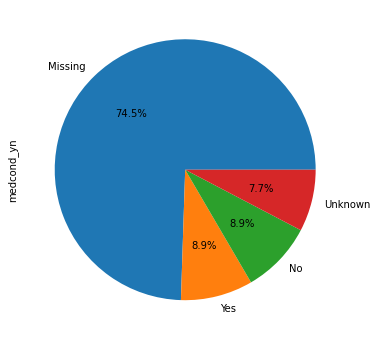

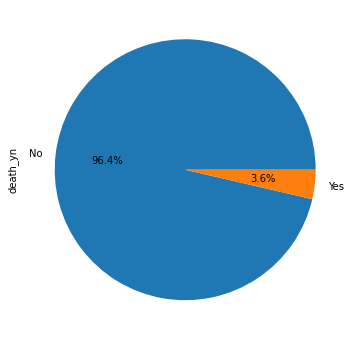

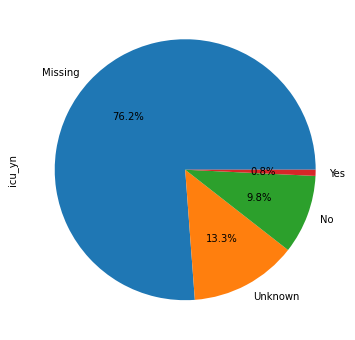

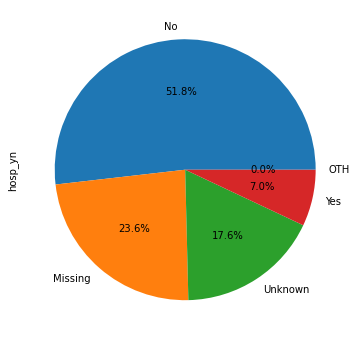

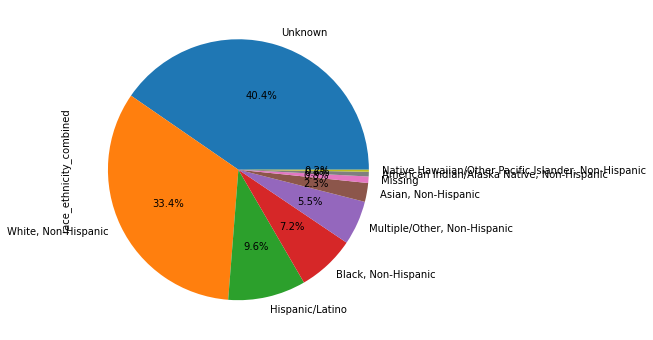

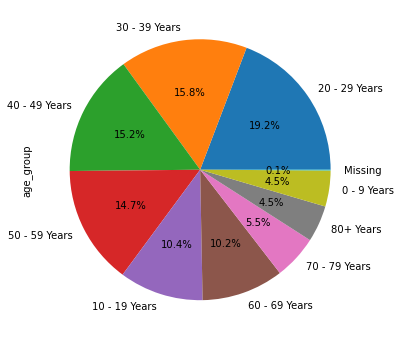

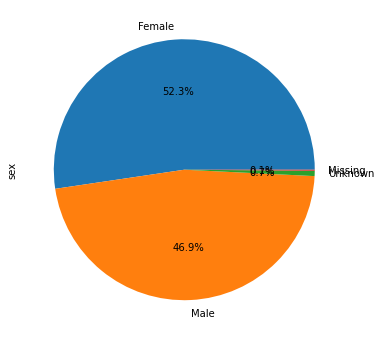

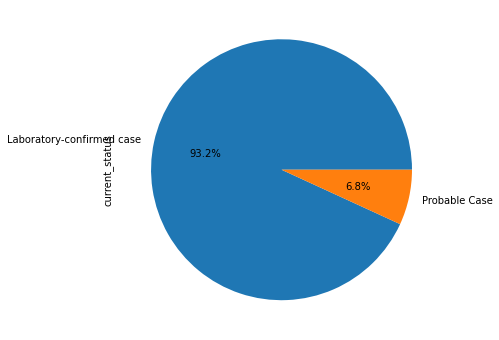

In [17]:
# pie charts of the duplicate categorical columns
category_columns = df_1[df_1[df_1.duplicated()].iloc[:, ::-1].select_dtypes(['category']).columns]

for column in category_columns:
    fig = plt.figure(figsize=(10,6))
    df_1[column].value_counts().plot.pie(autopct="%1.1f%%")
    plt.show()

In [18]:
# Look at the values taken by each categorical feature, including the NaN values.
for column in df_1[df_1.duplicated()]:
    print("\n" + column)
    print(df_1[df_1.duplicated()][column].value_counts(dropna=False))


cdc_case_earliest_dt
2020-12-29    22
2020-12-17    22
2020-12-28    19
2021-01-04    17
2020-12-30    15
              ..
2020-11-14     1
2020-08-13     1
2020-07-13     1
2020-06-12     1
2020-05-14     1
Name: cdc_case_earliest_dt, Length: 107, dtype: int64

cdc_report_dt
NaT           377
2021-01-22      5
2020-12-17      4
2020-11-19      3
2020-12-29      3
             ... 
2021-01-08      1
2021-01-04      1
2020-07-02      1
2021-01-01      1
2020-08-15      1
Name: cdc_report_dt, Length: 69, dtype: int64

pos_spec_dt
NaT           448
2020-05-15      2
2020-05-04      2
2020-12-31      1
2020-11-16      1
2020-04-30      1
2021-01-06      1
2020-11-22      1
2020-04-08      1
2021-01-12      1
2020-12-29      1
2020-07-02      1
2020-12-21      1
2020-10-06      1
2020-11-06      1
2020-09-22      1
2020-11-23      1
2020-12-24      1
2020-11-09      1
2021-01-10      1
2020-12-27      1
2020-12-30      1
2020-05-13      1
2020-12-02      1
2021-01-08      1
2020-12-28     

### Result - duplicate rows exist, no duplicate columns

##### Columns
- There are no duplicate columns. We will also check the descriptive stats to make sure we did not miss any duplicated columns.

##### Rows
- There is no primary key in the dataset (id or case number attribute) to check if a positive case is included twice. Therefore I compare against all columns attributes. This acts like a primary key. 
    - This initially returned 477 duplicate rows. 
    - To also include the rows that were matched I include "keep=False" parameter which returned 852 rows. 
    - By displaying these rows in a dataframe and also looking at the proportion counts I can see that certain columns do not contain missing values for these duplicate rows e.g.:
        1. age_group
        2. sex 
        3. cdc_case_earliest_dt 
    - Other features~ such as the below contain mostly missing values in these columns:
        1. hosp_yn, 
        2. icu_yn 
        3. medcond_yn
        4. cdc_report_dt
        5. pos_spec_dt
- The 'duplicates' found here represent data where there are not enough unique values for certain columns ie medcond_yn or icu_yn to distinguish between them. They still will add value to the analysis on gender and age_group and therefore should not be dropped.
- My approach here will be to leave the duplicates in the dataset. As there are values for age_group and sex as well as the earliest case date, this will serve useful for aggregate analysis of these features. 
- When analysing the other features it will be more useful to look at the statistics of these features with the Missing/Unknown values and taking note of both the proportion of the total which have a certain feature and the proportion of those that are not Missing/Unknown
- Pandas sees these rows as duplicates because they are a missing a number of key characteristics such as medcond_yn or icu_yn along with a number of the date columns. For this reason, these rows are not actually duplicate data but rather rows which have the same value as another row.

### Check for Null Values

In [19]:
df_1.isnull().sum()

cdc_case_earliest_dt          0
cdc_report_dt              2275
pos_spec_dt                7100
onset_dt                   4923
current_status                0
sex                           0
age_group                     0
race_ethnicity_combined       0
hosp_yn                       0
icu_yn                        0
death_yn                      0
medcond_yn                    0
dtype: int64

In [20]:
df_1.eq("Missing").sum() + df_1.eq("Unknown").sum()

cdc_case_earliest_dt          0
cdc_report_dt                 0
pos_spec_dt                   0
onset_dt                      0
current_status                0
sex                          78
age_group                     9
race_ethnicity_combined    4119
hosp_yn                    4119
icu_yn                     8945
death_yn                      0
medcond_yn                 8215
dtype: int64

In [21]:
print("Missing\n",df_1[["hosp_yn", "race_ethnicity_combined"]].eq("Missing").sum())
print("Unknown\n",df_1[["hosp_yn", "race_ethnicity_combined"]].eq("Unknown").sum())

Missing
 hosp_yn                    2358
race_ethnicity_combined      80
dtype: int64
Unknown
 hosp_yn                    1761
race_ethnicity_combined    4039
dtype: int64


#### Categorical
- No null values found for any of the categorical variables or for the earliest case data, although this does not completelty represent the features as some of the categorical features do contain values of Missing/Unknown which are not interpreted as missing. The columns containing these values are:
    - icu_yn: This feature has the largest amount of Unknown/Missing values at 89%. Although this will make it more difficult to analyse this feature it should be kept for the analysis as a patient staying in the ICU would indicate that their condition has become serious and would therefore be a strong predictor of death. The domain expert should also be consulted on the reason for the large amount of Missing values here as it may be a case that Missing could be interpreted as having not staying in the ICU. For our analysis we will interpret Missing/Unknown as a seperate feature though.
    - medcond_yn: This feature also has a very high amount of Unknown/Missing values at 82%. Although, in the same was as icu_yn above, previous medical conditions would be a strong predictor of serious cases of Covid-19 and therefore should not be dropped as value could be gleaned from the feature.
    - hosp_yn & race_yn both have the exact same amount of Missing/Unknown values, which seems to simply be a coincidence as when we look at the sum of missing values and the sum of unknown values independently the values differ. Both of these features contain over 50% of known values and for that reason they should not be dropped.
    - sex & age_group both only have less than 1% missing values and we will therefore not be dropping these features.

#### Datetime
- Null values were found for each of the date columns other than cdc_case_earliest_dt.
    - cdc_report_dt (Date of initial case report to CDC): The data dictionary suggests this column is deprecated, although from furhter analysis below, we can see that the information presented in this column differs from the column which is meant to replace it. __I will be dropping this column also because it has been specified as deprecated in the data dictionary.__
    - pos_spec_dt (Date of first positive specimen collection): This feature is 71% null but from further analysis below we can see that the information provided by this feature may be useful to see the time difference between when the positive specimen was collected and when the case was reported although because our target outcome is figuring out factors which influence the target condition (death), __I do not believe this column will be useful for this specific task and therefore it will be dropped.__
    - onset_dt (If symptomatic, onset date): This feature is 49% null values although the data it contains will be useful for analysis and I will therefore not be dropping this column.

## Check for Irregular cardinalities & permitted values/Logical Integrity Testing

#### 1. Check the time difference between the date reported to the CDC and the earlier reported test:

In [22]:
# Check cdc_report_dt vs cdc_case_earliest_dt
time_difference_1 = (df_1.cdc_report_dt-df_1.cdc_case_earliest_dt).astype('timedelta64[D]')

max_time_difference = max(time_difference_1)
min_time_difference = min(time_difference_1)
print("Maximum days between case report and symptom onset:", max_time_difference)
print("Minimum days between case report and symptom onset:", min_time_difference)

count_zero = time_difference_1[(time_difference_1 == 0)].count()
count_NaN = time_difference_1.shape[0] - time_difference_1.dropna().shape[0]
count_greater_than_zero = time_difference_1[(time_difference_1 > 0)].count()
count_less_than_zero = time_difference_1[(time_difference_1 < 0)].count()
print()
print("Zero days between case report and earliest:", count_zero)
print("Greater than 0 days between case report and earliest:", count_greater_than_zero)
print("Less than 0 days between case report and earliest:", count_less_than_zero)
print("Null values case report and earliest:", count_NaN)

print()
print("Validitity check number of rows is 10,000:", count_zero+count_greater_than_zero+count_NaN+count_less_than_zero)
time_difference_1

Maximum days between case report and symptom onset: 356.0
Minimum days between case report and symptom onset: -40.0

Zero days between case report and earliest: 3021
Greater than 0 days between case report and earliest: 4661
Less than 0 days between case report and earliest: 43
Null values case report and earliest: 2275

Validitity check number of rows is 10,000: 10000


0       22.0
1        NaN
2        0.0
3        0.0
4        0.0
        ... 
9995    81.0
9996     5.0
9997     6.0
9998     0.0
9999     7.0
Length: 10000, dtype: float64

In [23]:
df_1[(time_difference_1 < 0)].head()

cdc_case_earliest_dt cdc_report_dt pos_spec_dt   onset_dt  \
736            2020-07-28    2020-07-24  2020-07-24 2020-07-28   
1053           2020-10-21    2020-10-20  2020-10-20 2020-10-21   
1188           2021-01-09    2021-01-05  2021-01-05 2021-01-09   
1276           2020-11-09    2020-11-02  2020-11-02 2020-11-09   
1410           2020-07-19    2020-07-17  2020-07-17 2020-07-19   

                 current_status     sex      age_group  \
736   Laboratory-confirmed case  Female  20 - 29 Years   
1053  Laboratory-confirmed case    Male  40 - 49 Years   
1188  Laboratory-confirmed case  Female  60 - 69 Years   
1276  Laboratory-confirmed case  Female  70 - 79 Years   
1410  Laboratory-confirmed case  Female  40 - 49 Years   

     race_ethnicity_combined  hosp_yn   icu_yn death_yn medcond_yn  
736                  Unknown       No       No       No         No  
1053     White, Non-Hispanic       No  Unknown       No         No  
1188     Black, Non-Hispanic  Unknown  Unknown       No    Unknown  
1276     Black, Non-Hispanic       No  Unknown       No         No  
1410     Black, Non-Hispanic       No  Missing       No        Yes

__Result__: As 43 rows have negative values for this time difference they fail this logical integrity test. This is because the cdc_case_earliest_dt is supposed to be "The earlier of the Clinical Date (date related to the illness or specimen collection) or the Date Received by CDC", which they do not fall under here. In this case, asking the domain expert would be a good choice as there may be some information we do not know here.

#### 2. Check the time difference between the pos_spec_dt and cdc_case_earliest_dt:

In [24]:
# Check cdc_report_dt vs cdc_case_earliest_dt before dropping
time_difference_2 = (df_1.pos_spec_dt-df_1.cdc_case_earliest_dt).astype('timedelta64[D]')

max_time_difference = max(time_difference_2[(time_difference_2 > 0)])
min_time_difference = min(time_difference_2[(time_difference_2 < 0)])
print("Maximum days between case report and symptom onset:", max_time_difference)
print("Minimum days between case report and symptom onset:", min_time_difference)

count_zero = time_difference_2[(time_difference_2 == 0)].count()
count_NaN = time_difference_2.shape[0] - time_difference_2.dropna().shape[0]
count_greater_than_zero = time_difference_2[(time_difference_2 > 0)].count()
count_less_than_zero = time_difference_2[(time_difference_2 < 0)].count()
print()
print("Zero days between case report and onset:", count_zero)
print("Greater than 0 days between case report and onset:", count_greater_than_zero)
print("Less than 0 days between case report and earliest:", count_less_than_zero)
print("Null values case report and onset:", count_NaN)

print()
print("Validitity check number of rows is 10,000:", count_zero+count_greater_than_zero+count_NaN+count_less_than_zero)

Maximum days between case report and symptom onset: 235.0
Minimum days between case report and symptom onset: -40.0

Zero days between case report and onset: 1561
Greater than 0 days between case report and onset: 1243
Less than 0 days between case report and earliest: 96
Null values case report and onset: 7100

Validitity check number of rows is 10,000: 10000


In [25]:
df_1[(time_difference_2 < 0)]

cdc_case_earliest_dt cdc_report_dt pos_spec_dt   onset_dt  \
76             2021-01-12    2021-01-13  2021-01-11 2021-01-12   
252            2020-08-17    2021-01-25  2020-07-14 2020-08-17   
736            2020-07-28    2020-07-24  2020-07-24 2020-07-28   
770            2020-12-13    2020-12-16  2020-12-12 2020-12-13   
771            2020-12-12    2020-12-15  2020-12-11 2020-12-12   
...                   ...           ...         ...        ...   
9208           2020-12-03    2020-11-24  2020-11-24 2020-12-03   
9210           2021-01-07    2021-01-05  2021-01-05 2021-01-07   
9388           2021-01-12    2021-01-09  2021-01-09 2021-01-12   
9550           2020-11-15    2020-11-25  2020-11-13 2020-11-15   
9626           2020-04-23    2020-05-14  2020-04-22 2020-04-23   

                 current_status     sex      age_group  \
76    Laboratory-confirmed case  Female  30 - 39 Years   
252   Laboratory-confirmed case    Male  70 - 79 Years   
736   Laboratory-confirmed case  Female  20 - 29 Years   
770   Laboratory-confirmed case  Female  50 - 59 Years   
771   Laboratory-confirmed case    Male  30 - 39 Years   
...                         ...     ...            ...   
9208  Laboratory-confirmed case    Male    0 - 9 Years   
9210  Laboratory-confirmed case    Male  20 - 29 Years   
9388  Laboratory-confirmed case    Male  20 - 29 Years   
9550  Laboratory-confirmed case  Female  40 - 49 Years   
9626  Laboratory-confirmed case  Female  60 - 69 Years   

     race_ethnicity_combined  hosp_yn   icu_yn death_yn medcond_yn  
76           Hispanic/Latino       No  Missing       No        Yes  
252                  Unknown      Yes  Missing      Yes    Missing  
736                  Unknown       No       No       No         No  
770                  Unknown  Missing  Missing       No        Yes  
771      White, Non-Hispanic       No       No       No        Yes  
...                      ...      ...      ...      ...        ...  
9208         Hispanic/Latino       No  Missing       No        Yes  
9210     White, Non-Hispanic       No  Missing       No    Missing  
9388                 Unknown       No  Unknown       No    Unknown  
9550     White, Non-Hispanic       No       No       No         No  
9626     White, Non-Hispanic       No       No       No         No  

[96 rows x 12 columns]

__Result__: Minimum days between positive specimen collection and earlier of clinical date is less than 0 and therefore it fails this integrity check. This would need further investigation and consulation with the domain expert to see if this is an issue with the actual data.

#### 3. Check the time difference between the onset_dt and cdc_case_earliest_dt:

In [26]:
# Check for irregular cardinality & permitted values in categorical features. 
time_difference3 = (df_1.onset_dt-df_1.cdc_case_earliest_dt).astype('timedelta64[D]')

max_time_difference = max(time_difference3)
min_time_difference = min(time_difference3)
print("Maximum days between case report and symptom onset:", max_time_difference)
print("Minimum days between case report and symptom onset:", min_time_difference)

count_zero = time_difference3[(time_difference3 == 0)].count()
count_NaN = time_difference3.shape[0] - time_difference3.dropna().shape[0]
count_greater_than_zero = time_difference3[(time_difference3 > 0)].count()
print()
print("Zero days between case report and onset:", count_zero)
print("Greater than 0 days between case report and onset:", count_greater_than_zero)
print("Null values case report and onset:", count_NaN)

print()
print("Validitity check number of rows is 10,000:", count_zero+count_greater_than_zero+count_NaN)

Maximum days between case report and symptom onset: 235.0
Minimum days between case report and symptom onset: 0.0

Zero days between case report and onset: 4968
Greater than 0 days between case report and onset: 109
Null values case report and onset: 4923

Validitity check number of rows is 10,000: 10000


__Result__: From the above we can see that the 4923 values contain NA when we look at the time difference due to missing values in onset_dt. 
The minimum days between case report and symptom onset was 0 days as expected, this test is passed.

#### 5. Check rows to see if any are probable case (ie not laboratory confirmed) but do have positive specimen collection date

In [27]:
df_specdt_status_2 = df_1[['pos_spec_dt', 'current_status']]
df_specdt_status_2 = df_specdt_status_2.loc[df_1['current_status'] == "Probable Case"]

print(df_specdt_status_2.loc[df_1.pos_spec_dt.notnull()].count())
print(df_specdt_status_2.count())
df_specdt_status_2.head()

pos_spec_dt       242
current_status    242
dtype: int64
pos_spec_dt       242
current_status    685
dtype: int64


pos_spec_dt current_status
11  2020-06-04  Probable Case
29         NaT  Probable Case
40         NaT  Probable Case
49         NaT  Probable Case
75         NaT  Probable Case

__Result__: In total there are 685 values where current_status = Probable Case, but 242 of these values have a date of first positive specimen collection. These 242 values should therefore be Laboratory-confirmed case but they are not. This would need to be verified with the domain expert to see the cause of this.

#### 6. Check if there are cases which were in the ICU but have a no value for hospitalization status.

In [28]:
df_hos_icu = df_1[['hosp_yn', 'icu_yn']]
df_hos_icu = df_hos_icu.loc[df_1['hosp_yn'] == "No"]
df_hos_icu = df_hos_icu.loc[df_1['hosp_yn'] == "Yes"]

df_hos_icu.count()

hosp_yn    0
icu_yn     0
dtype: int64

__Result__: This passed the integrity test as there are no values which were in the ICU but have a no value for hosp_yn

#### 7. Check if there are cases which were in the ICU but have value other than yes for hospitalization.

In [29]:
df_hos_icu_2 = df_1[['hosp_yn', 'icu_yn']]
df_hos_icu_2 = df_hos_icu_2.loc[df_1['hosp_yn'] != "Yes"]
df_hos_icu_2 = df_hos_icu_2.loc[df_1['hosp_yn'] == "Yes"]

df_hos_icu_2.count()

hosp_yn    0
icu_yn     0
dtype: int64

__Result__: This passed the integrity test as there are no values which were in the ICU but have value other than yes for hosp_yn.


## Date Time Analysis

The earlier of the Clinical Date (date related to the illness or specimen collection) or the Date Received by CDC Earliest: 4th of January 2020, Latest: 16 of January 2021.<br/>
If symptomatic, onset date (MM/DD/YYYY): Earliest: 9th of January 2020, Latest: 24th of January 2021.<br/>

In [30]:
# descriptive statistics of the numerical data
df_1.describe(datetime_is_numeric=True)

cdc_case_earliest_dt                  cdc_report_dt  \
count                       10000                           7725   
mean   2020-10-03 15:35:42.720000  2020-10-15 07:41:43.922330112   
min           2020-01-04 00:00:00            2020-03-02 00:00:00   
25%           2020-07-23 18:00:00            2020-08-13 00:00:00   
50%           2020-11-07 00:00:00            2020-11-12 00:00:00   
75%           2020-12-15 00:00:00            2020-12-21 00:00:00   
max           2021-01-16 00:00:00            2021-01-29 00:00:00   

                         pos_spec_dt                       onset_dt  
count                           2900                           5077  
mean   2020-09-18 04:51:28.551724032  2020-09-19 13:21:32.653141760  
min              2020-03-08 00:00:00            2020-01-09 00:00:00  
25%              2020-07-07 00:00:00            2020-07-11 00:00:00  
50%              2020-10-19 00:00:00            2020-10-19 00:00:00  
75%              2020-12-02 00:00:00            2020-12-03 00:00:00  
max              2021-01-20 00:00:00            2021-01-24 00:00:00

### - Save descriptive statistics for all the datetime features to csv for data quality report

In [31]:
# save to csv file
df_1.describe(datetime_is_numeric=True).to_csv("data/datetimeFeatureDescription.csv")

In [32]:
# select datetime columns
datetime_columns = df_1.select_dtypes(include="datetime").columns

In [33]:
# check na rows in datetime data
df_1[datetime_columns].isna().sum()

cdc_case_earliest_dt       0
cdc_report_dt           2275
pos_spec_dt             7100
onset_dt                4923
dtype: int64

In [34]:
# get number of unique dates for each datetime column
# ie look at the cardinality
for c in df_1.select_dtypes(include="datetime"):
    print('{0:20}  {1}'.format(c, str(len(df_1[c].unique()))))

cdc_case_earliest_dt  327
cdc_report_dt         327
pos_spec_dt           313
onset_dt              329


#### Day of the Week

In [35]:
# adding a day of the week columns for each date column
df_1['cdc_case_earliest_day'] = df_1['cdc_case_earliest_dt'].dt.day_name()
df_1['onset_day'] = df_1['onset_dt'].dt.day_name()
day_of_week = {"cdc_case_earliest_day" : "The earlier of the Clinical Date or the Date Received by CDC", "onset_day" : "Symptom onset date, if symptomatic"}

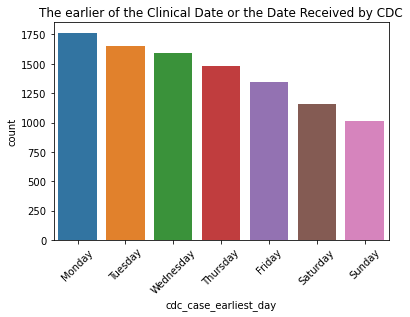

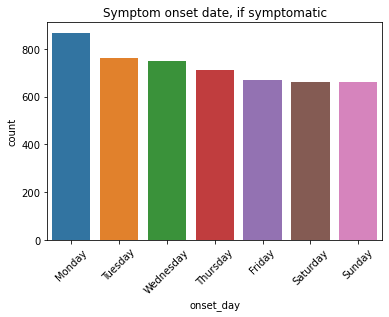

In [36]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# plot days of the week for each datetime column
for x, y in day_of_week.items():
    fig = sns.countplot(x = x, data = df_1, order = day_order)
    fig.set_title(y)
    fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
    plt.show()

#### Month

In [37]:
# adding a day of the week columns for each date column
df_1['cdc_case_earliest_month'] = df_1['cdc_case_earliest_dt'].dt.month_name()
df_1['onset_month'] = df_1['onset_dt'].dt.month_name()
months = {"cdc_case_earliest_month" : "The earlier of the Clinical Date or the Date Received by CDC", "onset_month" : "Symptom onset date, if symptomatic"}

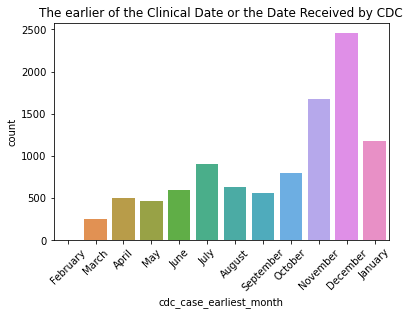

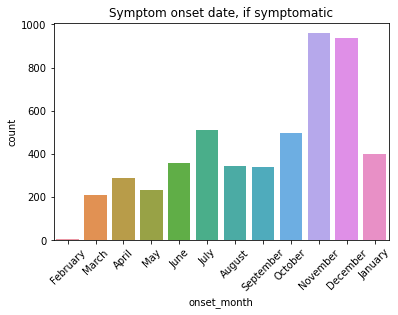

In [38]:
month_order = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January']
# plot days of the week for each datetime column
for x, y in months.items():
    fig = sns.countplot(x = x, data = df_1, order = month_order)
    fig.set_title(y)
    plt.xticks(rotation=45)
    plt.show()

In [39]:
# get counts of each date by frequency per date
cnt_onset = df_1.groupby('onset_dt').size().rename('Onset Case Count')
cnt_early = df_1.groupby('cdc_case_earliest_dt').size().rename('Earliest Report Count')
month_counts = {"Clinical Date or Date Received by CDC":cnt_early, "Symptom onset date, if symptomatic":cnt_onset}

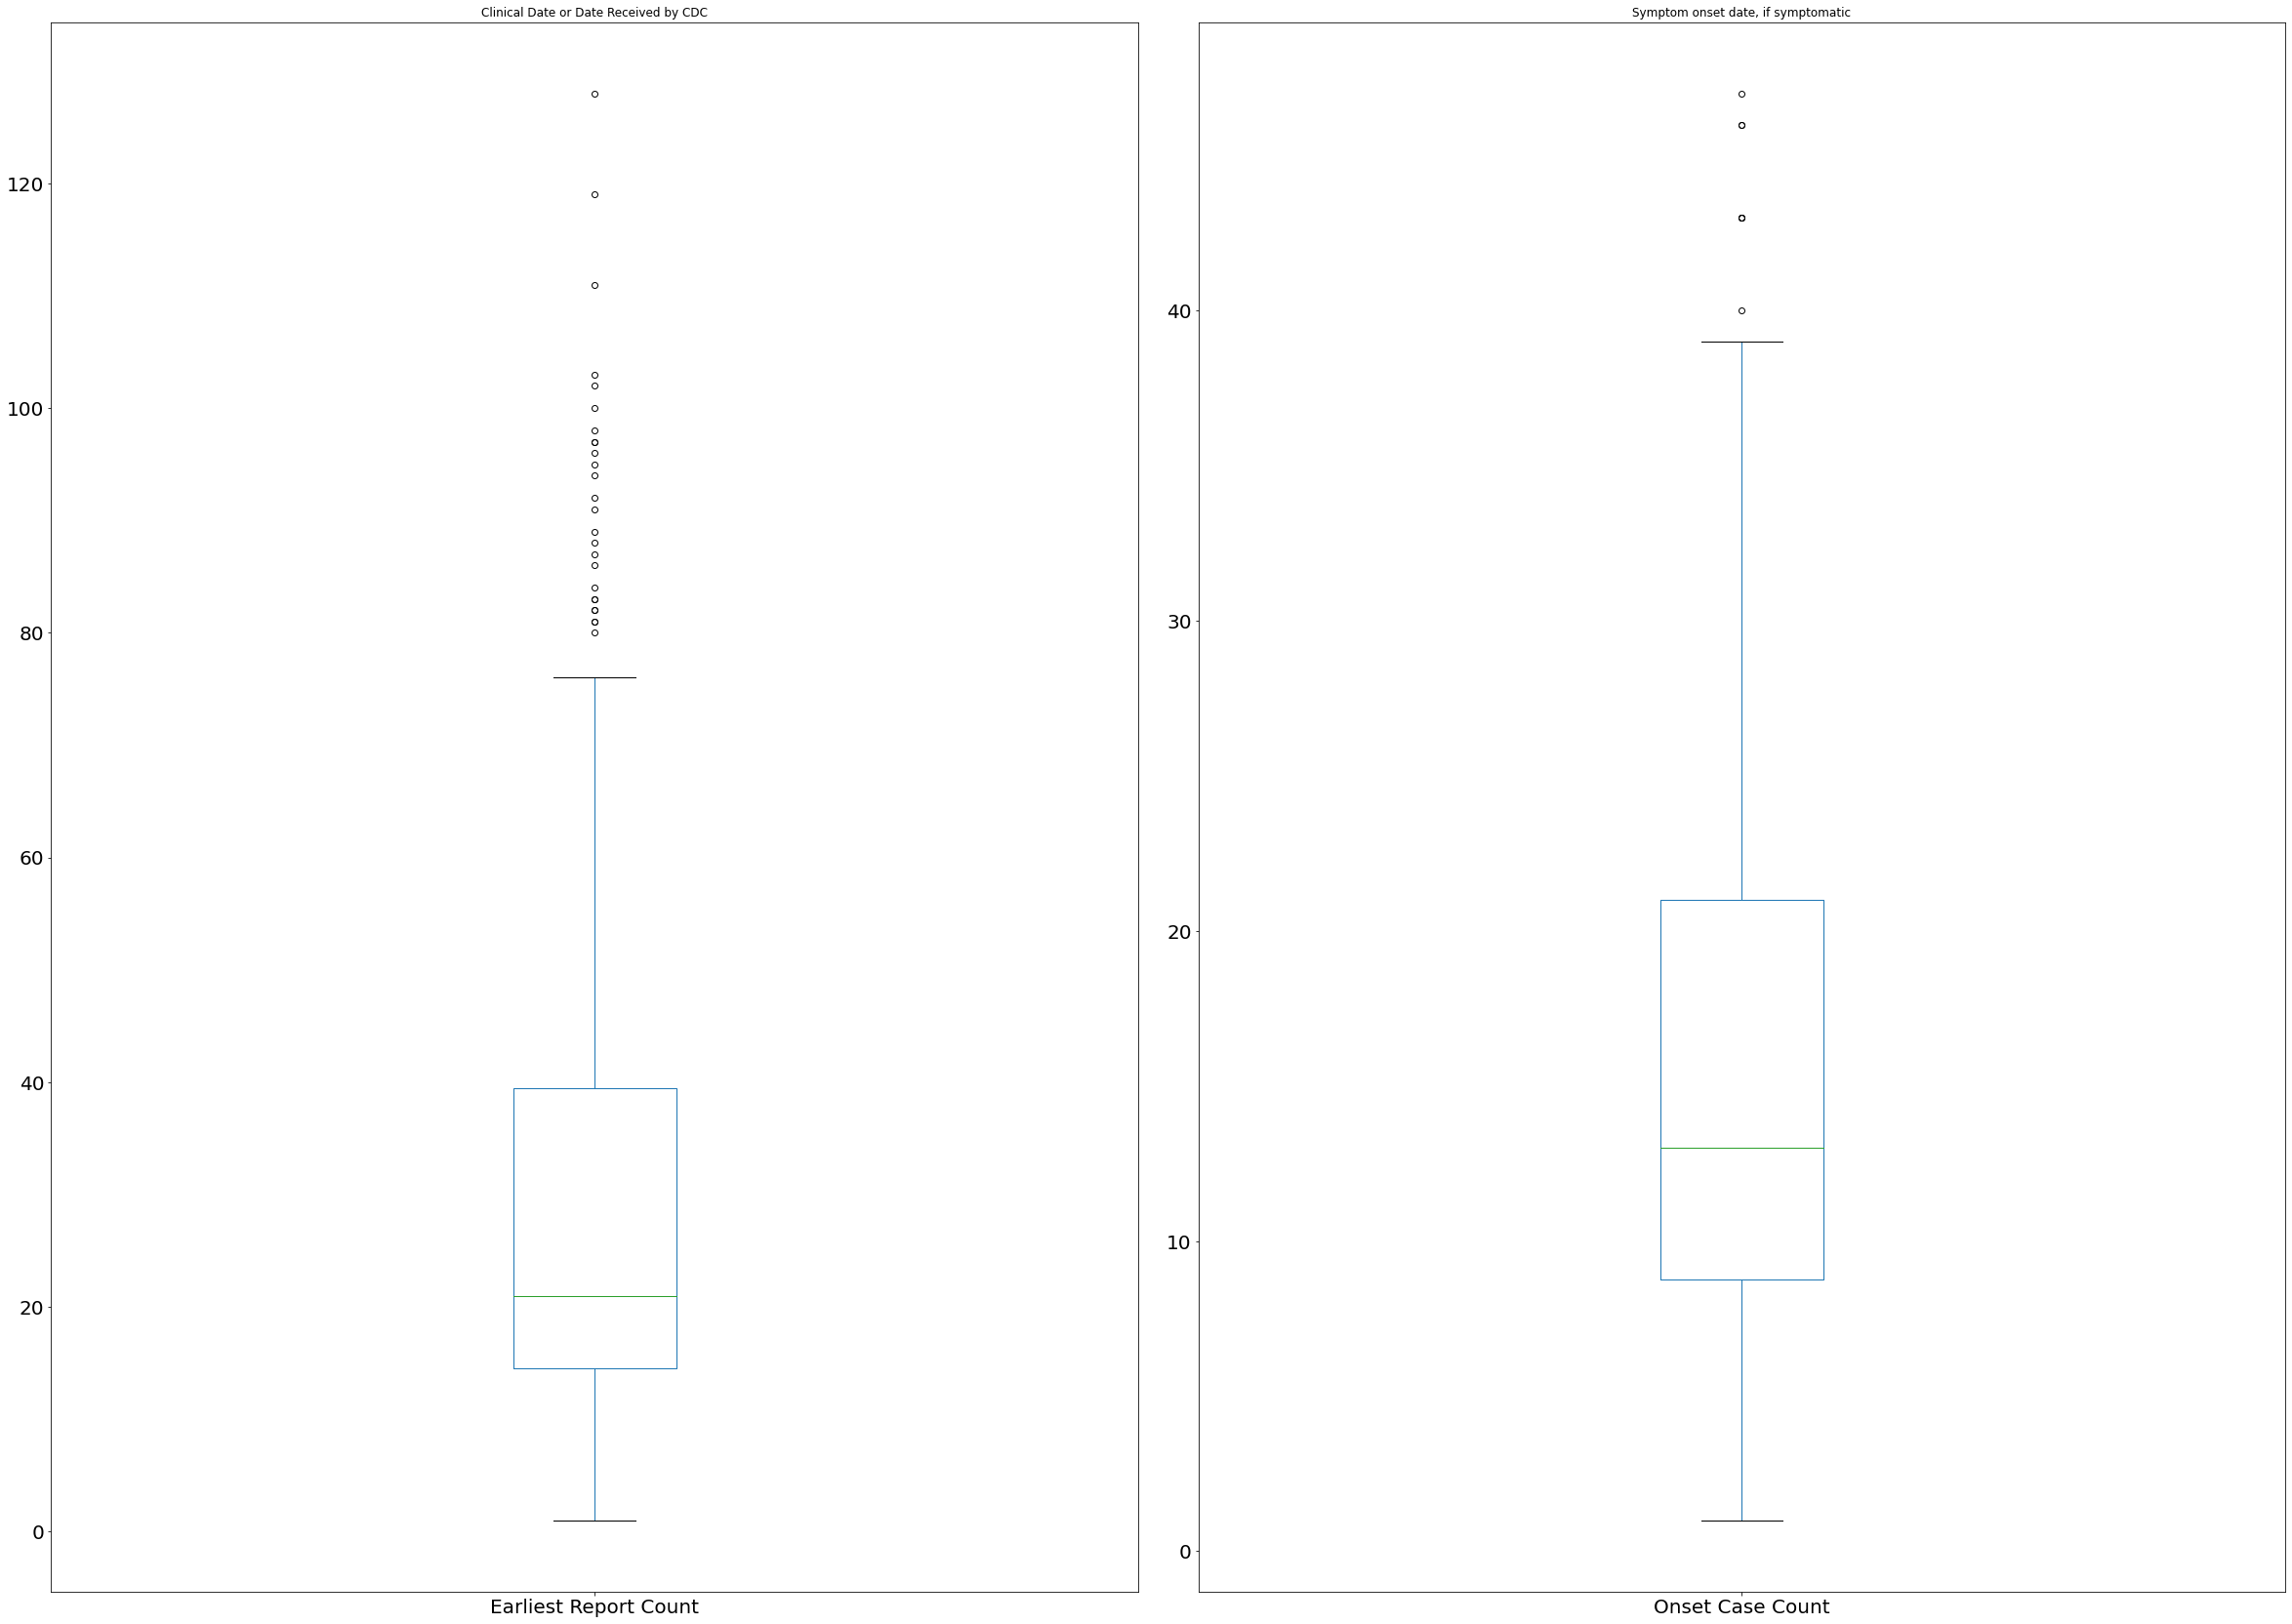

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(32.5,23), constrained_layout=True)
count_ax = 0
for title, count in month_counts.items():
    count.plot(kind="box", title=title ,ax=axes[count_ax], fontsize=20)
    #plt.show()
    count_ax += 1
    
with PdfPages("charts/category_columns_date_boxplots.pdf") as pp:
    pp.savefig()

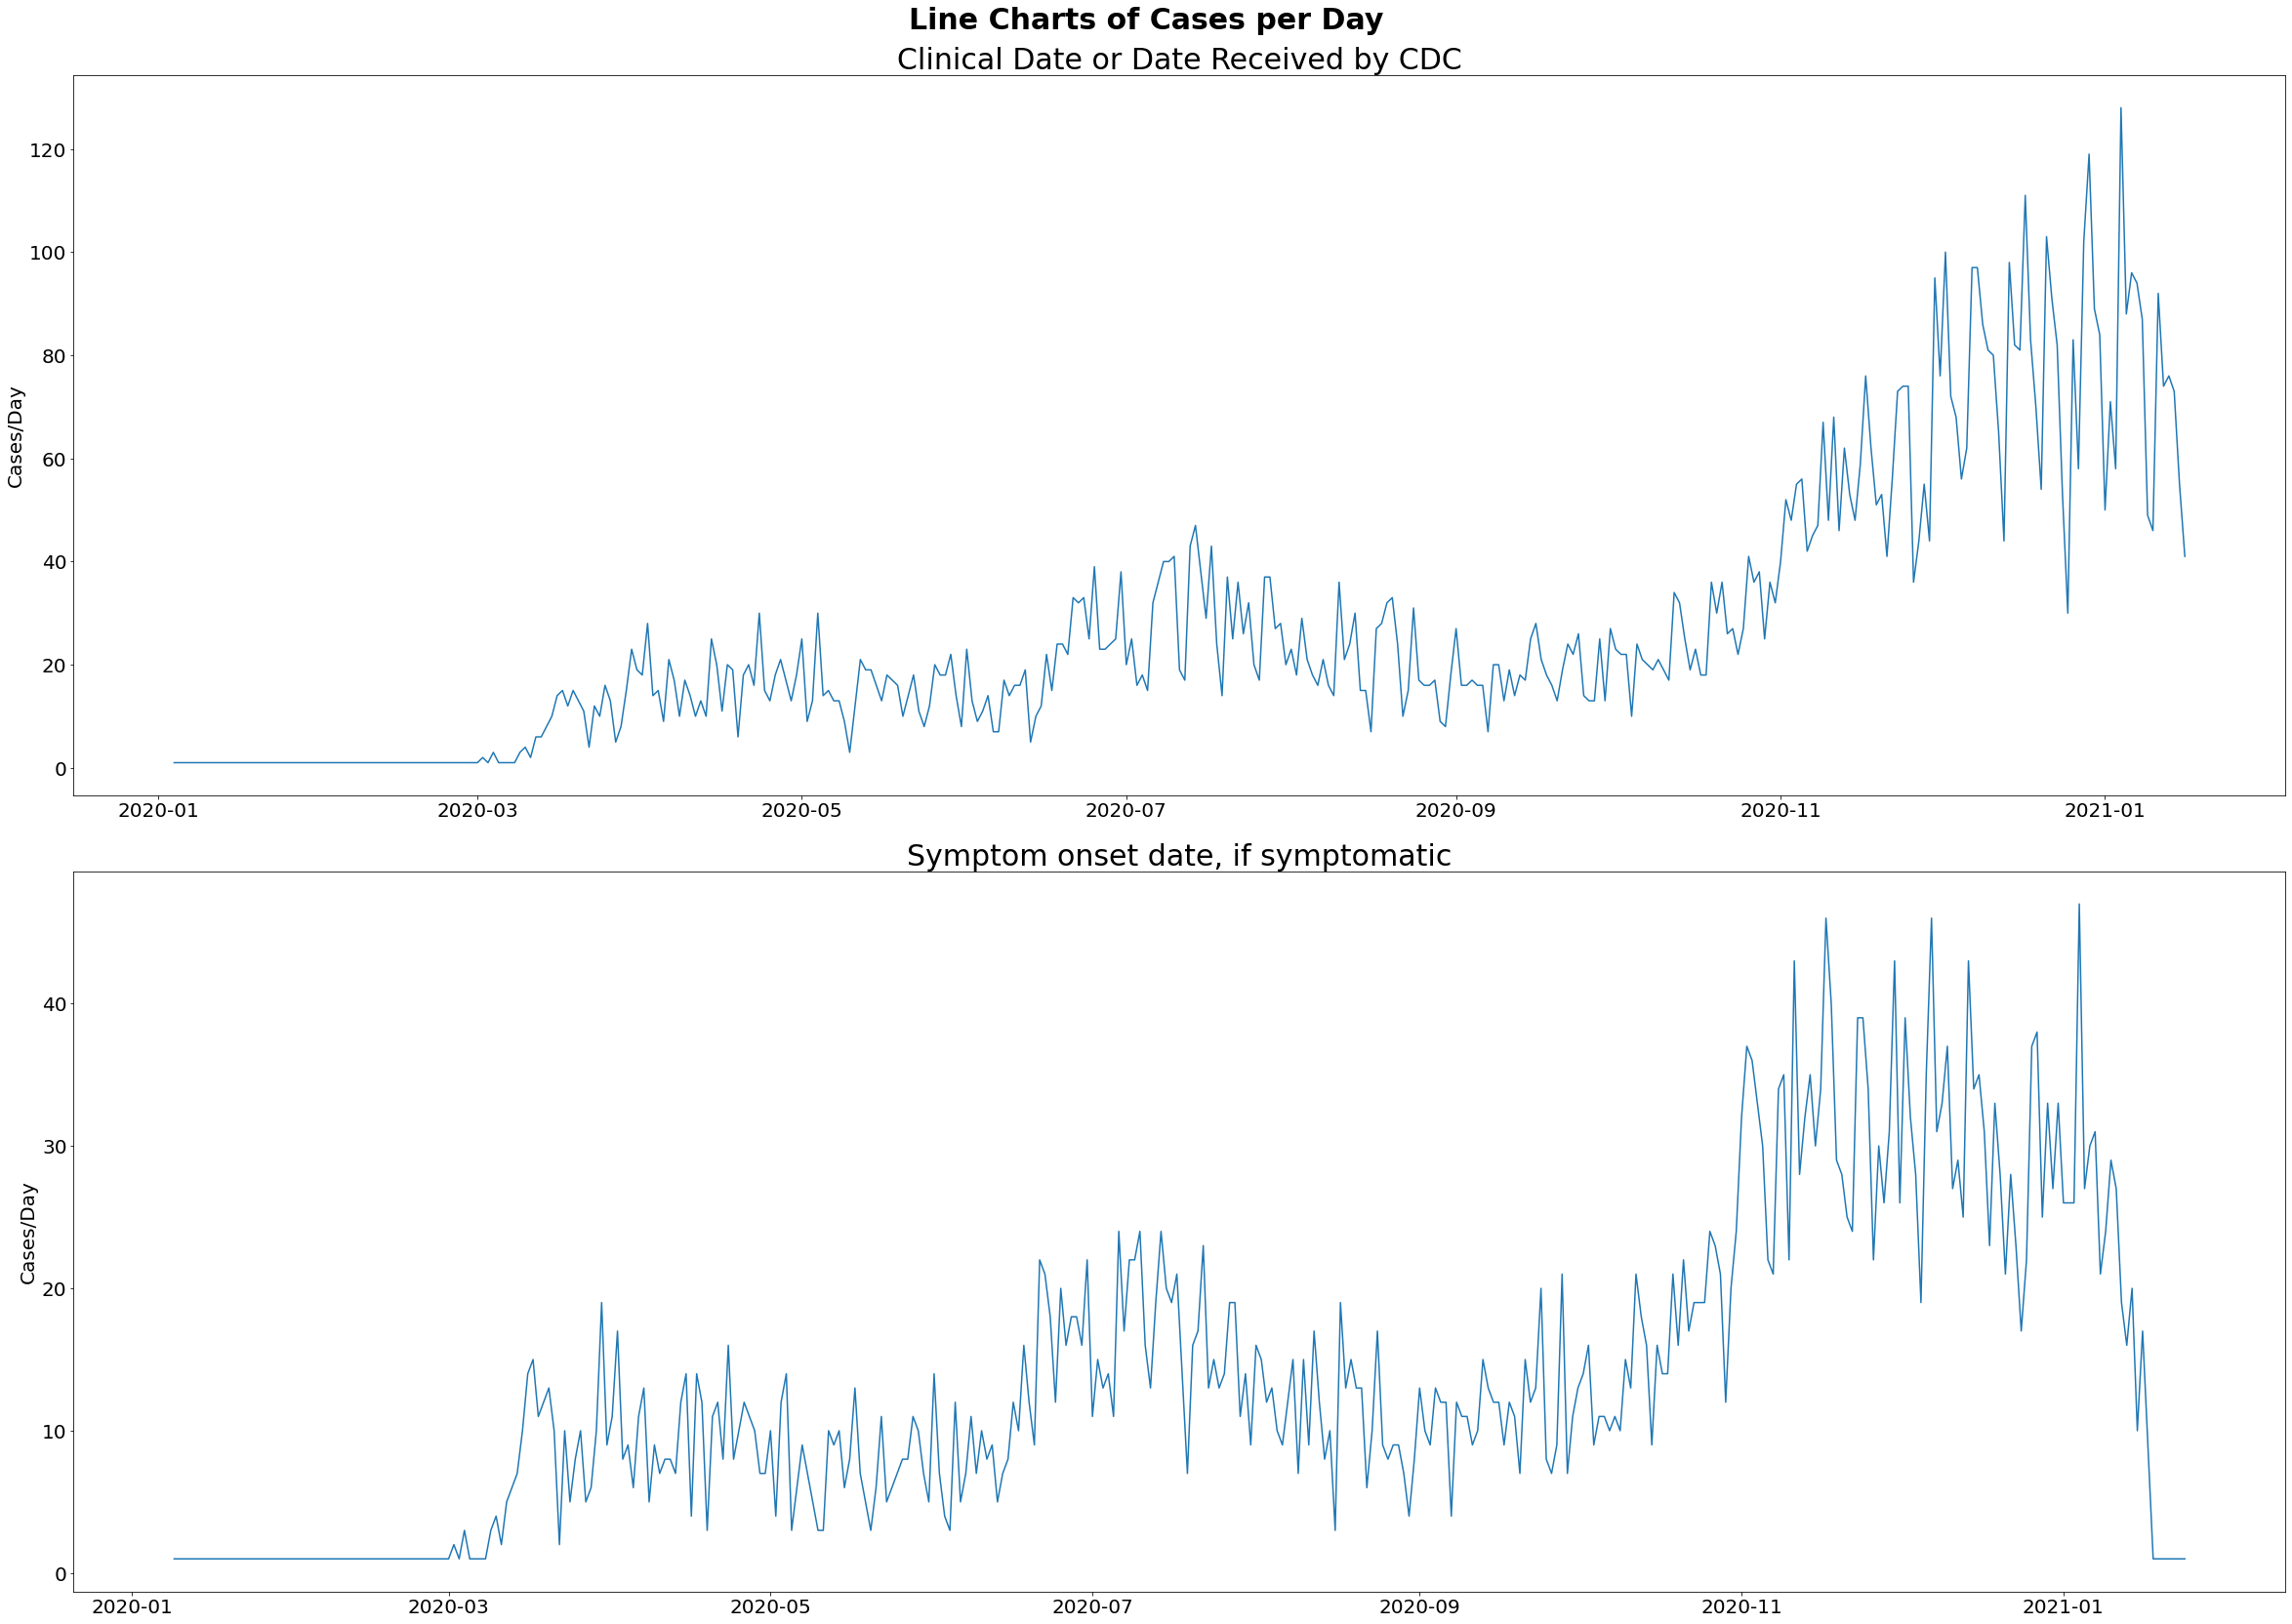

In [41]:
# line charts of date features
fig, ax = plt.subplots(2, 1, figsize=(32.5,23), constrained_layout=True)
col = 0
fig.suptitle('Line Charts of Cases per Day', fontsize=30, fontweight='bold')

for date in month_counts:
    cs=cm.Pastel2(np.arange(len(df_1[column].unique()))/len(df_1[column].unique()))
    ax[col].set_ylabel("Cases/Day", fontsize=20)
    ax[col].plot(month_counts[date])
    ax[col].set_title(date, fontsize= 30)
    ax[col].tick_params(axis='both', which='major', labelsize=20)
    col+=1
    
with PdfPages("charts/category_columns_date_line.pdf") as pp:
    pp.savefig()
        
plt.show()

In [42]:
# get counts of each date by frequency per date
cnt_pos = df_1.groupby('pos_spec_dt').size().rename('Positive Specimen Count')
cnt_report = df_1.groupby('cdc_report_dt').size().rename('Report Count')
month_counts_2 = {"Positive Specimen Count":cnt_pos, "Report Count":cnt_report}

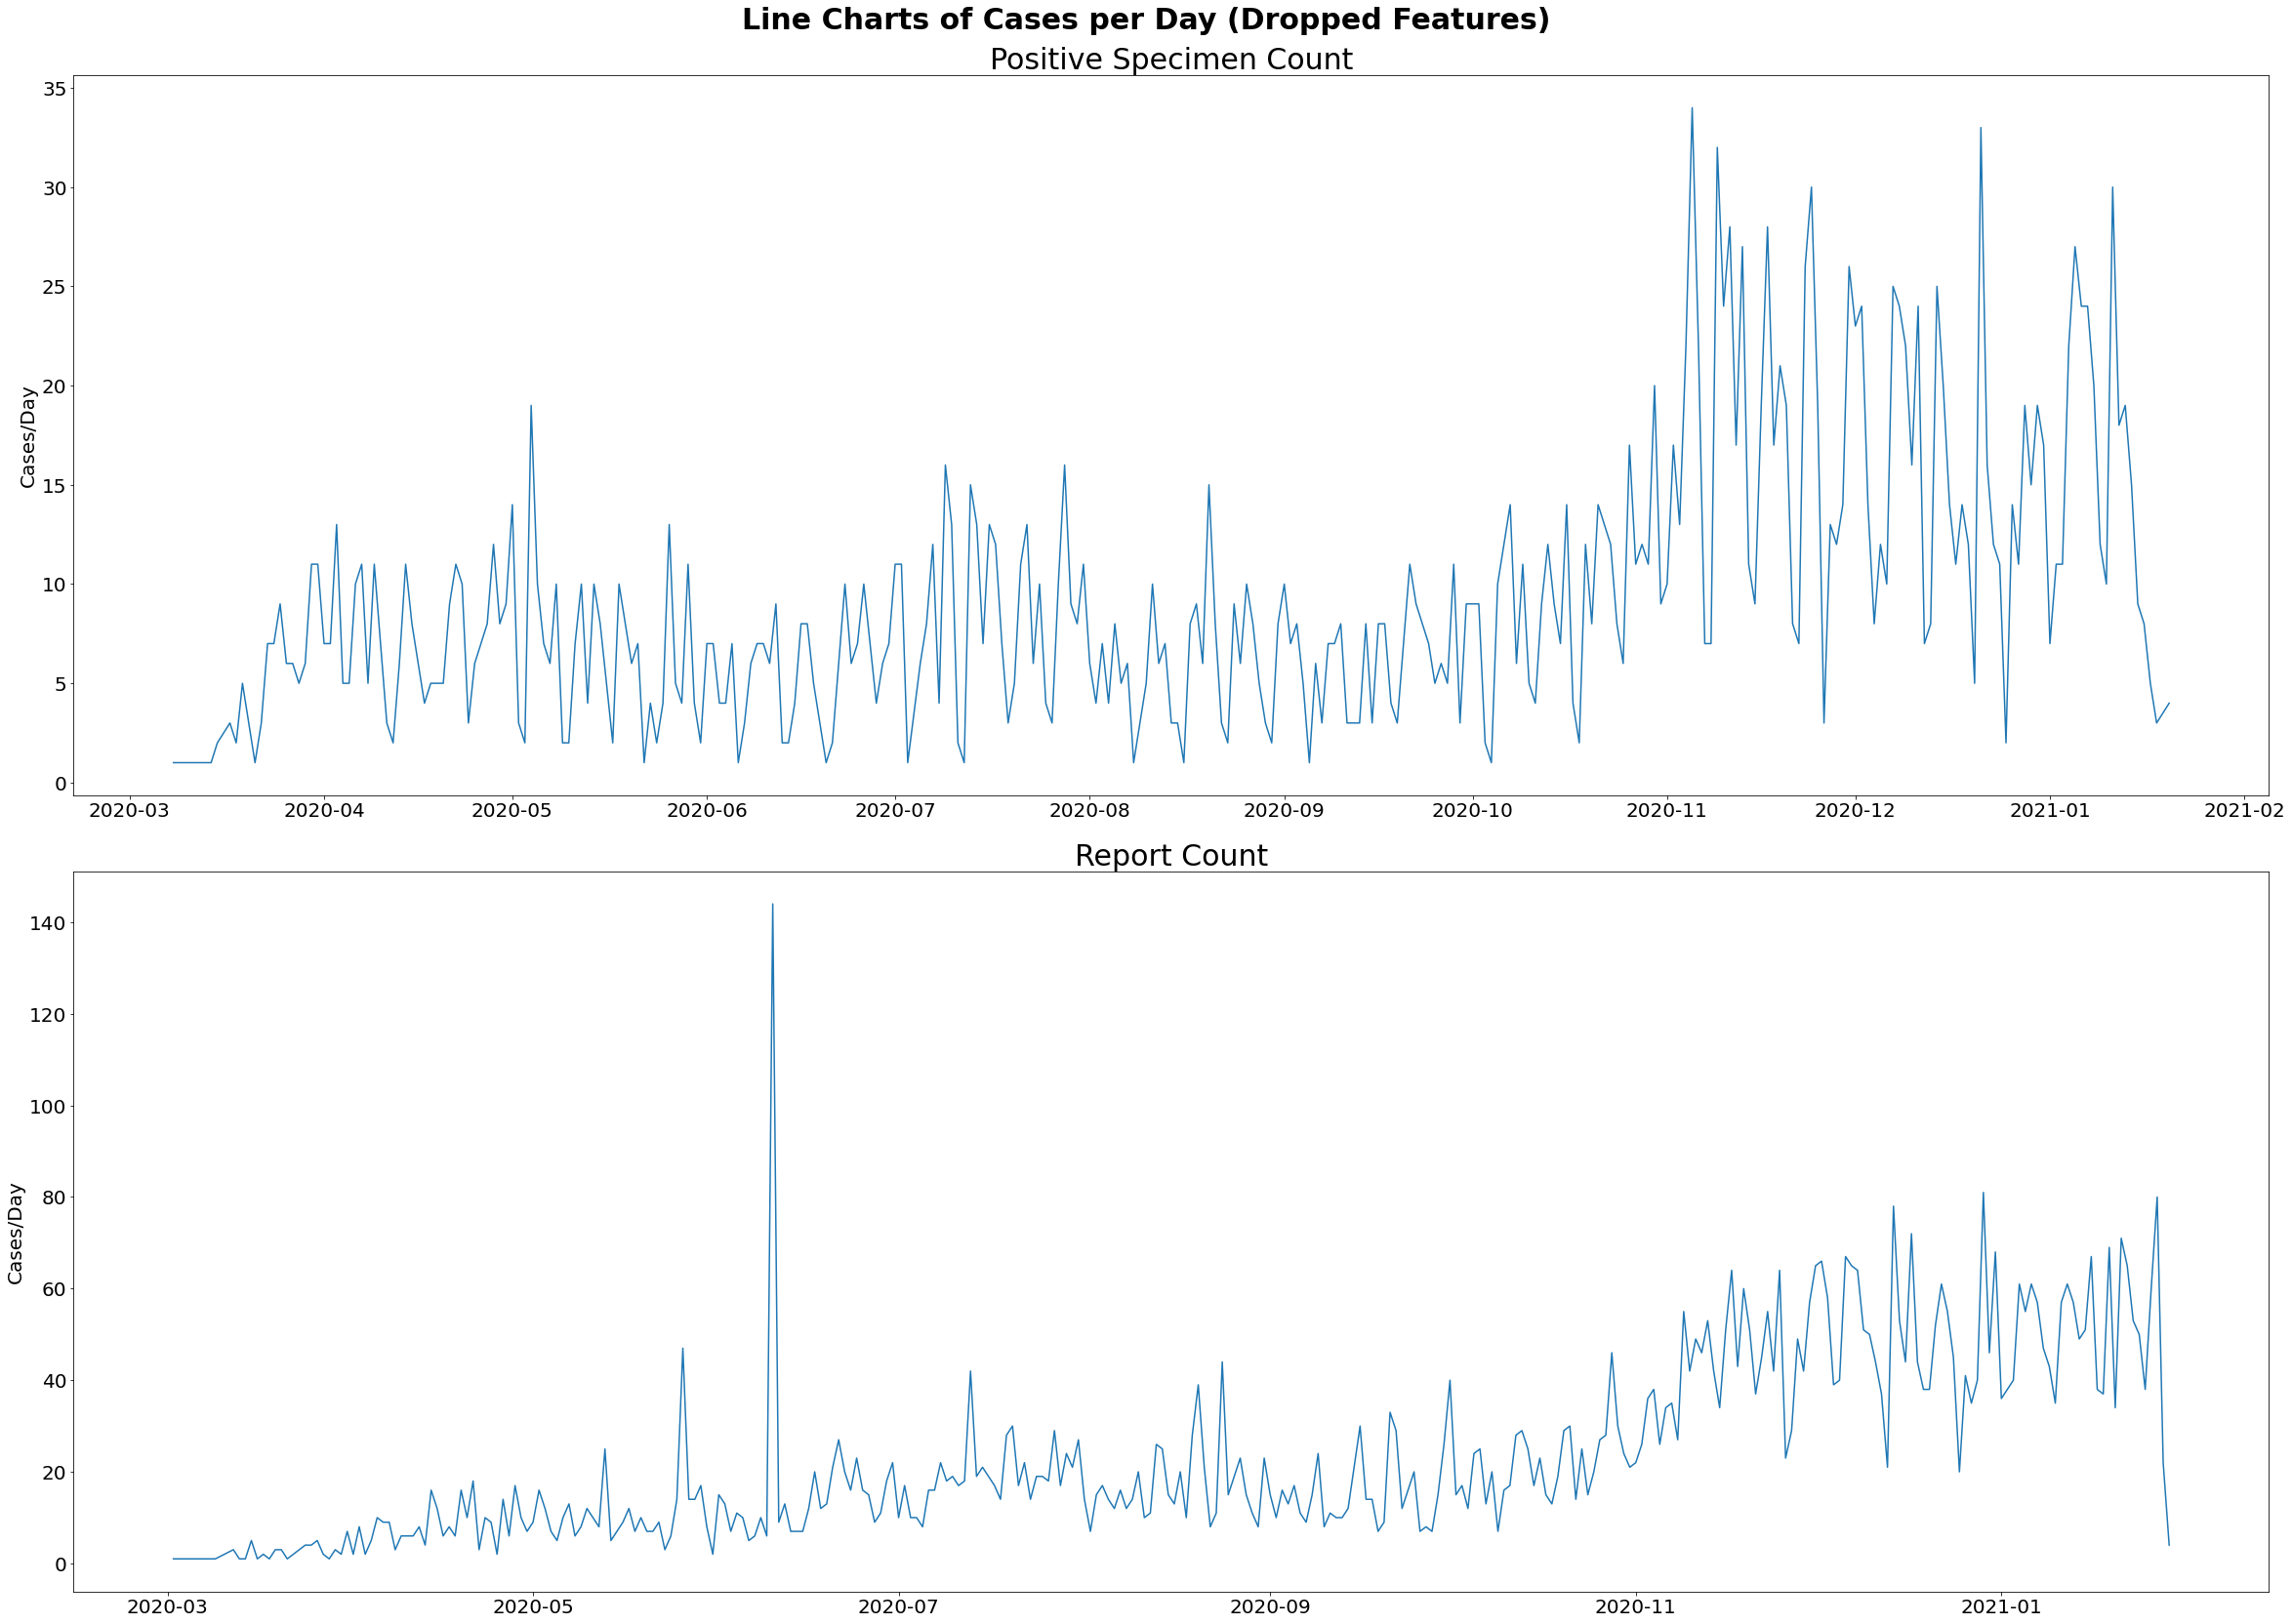

In [43]:
# line charts of date features
fig, ax = plt.subplots(2, 1, figsize=(32.5,23), constrained_layout=True)
col = 0
fig.suptitle('Line Charts of Cases per Day (Dropped Features)', fontsize=30, fontweight='bold')
col = 0
for date in month_counts_2:
    cs=cm.Pastel2(np.arange(100))
    ax[col].set_ylabel("Cases/Day", fontsize=20)
    ax[col].plot(month_counts_2[date])
    ax[col].set_title(date, fontsize= 30)
    ax[col].tick_params(axis='both', which='major', labelsize=20)
    col+=1
    
with PdfPages("charts/category_columns_date_line_dropped.pdf") as pp:
    pp.savefig()
        
plt.show()

---
<a id="Examine-Cat"></a>
## Examine the Categorical Features

In [44]:
#Look at the categorical features only
category_columns = df_1.select_dtypes(['category']).columns
df_1[category_columns].head()

current_status     sex      age_group  \
0  Laboratory-confirmed case  Female  30 - 39 Years   
1  Laboratory-confirmed case    Male  50 - 59 Years   
2  Laboratory-confirmed case    Male  70 - 79 Years   
3  Laboratory-confirmed case    Male  70 - 79 Years   
4  Laboratory-confirmed case    Male  10 - 19 Years   

        race_ethnicity_combined  hosp_yn   icu_yn death_yn medcond_yn  
0           Black, Non-Hispanic       No  Missing       No    Missing  
1  Multiple/Other, Non-Hispanic  Missing  Missing       No    Missing  
2           White, Non-Hispanic       No  Unknown       No        Yes  
3                       Unknown       No  Missing       No    Missing  
4           White, Non-Hispanic       No  Unknown       No    Unknown

In [45]:
# Descriptive stats for categorical features only.
df_1[category_columns].describe().T.to_csv("data/categoryFeatureDescription.csv")
df_1[category_columns].describe().T

count unique                        top  freq
current_status           10000      2  Laboratory-confirmed case  9315
sex                      10000      4                     Female  5234
age_group                10000     10              20 - 29 Years  1921
race_ethnicity_combined  10000      9                    Unknown  4039
hosp_yn                  10000      5                         No  5181
icu_yn                   10000      4                    Missing  7618
death_yn                 10000      2                         No  9637
medcond_yn               10000      4                    Missing  7448

In [46]:
# Values taken by each categorical feature, as a proportion and counts
for column in category_columns:
    print("\n" + color.BOLD + column + color.END)
    count = 0
    t = PrettyTable(['Value', 'Proportion', 'Count'])
    for value in df_1[column].unique():
        key = df_1[column].value_counts(normalize=True).keys().tolist()[count]
        proportion_val = df_1[column].value_counts(normalize=True).tolist()[count]
        count_val = df_1[column].value_counts().tolist()[count]
        t.add_row([key, proportion_val, count_val])
        count += 1
    print(t)


current_status
+---------------------------+------------+-------+
|           Value           | Proportion | Count |
+---------------------------+------------+-------+
| Laboratory-confirmed case |   0.9315   |  9315 |
|       Probable Case       |   0.0685   |  685  |
+---------------------------+------------+-------+

sex
+---------+------------+-------+
|  Value  | Proportion | Count |
+---------+------------+-------+
|  Female |   0.5234   |  5234 |
|   Male  |   0.4688   |  4688 |
| Unknown |   0.0065   |   65  |
| Missing |   0.0013   |   13  |
+---------+------------+-------+

age_group
+---------------+------------+-------+
|     Value     | Proportion | Count |
+---------------+------------+-------+
| 20 - 29 Years |   0.1921   |  1921 |
| 30 - 39 Years |   0.1579   |  1579 |
| 40 - 49 Years |   0.1516   |  1516 |
| 50 - 59 Years |   0.1471   |  1471 |
| 10 - 19 Years |   0.1043   |  1043 |
| 60 - 69 Years |   0.1016   |  1016 |
| 70 - 79 Years |   0.0547   |  547  |
|   80+ 

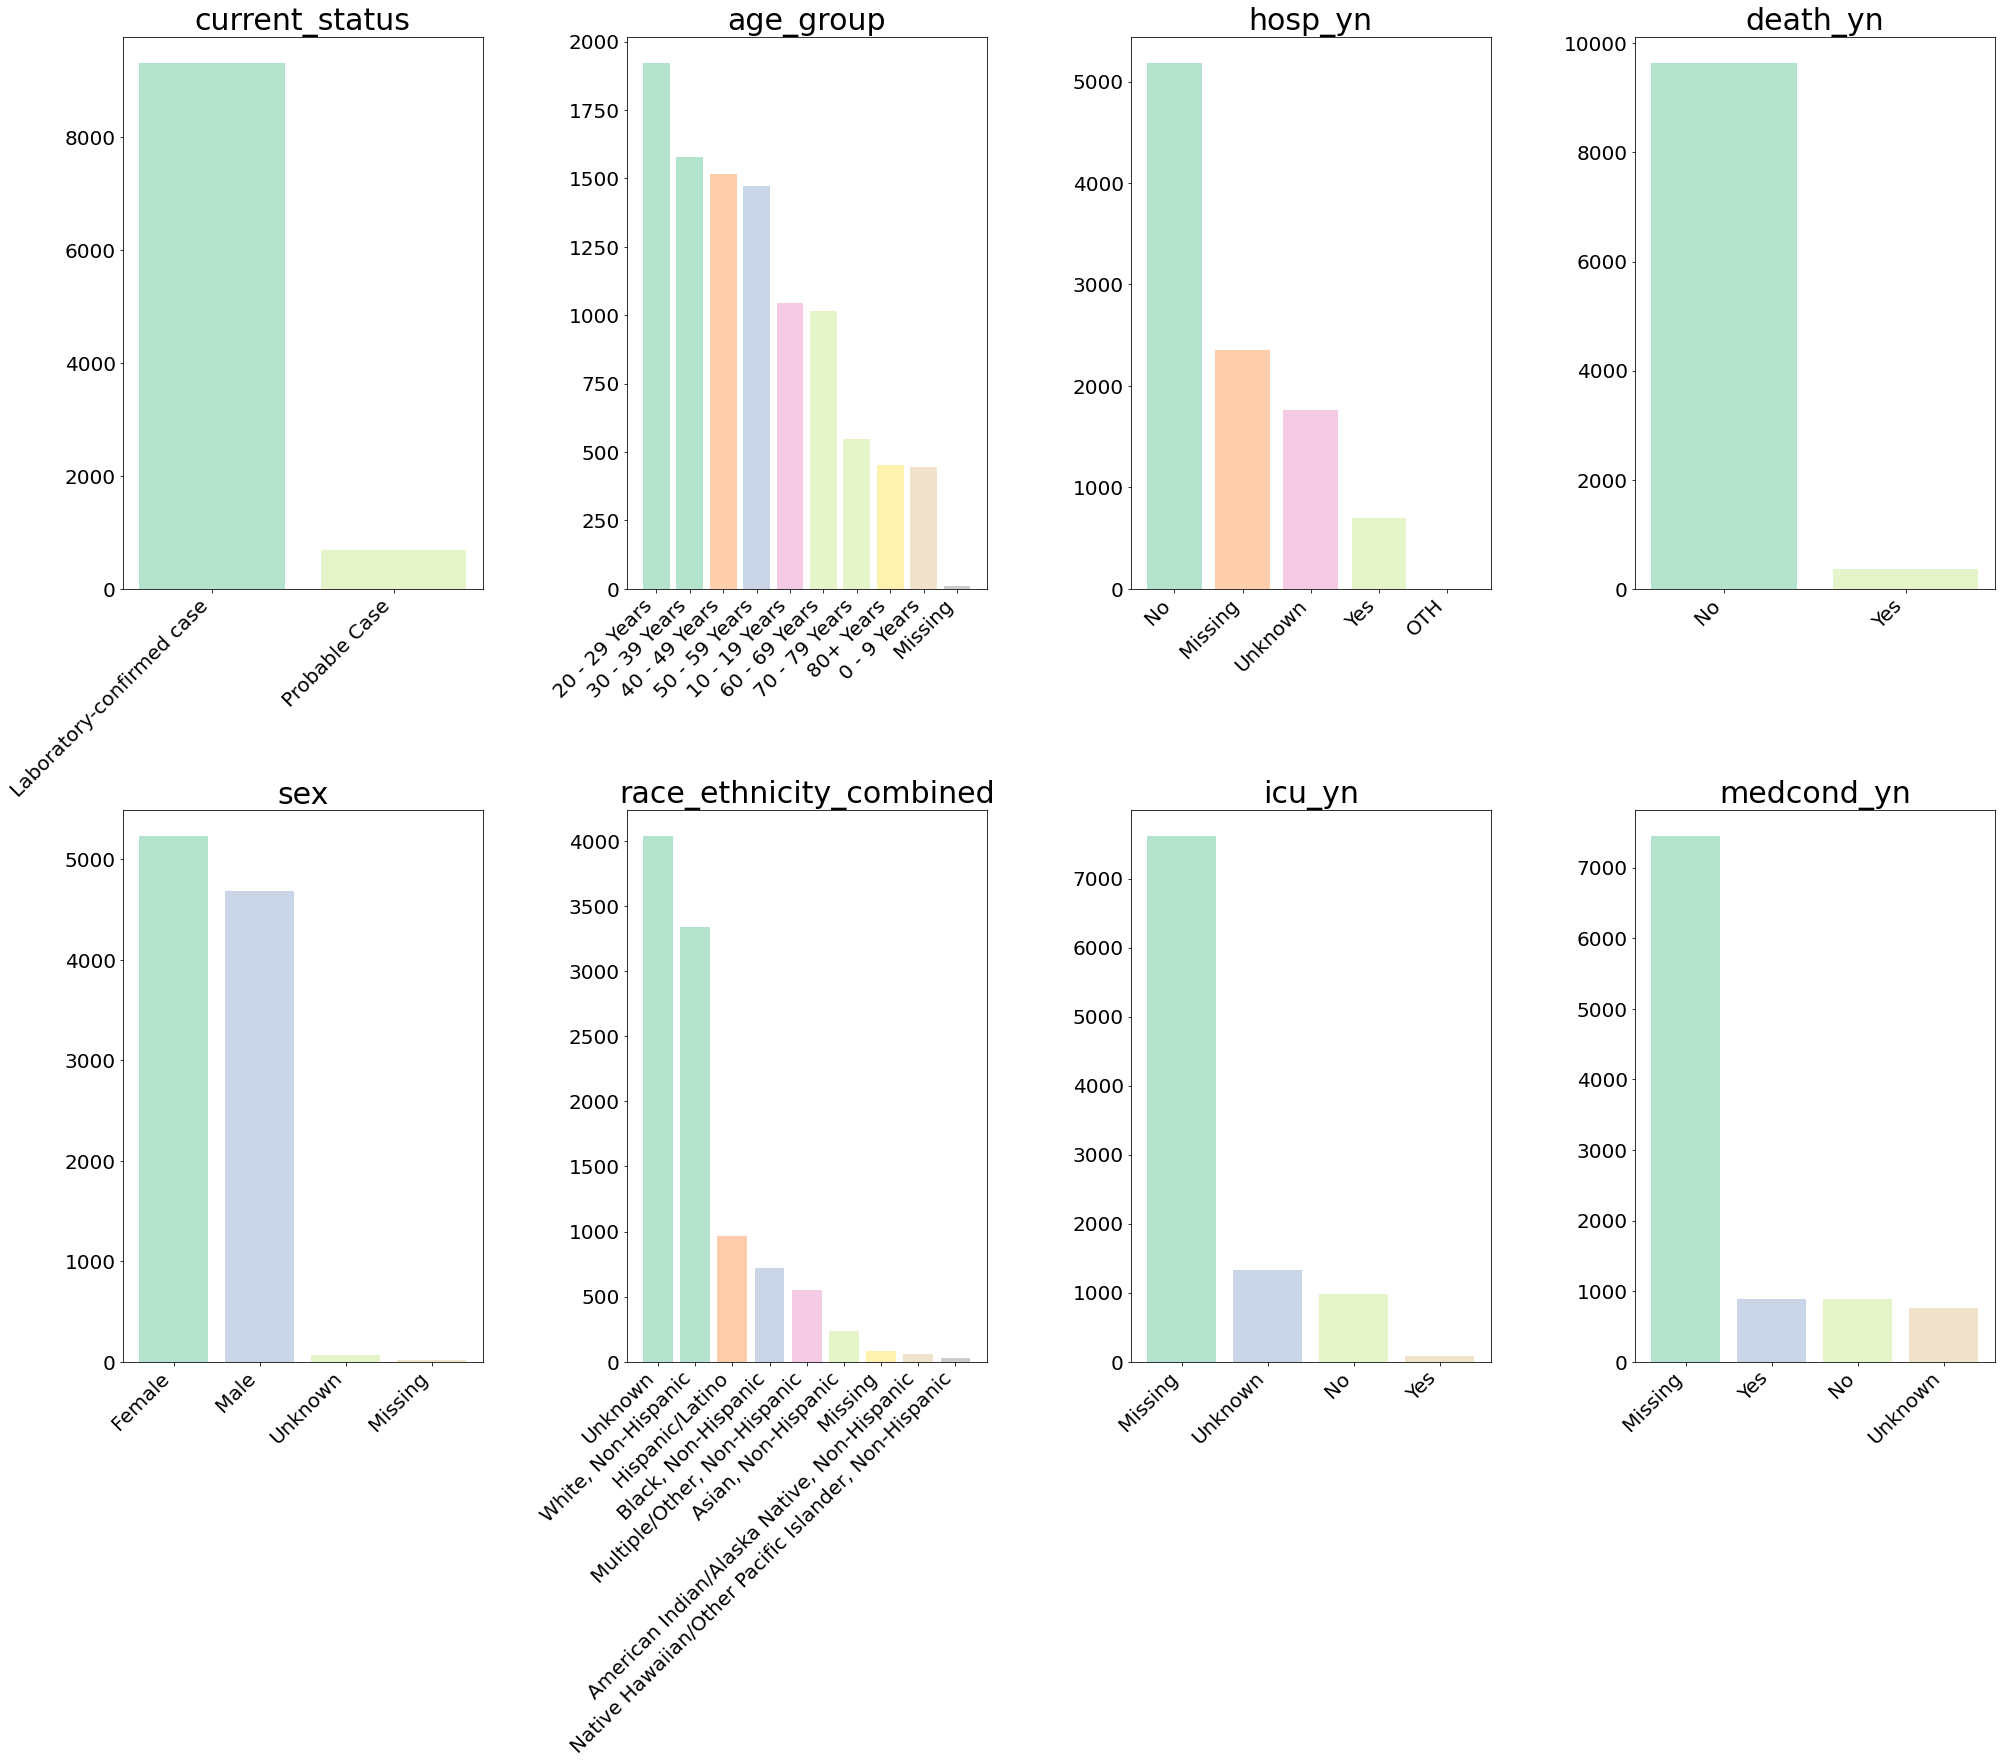

In [47]:
# bar charts of all the categorical features
fig, ax = plt.subplots(2, 4, figsize=(32.5,23))
row, col = 0, 0

for column in category_columns:
    
    cs=cm.Pastel2(np.arange(len(df_1[column].unique()))/len(df_1[column].unique()))
    ax[row, col].bar(df_1[column].value_counts().index, df_1[column].value_counts(), color=cs)
    ax[row, col].set_title(column, fontsize= 30)
    ax[row, col].set_xticklabels(df_1[column].value_counts().index, rotation=45, ha='right')
    ax[row, col].tick_params(axis='both', which='major', labelsize=20)

    row+=1
    if row == 2:
        row = 0
        col += 1
        
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
with PdfPages("charts/category_columns_bar_charts.pdf") as pp:
    pp.savefig(dpi=fig.dpi)

plt.show()

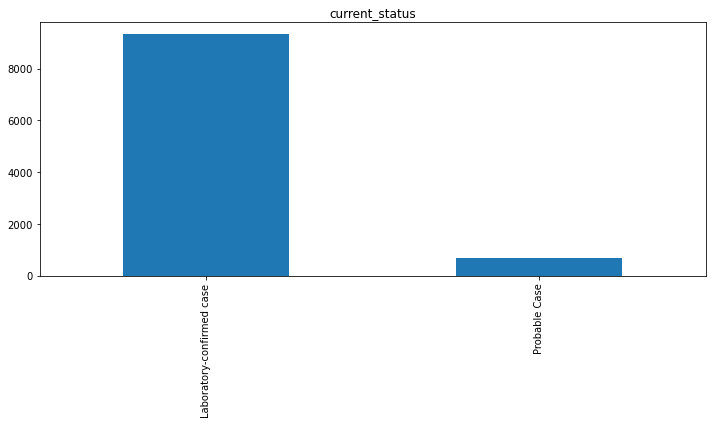

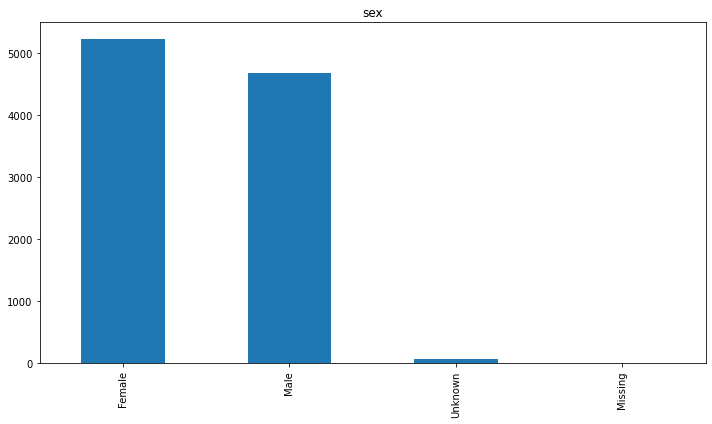

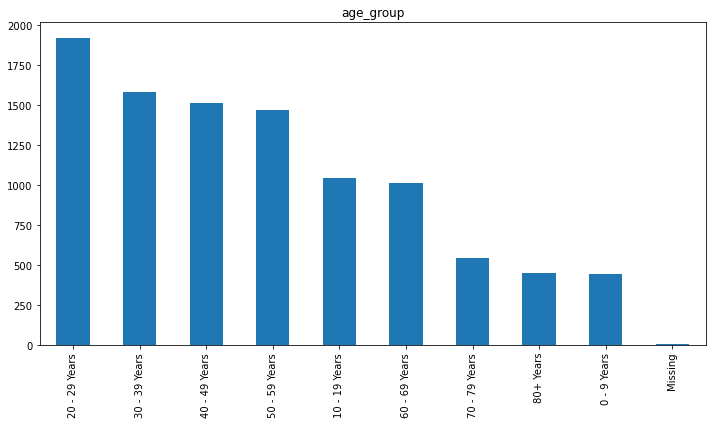

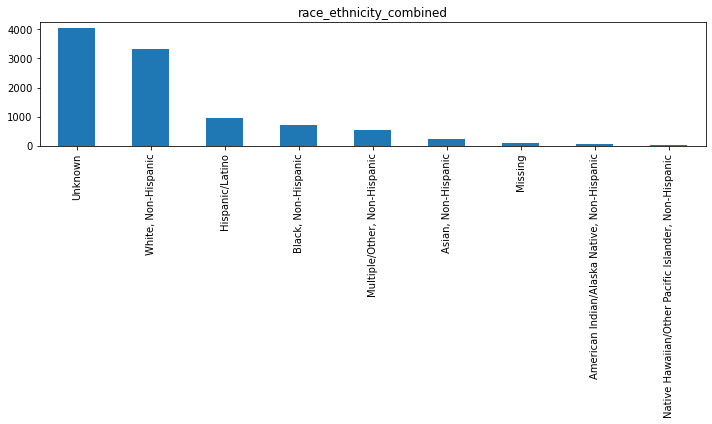

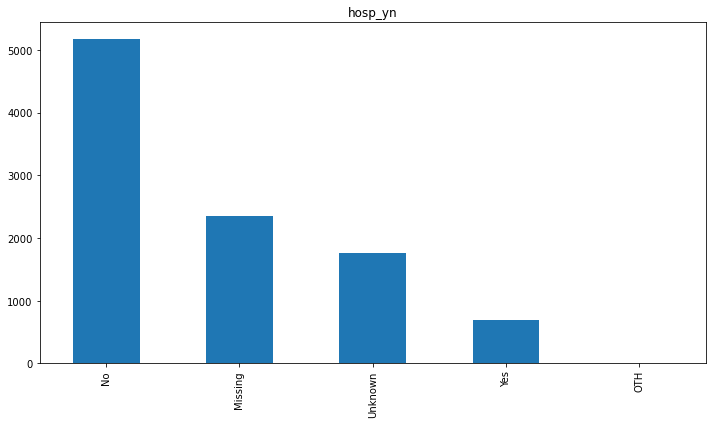

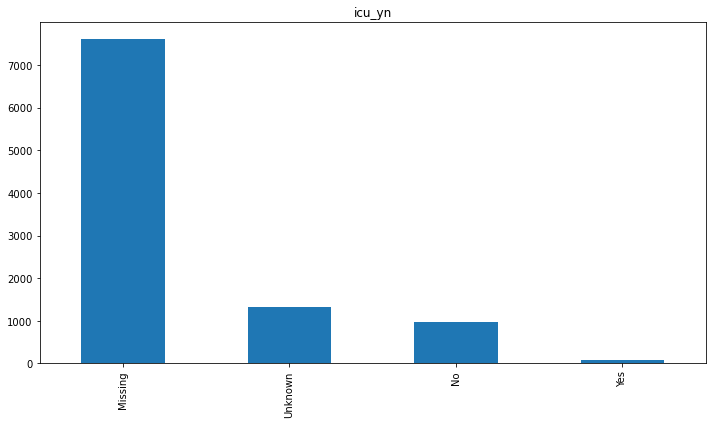

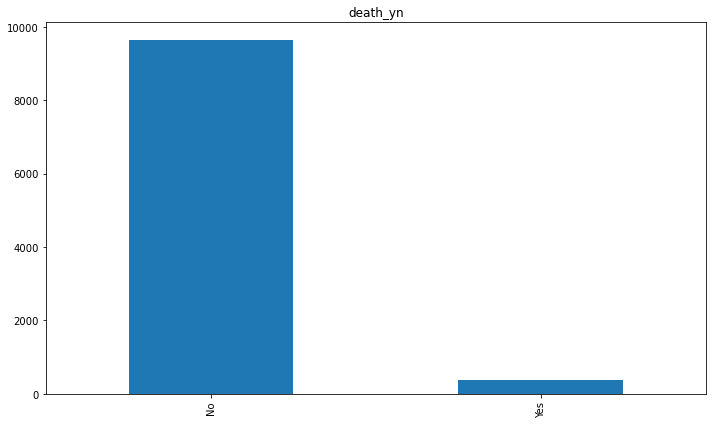

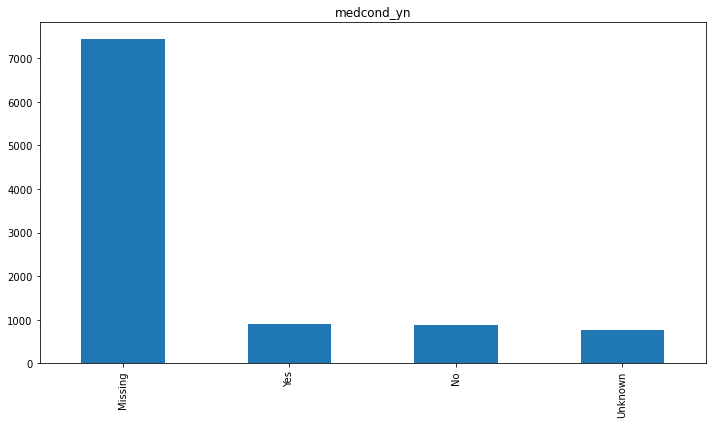

In [48]:
# pie charts of the categorical columns#
with PdfPages("charts/category_columns_bar_charts_1_1.pdf") as pp:
    for column in category_columns:
        plt.rcParams.update({'figure.autolayout': True})
        plt.figure(figsize=(10,6))
        plt.title(column)
        f = df_1[column].value_counts().plot.bar()
        pp.savefig(f.get_figure())

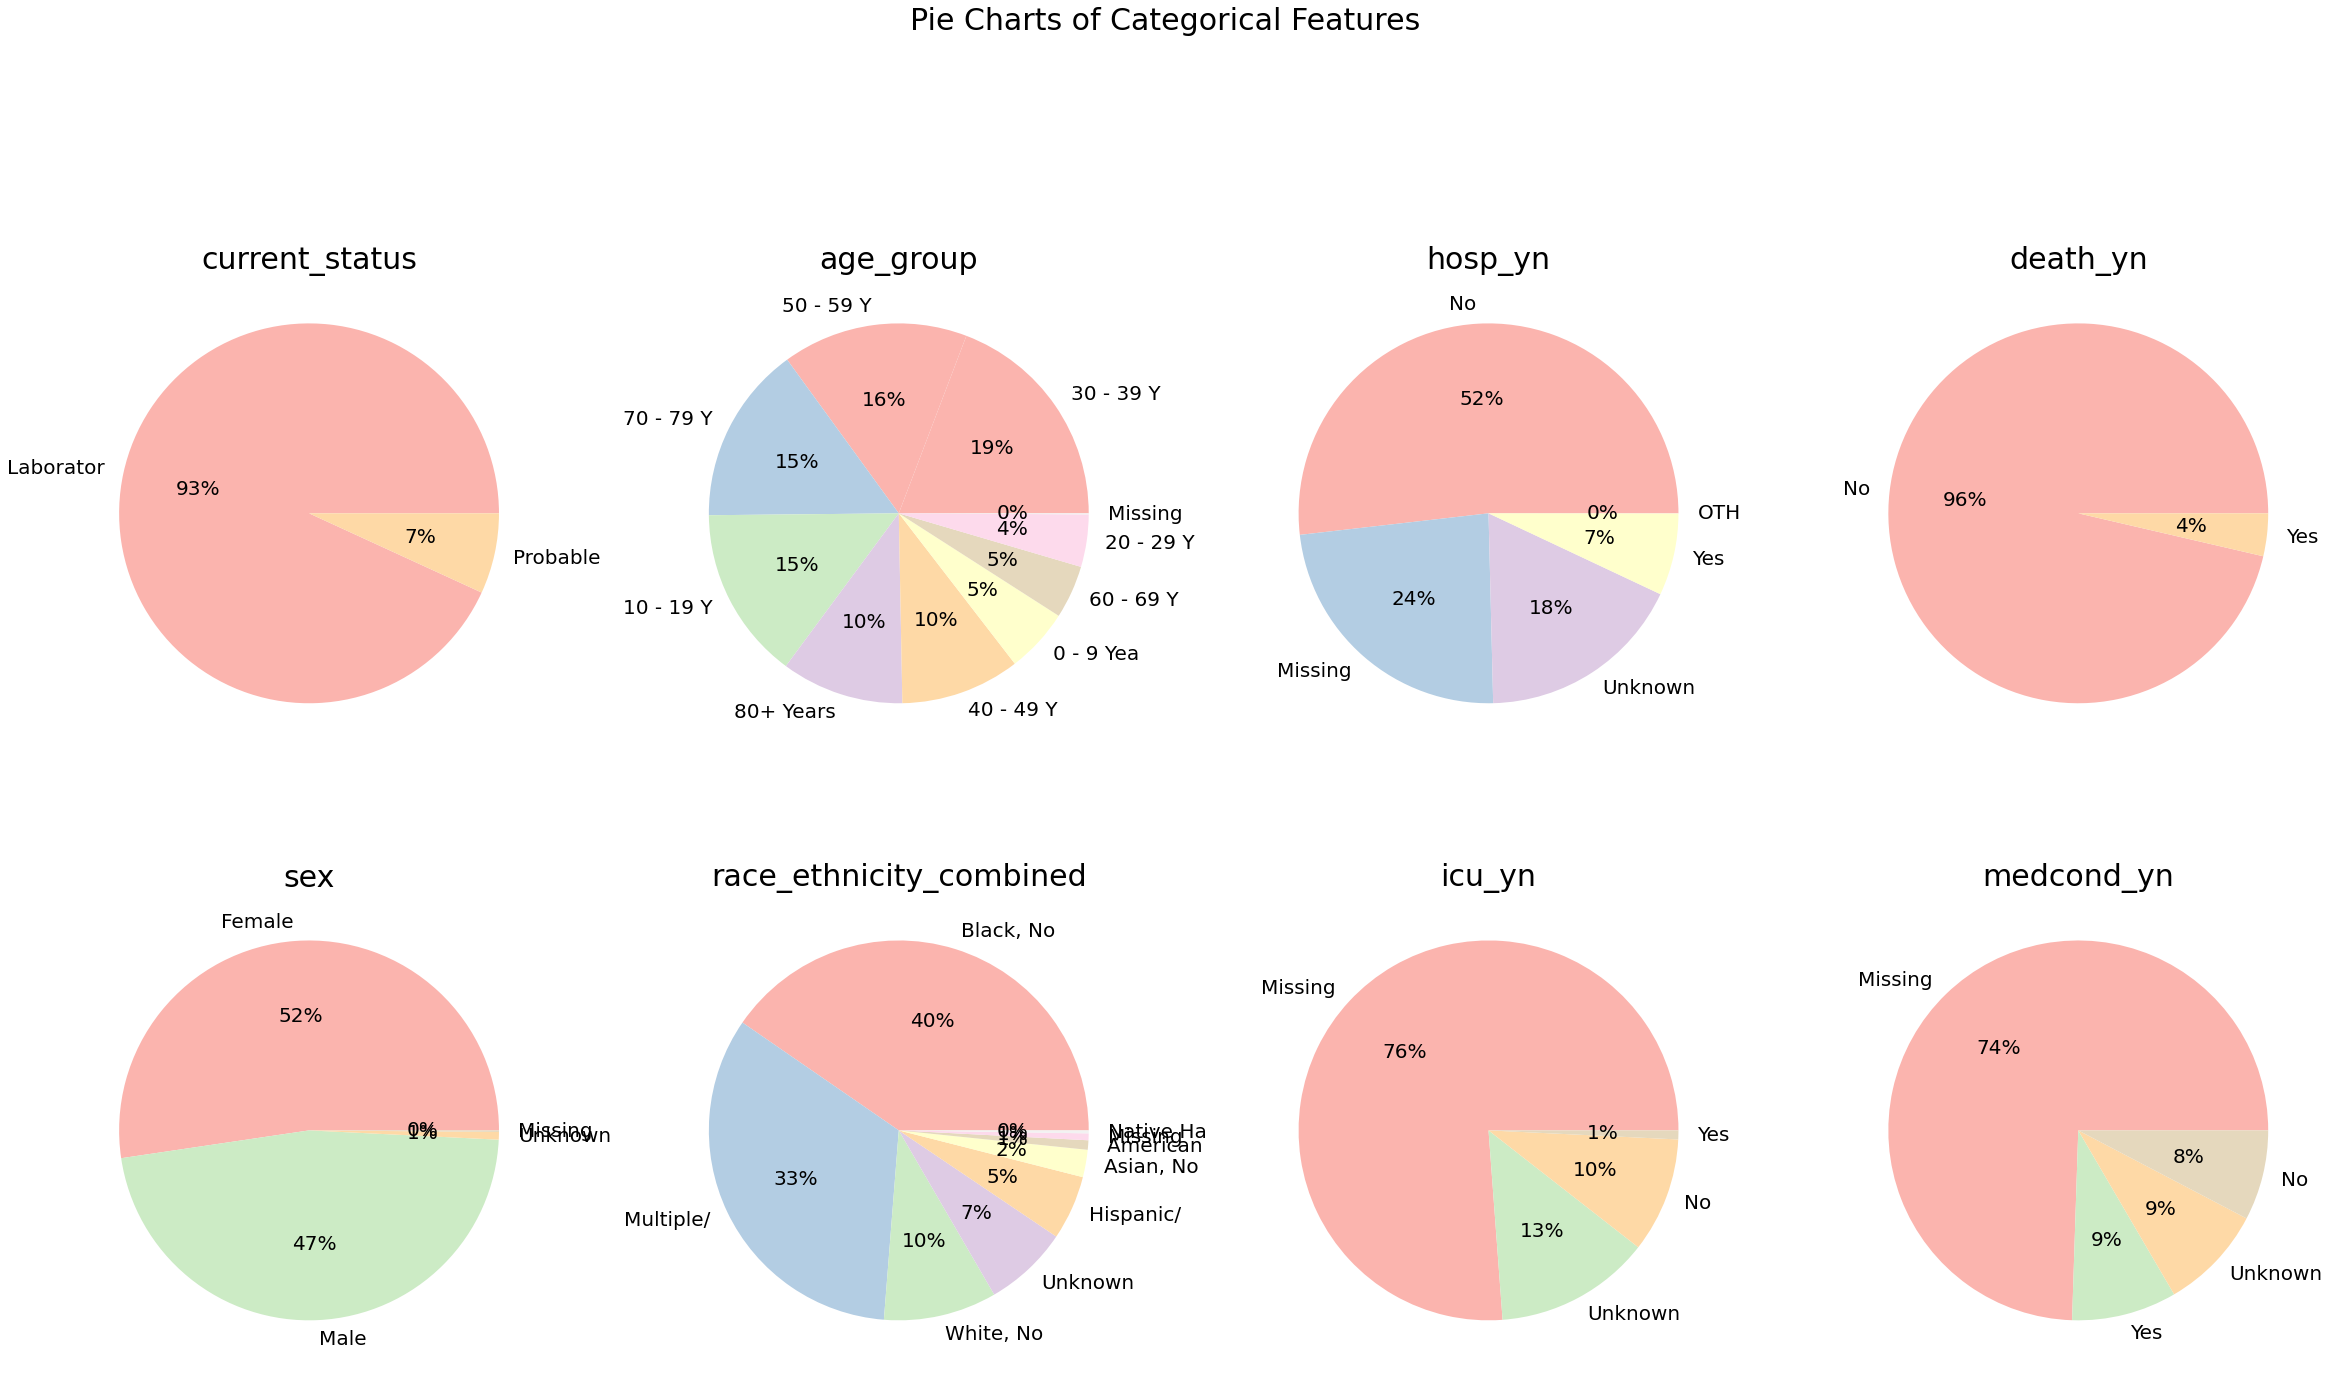

In [49]:
# pie charts of all the categorical features
fig, ax = plt.subplots(2, 4, figsize=(32.5,23))
row, col = 0, 0
fig.suptitle('Pie Charts of Categorical Features', fontsize=30)

for column in category_columns:
    labels = [e[:9] for e in df_1[column].unique()]
    cs=cm.Pastel1(np.arange(len(df_1[column].unique()))/len(df_1[column].unique()))
    ax[row, col].pie(df_1[column].value_counts(), autopct="%1.0f%%", labels=labels, colors=cs, textprops={'fontsize':20})
    ax[row, col].set_title(column, fontsize= 30)
    #ax[row, col].set_xticklabels(df_1[column].value_counts().index, rotation=45, ha='right')
    ax[row, col].tick_params(axis='both', which='major', labelsize=40)

    row+=1
    if row == 2:
        row = 0
        col += 1
with PdfPages("charts/category_columns_pie_charts.pdf") as pp:
    pp.savefig(fig.get_figure(), dpi=100)
        
plt.show()

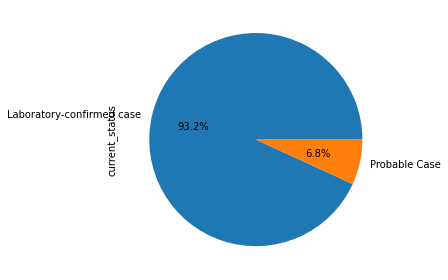

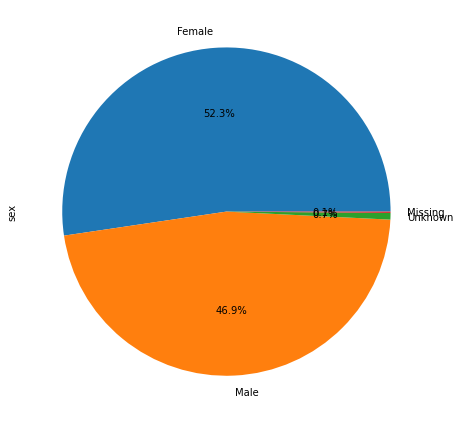

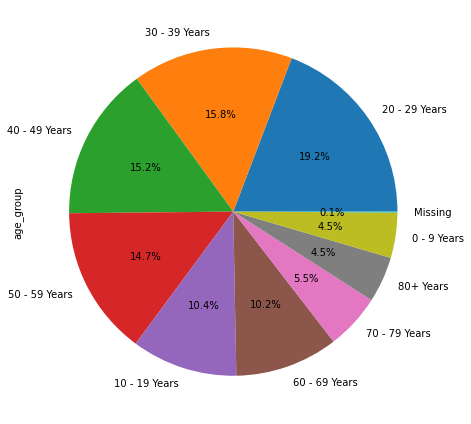

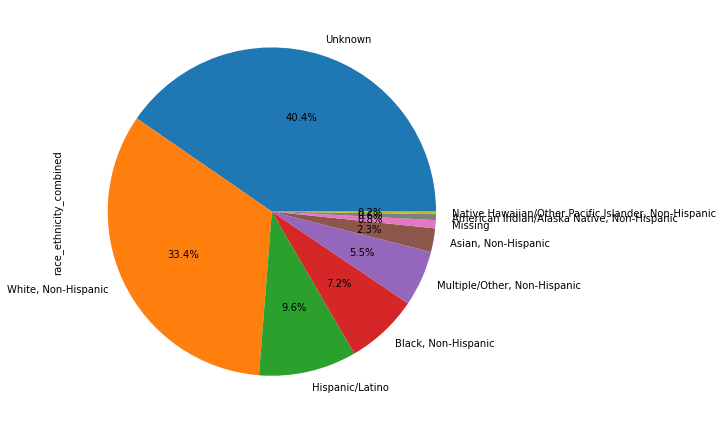

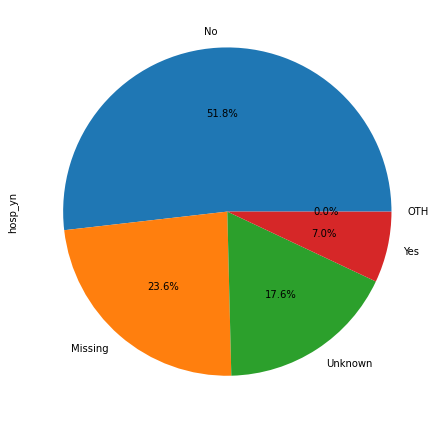

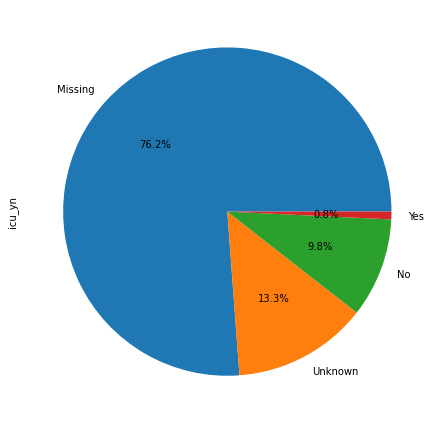

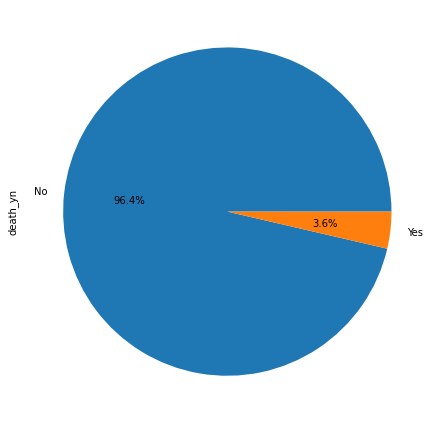

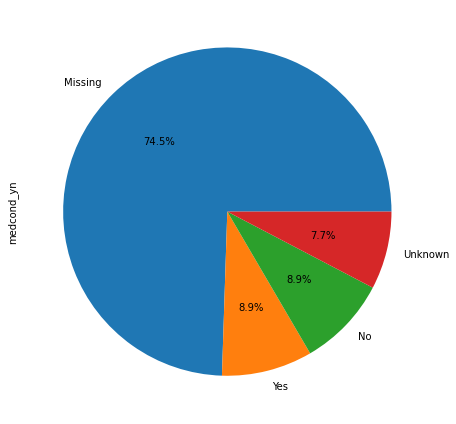

<Figure size 720x432 with 0 Axes>

In [50]:
# pie charts of the categorical columns
with PdfPages("charts/category_columns_pie_charts_1_1.pdf") as pp:
    for column in category_columns:
        f = df_1[column].value_counts().plot.pie(autopct="%1.1f%%")
        plt.figure(figsize=(10,6))
        pp.savefig(f.get_figure())

Above we can see each of the categorical feature has at most 10 unique values and at least 2. I will now discuss general statistics and to do's for each of these columns.

- ### current_status: 
    - this has two unique values
    - from below we can see that laboratory confirmed case is the most common (93%)
    - this makes sense as we would expect cases to be lab confirmed
    -[x] **TODO: investigate what probable-case means**  
    - Answer below from [here](https://www.cdc.gov/coronavirus/2019-ncov/covid-data/faq-surveillance.html#accordion-6011a2189eed2-collapse-1:~:text=A%20probable%20case%20or%20death%20is,no%20confirmatory%20laboratory%20evidence%20for%20SARS%2DCoV%2D2.)
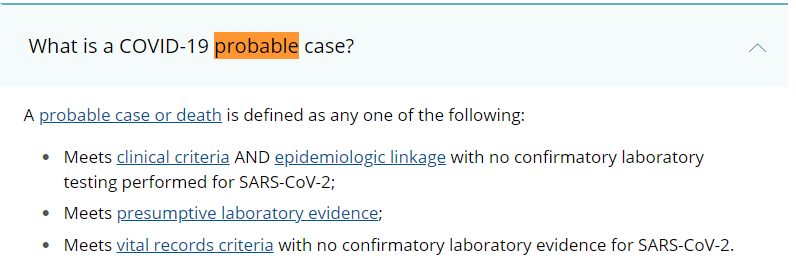
    &nbsp;


- ### sex: 
    - this has 4 unique values
    - Female and Male make up the majority
    - Female is slightly higher than male (52% vs 47%), this should be kept in mind when analysing other rows independently of sex
    - Unknown and missing only make up <1% of the the the total rows
    -[x] **TODO investigate difference between unknown and missing**  
    - Answer: From [this](https://www.cdc.gov/coronavirus/2019-ncov/downloads/php/COVID-Data-Dictionary_508.pdf) Pdf file, we can see that Unknown is a choice when filling out the surveys for collecting this data, so this happens at the point of data collection. We can then see that missing values encompass cases where the values were not filled in. Note: This means that Unknown may have more significance than missing.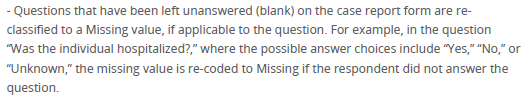
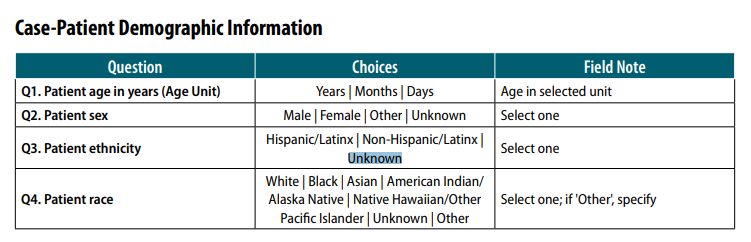
    &nbsp;

- ### age_group: 
    - this has 10 unique values
    - goes from 0 up to 100+ and also includes missing
    - missing makes up a small proportion of the total <0.1%
    - 20 - 29 Years has the highest frequency (20%) while 0-9 years has the lowest (4.5%)
    - 80+ Years & 70 - 79 Years both have small proportions here (<5% each)
    - Middle age ranges from 20 up to 60 have the highest frequencies
    -[x] **TODO: Investigate why old age have much lower frequency** 
    - Answer: This seems to be the case on a more general level when looking at all Covid-19 statistics for America and not just for this sample taken here. See below for case data of Covid-19 for America by age group taken from [here](https://covid.cdc.gov/covid-data-tracker/#demographics) on 05/03/2021. Note that this does not link directly back to the proprotions stated here as the above includes both positive and negative cases while the below covers only positive cases. It still stands to reason that those who are getting tested are more likely to be a positive case than those who are not so it still may reflect back relatively proportionality. This will be further looked into below, when looking at positive cases alone.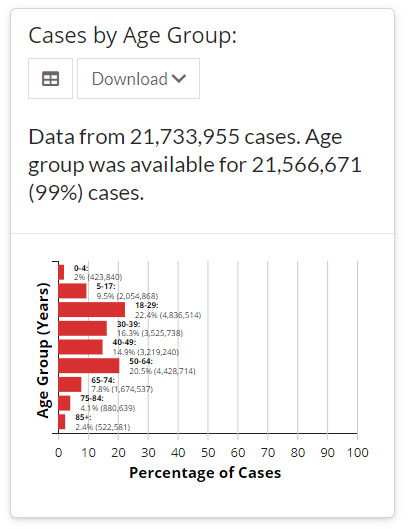
    &nbsp;

- ### race_ethnicity_combined: 
    - this has 9 unique values
    - Unknown is the highest frequency value here at 40%, possibly because it wasn't collected although could be down to people choosing not to answer this question - worth looking into
    - White by far makes up the highest proportion of the known data here at 33%
    - Other race/ethnicites make up much smaller proportions
    -[ ] **TODO: Investigate large unknown value and why white makes up such a large proportion of the data**  
    - Answer: I was unable to find further information on whether unknown values are the same across a larger sample. From the below taken from [here](https://covid.cdc.gov/covid-data-tracker/#demographics) on 05/03/2021, we can see that White, Non-Hispanic group makes up the largest reported proportion at a total level of Covid-19 cases in America, and also make up about 50% of the total population.

_ | _ 
- | - 
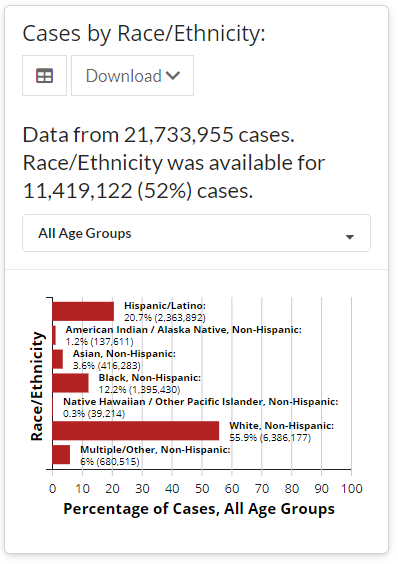 | 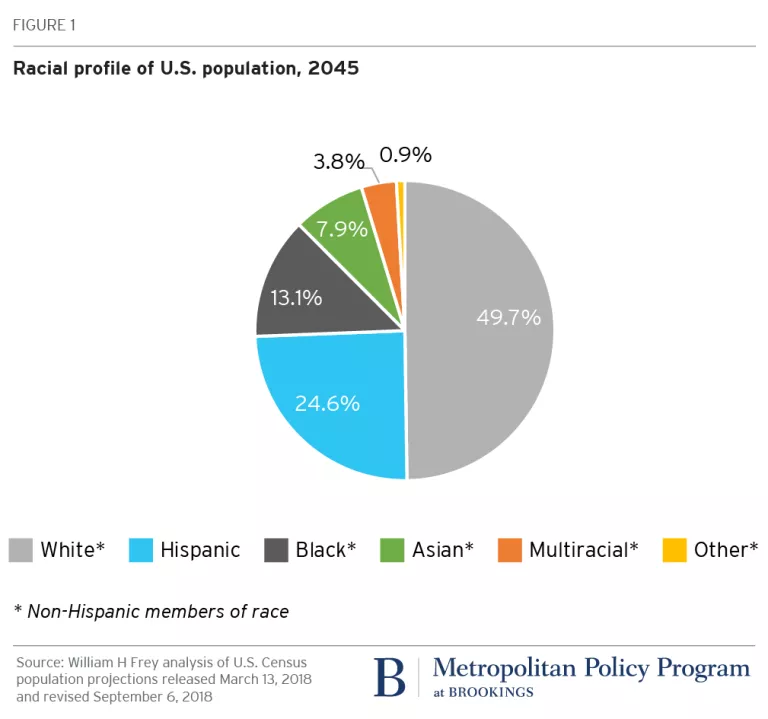
&nbsp;
    
- ### hosp_yn: 
    - this has 5 unique values
    - No makes up the largest proportion here at 52%
    - Unknown and missing makes up about 40%
    - Yes makes up about 7%
    &nbsp;
    
- ### icu_yn: 
    - this has 4 unique values
    - Missing makes up the largest proportion here at 76%
    - Together unknown and missing make up 89% of the values
    - Yes makes up about 0.76%
    &nbsp;
    
- ### death_yn: 
    - this has 2 unique values
    - No makes up the largest proportion here at 96%
    - The remaining are Yes
    &nbsp;

- ### medcond_yn: 
    - this has 4 unique values
    - Missing makes up the largest proporiton here at 74%
    - Yes and No both make up similar proportions at ~9% each
    - Unknown makes up the remaining 8%
    &nbsp;

# (2). Data Understanding: Data Quality Plan
   
| Feature                 | Data Quality Issue         | Handling Strategy         |
|-------------------------|----------------------      |------------------------   |
|cdc_case_earliest_dt (datetime64[ns]) |   All rows have values, although certain rows failed logical integrity tests|Remove rows failing datetime based logical integrity tests|
cdc_report_dt (datetime64[ns])             | 275 null values (2.8%)              | This column has been dropped as it is deprecated |       
pos_spec_dt (datetime64[ns])       | 7100 null values (71%) | This column has been dropped in the previous section |
onset_dt (datetime64[ns])             | 4023 null values (40%) | Impute values as suggested in feedback | 
current_status (category)                 | All rows have valid values- a large number of rows fail logical integrity test| Keep as is, need to checked with domain expert as >6000 rows fail integrity test|   
sex (category)                 | None Identified, almost all rows have valid Male/Female values (>99% valid) | Keep as is|   
age_group (category)                | None Identified, almost all rows have valid values (>99% valid) | Keep as is|
race_ethnicity_combined (category)    | 40.4% unknown values | Keep as is but take missing values into account when analysing|
hosp_yn (category)                  | 41% missing/unknown/OTH values | Take missing values into account when analysing, not worth dropping. Also take into account one row with value OTH|
icu_yn (category)                 | 89% missing/unknown values | Take into account when analysing, not worth dropping feature as would expect this to be a high predictor death |    
death_yn (category)                    | None identified, all rows have valid yes/no values | Keep as is, also worth taking into account when choosing not to drop other rows for missing features as the ultimate target feature is present in each row |   
medcond_yn (category)             | 84% missing/unknown values | Keep as is but take large number of missing values into account when analysing  |

### The initial list of issues as identified in the **Data_Quality_Report_Initial_Findings.pdf**:
- A number of features have a large number of null/missing/unknown/other values present. Each of these features do provide value for the target outcome but it must be taken into account when analysing that the already small sample will be smaller due to lack of valid information. Imputation is another option which I will consider here.
- Special values: Missing and unknown values are seen throughout a number of the features. These values essentially both represent the same thing - that the needed value is not present.
- In the above section I have created 4 new columns. These columns represent categorical features that show the day of the week and month for each of the datetime columns that weren't dropped. This is useful for aggregate analysis but these values would need to be encoded to be used in a model.
- Special value: OTH - this is seen in one row in hosp_yn

### A. Propose solutions to deal with the problems identified.
1. New object columns need to be converted to category
    - All new day and month columns that were added in the previous step should be category type rather than object
2. Special Values: Missing, unknown
    - These values appear in these features: icu_yn, medcond_yn, hosp_yn, race_ethnicity_combined, age_group, sex
    - Unknown represents when a value is unknown at the point of writing the information on a form about the case while Missing occurs when no information is written about that feature on the form.
    - These columns both represent an Unknown value and for the purpose of analysis I will be changing all values of Missing to Unknown across these features.
3. Special Value: OTH in hosp_yn
    - This value is seen once in hosp_yn feature
    - It should be investigated to see what it represents in the dataset
4. Remove rows which failed datetime based logical integrity tests

### B. Afterer performing the above recommendations, I will be testing the following approaches on the data to see if they are worthwhile:
The new dataframes will be named as follows:
1. __final_df_nomiss__: 
Problem: Large amount of missing data  
Solution: Remove all rows with missing data in any column

2. __final_df_nodup__:
Problem: Large amount of duplicates returned in duplicate analysis above  
Solution: Remove the duplicates and see what effect this has

3. __final_df_orig__: 
Problem: Unsure if either of the above steps wil result in any positive/noticeable change
Solution: Keep the original dataset that has been returned from above

### C. Following the above 3 steps, I will be encoding the categorical data in each dataframe and analysing them
This will result in 3 datasets to be analysed:
1. final_df_nomiss_en
2. final_df_nodup_en
3. final_df_orig_en

### - Apply your solutions to obtain a new CSV file where the identified data quality issues were addressed. 

# Imputed Values for Onset_dt

AMENDED: Imputed values for onset_dt
onset_dt column with  mean/median difference i.e., onset_dt = earliest_dt + mean(onset_dt - earliest_dt) and have also added a missing data feature for this feature

In [51]:
df_1["onset_dt"].isna().sum()

4923

In [52]:
# add missing value indicator
df_1['onset_dt_missing'] = (df_1['onset_dt'].isna()).astype(int)
df_1

cdc_case_earliest_dt cdc_report_dt pos_spec_dt   onset_dt  \
0              2020-03-30    2020-04-21         NaT 2020-03-30   
1              2020-12-11           NaT         NaT        NaT   
2              2020-08-19    2020-08-19  2020-08-19        NaT   
3              2020-10-24    2020-10-24         NaT 2020-10-24   
4              2021-01-11    2021-01-11  2021-01-11        NaT   
...                   ...           ...         ...        ...   
9995           2020-03-21    2020-06-10         NaT        NaT   
9996           2020-12-25    2020-12-30         NaT 2020-12-25   
9997           2020-10-19    2020-10-25         NaT 2020-10-19   
9998           2020-07-13    2020-07-13         NaT        NaT   
9999           2020-10-17    2020-10-24  2020-10-20 2020-10-17   

                 current_status     sex      age_group  \
0     Laboratory-confirmed case  Female  30 - 39 Years   
1     Laboratory-confirmed case    Male  50 - 59 Years   
2     Laboratory-confirmed case    Male  70 - 79 Years   
3     Laboratory-confirmed case    Male  70 - 79 Years   
4     Laboratory-confirmed case    Male  10 - 19 Years   
...                         ...     ...            ...   
9995  Laboratory-confirmed case  Female  40 - 49 Years   
9996  Laboratory-confirmed case    Male  60 - 69 Years   
9997  Laboratory-confirmed case  Female  30 - 39 Years   
9998  Laboratory-confirmed case    Male  30 - 39 Years   
9999  Laboratory-confirmed case  Female  20 - 29 Years   

           race_ethnicity_combined  hosp_yn   icu_yn death_yn medcond_yn  \
0              Black, Non-Hispanic       No  Missing       No    Missing   
1     Multiple/Other, Non-Hispanic  Missing  Missing       No    Missing   
2              White, Non-Hispanic       No  Unknown       No        Yes   
3                          Unknown       No  Missing       No    Missing   
4              White, Non-Hispanic       No  Unknown       No    Unknown   
...                            ...      ...      ...      ...        ...   
9995                       Unknown       No  Unknown       No        Yes   
9996           White, Non-Hispanic       No  Missing       No    Missing   
9997               Hispanic/Latino       No  Missing       No    Missing   
9998               Hispanic/Latino  Unknown  Missing       No    Missing   
9999           Black, Non-Hispanic  Missing  Missing       No         No   

     cdc_case_earliest_day onset_day cdc_case_earliest_month onset_month  \
0                   Monday    Monday                   March       March   
1                   Friday       NaN                December         NaN   
2                Wednesday       NaN                  August         NaN   
3                 Saturday  Saturday                 October     October   
4                   Monday       NaN                 January         NaN   
...                    ...       ...                     ...         ...   
9995              Saturday       NaN                   March         NaN   
9996                Friday    Friday                December    December   
9997                Monday    Monday                 October     October   
9998                Monday       NaN                    July         NaN   
9999              Saturday  Saturday                 October     October   

      onset_dt_missing  
0                    0  
1                    1  
2                    1  
3                    0  
4                    1  
...                ...  
9995                 1  
9996                 0  
9997                 0  
9998                 1  
9999                 0  

[10000 rows x 17 columns]

In [53]:
df_1['onset_dt'].fillna(df_1["cdc_case_earliest_dt"] + (df_1['onset_dt'] - df_1["cdc_case_earliest_dt"]).mean(), inplace = True)
df_1['onset_dt']

0      2020-03-30 00:00:00.000000000
1      2020-12-11 07:28:59.373645853
2      2020-08-19 07:28:59.373645853
3      2020-10-24 00:00:00.000000000
4      2021-01-11 07:28:59.373645853
                    ...             
9995   2020-03-21 07:28:59.373645853
9996   2020-12-25 00:00:00.000000000
9997   2020-10-19 00:00:00.000000000
9998   2020-07-13 07:28:59.373645853
9999   2020-10-17 00:00:00.000000000
Name: onset_dt, Length: 10000, dtype: datetime64[ns]

In [54]:
df_1['onset_dt'].isna().sum()

0

Update day and month columns values with new dates:

In [55]:
df_1['onset_day'] = df_1['onset_dt'].dt.day_name() 
df_1['onset_month'] = df_1['onset_dt'].dt.month_name()

In [56]:
df_1['onset_day'].unique()

array(['Monday', 'Friday', 'Wednesday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday'], dtype=object)

In [57]:
df_1['onset_month'].unique()

array(['March', 'December', 'August', 'October', 'January', 'April',
       'June', 'November', 'July', 'September', 'May', 'February'],
      dtype=object)

A1. __Make new object columns category__

In [58]:
#Select all columns of type 'object'
object_columns = df_1.select_dtypes(['object']).columns
object_columns

Index(['cdc_case_earliest_day', 'onset_day', 'cdc_case_earliest_month',
       'onset_month'],
      dtype='object')

In [59]:
# set all object columns to category type
for column in object_columns:
    df_1[column] = df_1[column].astype('category')

In [60]:
#check columns
df_1.dtypes

cdc_case_earliest_dt       datetime64[ns]
cdc_report_dt              datetime64[ns]
pos_spec_dt                datetime64[ns]
onset_dt                   datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                         category
medcond_yn                       category
cdc_case_earliest_day            category
onset_day                        category
cdc_case_earliest_month          category
onset_month                      category
onset_dt_missing                    int32
dtype: object

In [61]:
df_1.head()

cdc_case_earliest_dt cdc_report_dt pos_spec_dt  \
0           2020-03-30    2020-04-21         NaT   
1           2020-12-11           NaT         NaT   
2           2020-08-19    2020-08-19  2020-08-19   
3           2020-10-24    2020-10-24         NaT   
4           2021-01-11    2021-01-11  2021-01-11   

                       onset_dt             current_status     sex  \
0 2020-03-30 00:00:00.000000000  Laboratory-confirmed case  Female   
1 2020-12-11 07:28:59.373645853  Laboratory-confirmed case    Male   
2 2020-08-19 07:28:59.373645853  Laboratory-confirmed case    Male   
3 2020-10-24 00:00:00.000000000  Laboratory-confirmed case    Male   
4 2021-01-11 07:28:59.373645853  Laboratory-confirmed case    Male   

       age_group       race_ethnicity_combined  hosp_yn   icu_yn death_yn  \
0  30 - 39 Years           Black, Non-Hispanic       No  Missing       No   
1  50 - 59 Years  Multiple/Other, Non-Hispanic  Missing  Missing       No   
2  70 - 79 Years           White, Non-Hispanic       No  Unknown       No   
3  70 - 79 Years                       Unknown       No  Missing       No   
4  10 - 19 Years           White, Non-Hispanic       No  Unknown       No   

  medcond_yn cdc_case_earliest_day  onset_day cdc_case_earliest_month  \
0    Missing                Monday     Monday                   March   
1    Missing                Friday     Friday                December   
2        Yes             Wednesday  Wednesday                  August   
3    Missing              Saturday   Saturday                 October   
4    Unknown                Monday     Monday                 January   

  onset_month  onset_dt_missing  
0       March                 0  
1    December                 1  
2      August                 1  
3     October                 0  
4     January                 1

A2. __Replace all values of Missing with Unknown across all features__

In [62]:
df_2 = df_1.replace("Missing", "Unknown")

In [63]:
df_2.head()

cdc_case_earliest_dt cdc_report_dt pos_spec_dt  \
0           2020-03-30    2020-04-21         NaT   
1           2020-12-11           NaT         NaT   
2           2020-08-19    2020-08-19  2020-08-19   
3           2020-10-24    2020-10-24         NaT   
4           2021-01-11    2021-01-11  2021-01-11   

                       onset_dt             current_status     sex  \
0 2020-03-30 00:00:00.000000000  Laboratory-confirmed case  Female   
1 2020-12-11 07:28:59.373645853  Laboratory-confirmed case    Male   
2 2020-08-19 07:28:59.373645853  Laboratory-confirmed case    Male   
3 2020-10-24 00:00:00.000000000  Laboratory-confirmed case    Male   
4 2021-01-11 07:28:59.373645853  Laboratory-confirmed case    Male   

       age_group       race_ethnicity_combined  hosp_yn   icu_yn death_yn  \
0  30 - 39 Years           Black, Non-Hispanic       No  Unknown       No   
1  50 - 59 Years  Multiple/Other, Non-Hispanic  Unknown  Unknown       No   
2  70 - 79 Years           White, Non-Hispanic       No  Unknown       No   
3  70 - 79 Years                       Unknown       No  Unknown       No   
4  10 - 19 Years           White, Non-Hispanic       No  Unknown       No   

  medcond_yn cdc_case_earliest_day  onset_day cdc_case_earliest_month  \
0    Unknown                Monday     Monday                   March   
1    Unknown                Friday     Friday                December   
2        Yes             Wednesday  Wednesday                  August   
3    Unknown              Saturday   Saturday                 October   
4    Unknown                Monday     Monday                 January   

  onset_month  onset_dt_missing  
0       March                 0  
1    December                 1  
2      August                 1  
3     October                 0  
4     January                 1

In [64]:
#Select all columns of type 'category'
cat_columns = df_2.select_dtypes(['category']).columns
cat_columns

Index(['current_status', 'sex', 'age_group', 'race_ethnicity_combined',
       'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn', 'cdc_case_earliest_day',
       'onset_day', 'cdc_case_earliest_month', 'onset_month'],
      dtype='object')

In [65]:
# high level check for values of Missing
for column in cat_columns:
    print(df_2[column].unique())

['Laboratory-confirmed case', 'Probable Case']
Categories (2, object): ['Laboratory-confirmed case', 'Probable Case']
['Female', 'Male', 'Unknown']
Categories (3, object): ['Female', 'Male', 'Unknown']
['30 - 39 Years', '50 - 59 Years', '70 - 79 Years', '10 - 19 Years', '80+ Years', '40 - 49 Years', '0 - 9 Years', '60 - 69 Years', '20 - 29 Years', 'Unknown']
Categories (10, object): ['30 - 39 Years', '50 - 59 Years', '70 - 79 Years', '10 - 19 Years', ..., '0 - 9 Years', '60 - 69 Years', '20 - 29 Years', 'Unknown']
['Black, Non-Hispanic', 'Multiple/Other, Non-Hispanic', 'White, Non-Hispanic', 'Unknown', 'Hispanic/Latino', 'Asian, Non-Hispanic', 'American Indian/Alaska Native, Non-Hispanic', 'Native Hawaiian/Other Pacific Islander, Non-H...]
Categories (8, object): ['Black, Non-Hispanic', 'Multiple/Other, Non-Hispanic', 'White, Non-Hispanic', 'Unknown', 'Hispanic/Latino', 'Asian, Non-Hispanic', 'American Indian/Alaska Native, Non-Hispanic', 'Native Hawaiian/Other Pacific Islander, Non-H.

In [66]:
# check that no columns have Missing as a value
for column in cat_columns:
    missing_vals =  df_2.loc[df_2[column] == "Missing"]
    if missing_vals.empty:
        print(column,  "- No Values = Missing")

current_status - No Values = Missing
sex - No Values = Missing
age_group - No Values = Missing
race_ethnicity_combined - No Values = Missing
hosp_yn - No Values = Missing
icu_yn - No Values = Missing
death_yn - No Values = Missing
medcond_yn - No Values = Missing
cdc_case_earliest_day - No Values = Missing
onset_day - No Values = Missing
cdc_case_earliest_month - No Values = Missing
onset_month - No Values = Missing


A3. **Special Value: OTH in hosp_yn**

In [67]:
# isolate the value of OTH
df_2.loc[df_2['hosp_yn'] == "OTH"]

cdc_case_earliest_dt cdc_report_dt pos_spec_dt   onset_dt  \
1286           2020-03-21    2021-01-16  2020-03-25 2020-03-21   

                 current_status     sex      age_group  \
1286  Laboratory-confirmed case  Female  60 - 69 Years   

     race_ethnicity_combined hosp_yn   icu_yn death_yn medcond_yn  \
1286                 Unknown     OTH  Unknown       No        Yes   

     cdc_case_earliest_day onset_day cdc_case_earliest_month onset_month  \
1286              Saturday  Saturday                   March       March   

      onset_dt_missing  
1286                 0

From the above, we can see that all other values in this row are valid apart from the hosp_yn value. Because this value is not described in the data dictionary and appears to be invalid, I have chosen to drop this value. It may be good to ask the domain expert how to handle this value.

In [68]:
# drop the value of OTH from the dataframe
df_2 = df_2[df_2.hosp_yn != "OTH"]

A4. __Remove rows which failed datetime logical integrity tests__

In [69]:
df_2 = df_2.drop(df_2[(df_2.cdc_report_dt-df_2.cdc_case_earliest_dt).astype('timedelta64[D]') < 0].index)

df_2

cdc_case_earliest_dt cdc_report_dt pos_spec_dt  \
0              2020-03-30    2020-04-21         NaT   
1              2020-12-11           NaT         NaT   
2              2020-08-19    2020-08-19  2020-08-19   
3              2020-10-24    2020-10-24         NaT   
4              2021-01-11    2021-01-11  2021-01-11   
...                   ...           ...         ...   
9995           2020-03-21    2020-06-10         NaT   
9996           2020-12-25    2020-12-30         NaT   
9997           2020-10-19    2020-10-25         NaT   
9998           2020-07-13    2020-07-13         NaT   
9999           2020-10-17    2020-10-24  2020-10-20   

                          onset_dt             current_status     sex  \
0    2020-03-30 00:00:00.000000000  Laboratory-confirmed case  Female   
1    2020-12-11 07:28:59.373645853  Laboratory-confirmed case    Male   
2    2020-08-19 07:28:59.373645853  Laboratory-confirmed case    Male   
3    2020-10-24 00:00:00.000000000  Laboratory-confirmed case    Male   
4    2021-01-11 07:28:59.373645853  Laboratory-confirmed case    Male   
...                            ...                        ...     ...   
9995 2020-03-21 07:28:59.373645853  Laboratory-confirmed case  Female   
9996 2020-12-25 00:00:00.000000000  Laboratory-confirmed case    Male   
9997 2020-10-19 00:00:00.000000000  Laboratory-confirmed case  Female   
9998 2020-07-13 07:28:59.373645853  Laboratory-confirmed case    Male   
9999 2020-10-17 00:00:00.000000000  Laboratory-confirmed case  Female   

          age_group       race_ethnicity_combined  hosp_yn   icu_yn death_yn  \
0     30 - 39 Years           Black, Non-Hispanic       No  Unknown       No   
1     50 - 59 Years  Multiple/Other, Non-Hispanic  Unknown  Unknown       No   
2     70 - 79 Years           White, Non-Hispanic       No  Unknown       No   
3     70 - 79 Years                       Unknown       No  Unknown       No   
4     10 - 19 Years           White, Non-Hispanic       No  Unknown       No   
...             ...                           ...      ...      ...      ...   
9995  40 - 49 Years                       Unknown       No  Unknown       No   
9996  60 - 69 Years           White, Non-Hispanic       No  Unknown       No   
9997  30 - 39 Years               Hispanic/Latino       No  Unknown       No   
9998  30 - 39 Years               Hispanic/Latino  Unknown  Unknown       No   
9999  20 - 29 Years           Black, Non-Hispanic  Unknown  Unknown       No   

     medcond_yn cdc_case_earliest_day  onset_day cdc_case_earliest_month  \
0       Unknown                Monday     Monday                   March   
1       Unknown                Friday     Friday                December   
2           Yes             Wednesday  Wednesday                  August   
3       Unknown              Saturday   Saturday                 October   
4       Unknown                Monday     Monday                 January   
...         ...                   ...        ...                     ...   
9995        Yes              Saturday   Saturday                   March   
9996    Unknown                Friday     Friday                December   
9997    Unknown                Monday     Monday                 October   
9998    Unknown                Monday     Monday                    July   
9999         No              Saturday   Saturday                 October   

     onset_month  onset_dt_missing  
0          March                 0  
1       December                 1  
2         August                 1  
3        October                 0  
4        January                 1  
...          ...               ...  
9995       March                 1  
9996    December                 0  
9997     October                 0  
9998        July                 1  
9999     October                 0  

[9956 rows x 17 columns]

In [70]:
df_2 = df_2.drop(df_2[(df_2.pos_spec_dt-df_2.cdc_case_earliest_dt).astype('timedelta64[D]') < 0].index)

df_2

cdc_case_earliest_dt cdc_report_dt pos_spec_dt  \
0              2020-03-30    2020-04-21         NaT   
1              2020-12-11           NaT         NaT   
2              2020-08-19    2020-08-19  2020-08-19   
3              2020-10-24    2020-10-24         NaT   
4              2021-01-11    2021-01-11  2021-01-11   
...                   ...           ...         ...   
9995           2020-03-21    2020-06-10         NaT   
9996           2020-12-25    2020-12-30         NaT   
9997           2020-10-19    2020-10-25         NaT   
9998           2020-07-13    2020-07-13         NaT   
9999           2020-10-17    2020-10-24  2020-10-20   

                          onset_dt             current_status     sex  \
0    2020-03-30 00:00:00.000000000  Laboratory-confirmed case  Female   
1    2020-12-11 07:28:59.373645853  Laboratory-confirmed case    Male   
2    2020-08-19 07:28:59.373645853  Laboratory-confirmed case    Male   
3    2020-10-24 00:00:00.000000000  Laboratory-confirmed case    Male   
4    2021-01-11 07:28:59.373645853  Laboratory-confirmed case    Male   
...                            ...                        ...     ...   
9995 2020-03-21 07:28:59.373645853  Laboratory-confirmed case  Female   
9996 2020-12-25 00:00:00.000000000  Laboratory-confirmed case    Male   
9997 2020-10-19 00:00:00.000000000  Laboratory-confirmed case  Female   
9998 2020-07-13 07:28:59.373645853  Laboratory-confirmed case    Male   
9999 2020-10-17 00:00:00.000000000  Laboratory-confirmed case  Female   

          age_group       race_ethnicity_combined  hosp_yn   icu_yn death_yn  \
0     30 - 39 Years           Black, Non-Hispanic       No  Unknown       No   
1     50 - 59 Years  Multiple/Other, Non-Hispanic  Unknown  Unknown       No   
2     70 - 79 Years           White, Non-Hispanic       No  Unknown       No   
3     70 - 79 Years                       Unknown       No  Unknown       No   
4     10 - 19 Years           White, Non-Hispanic       No  Unknown       No   
...             ...                           ...      ...      ...      ...   
9995  40 - 49 Years                       Unknown       No  Unknown       No   
9996  60 - 69 Years           White, Non-Hispanic       No  Unknown       No   
9997  30 - 39 Years               Hispanic/Latino       No  Unknown       No   
9998  30 - 39 Years               Hispanic/Latino  Unknown  Unknown       No   
9999  20 - 29 Years           Black, Non-Hispanic  Unknown  Unknown       No   

     medcond_yn cdc_case_earliest_day  onset_day cdc_case_earliest_month  \
0       Unknown                Monday     Monday                   March   
1       Unknown                Friday     Friday                December   
2           Yes             Wednesday  Wednesday                  August   
3       Unknown              Saturday   Saturday                 October   
4       Unknown                Monday     Monday                 January   
...         ...                   ...        ...                     ...   
9995        Yes              Saturday   Saturday                   March   
9996    Unknown                Friday     Friday                December   
9997    Unknown                Monday     Monday                 October   
9998    Unknown                Monday     Monday                    July   
9999         No              Saturday   Saturday                 October   

     onset_month  onset_dt_missing  
0          March                 0  
1       December                 1  
2         August                 1  
3        October                 0  
4        January                 1  
...          ...               ...  
9995       March                 1  
9996    December                 0  
9997     October                 0  
9998        July                 1  
9999     October                 0  

[9903 rows x 17 columns]

In [71]:
df_2 = df_2.drop(df_2[(df_2.onset_dt-df_2.cdc_case_earliest_dt).astype('timedelta64[D]') < 0].index)

df_2

cdc_case_earliest_dt cdc_report_dt pos_spec_dt  \
0              2020-03-30    2020-04-21         NaT   
1              2020-12-11           NaT         NaT   
2              2020-08-19    2020-08-19  2020-08-19   
3              2020-10-24    2020-10-24         NaT   
4              2021-01-11    2021-01-11  2021-01-11   
...                   ...           ...         ...   
9995           2020-03-21    2020-06-10         NaT   
9996           2020-12-25    2020-12-30         NaT   
9997           2020-10-19    2020-10-25         NaT   
9998           2020-07-13    2020-07-13         NaT   
9999           2020-10-17    2020-10-24  2020-10-20   

                          onset_dt             current_status     sex  \
0    2020-03-30 00:00:00.000000000  Laboratory-confirmed case  Female   
1    2020-12-11 07:28:59.373645853  Laboratory-confirmed case    Male   
2    2020-08-19 07:28:59.373645853  Laboratory-confirmed case    Male   
3    2020-10-24 00:00:00.000000000  Laboratory-confirmed case    Male   
4    2021-01-11 07:28:59.373645853  Laboratory-confirmed case    Male   
...                            ...                        ...     ...   
9995 2020-03-21 07:28:59.373645853  Laboratory-confirmed case  Female   
9996 2020-12-25 00:00:00.000000000  Laboratory-confirmed case    Male   
9997 2020-10-19 00:00:00.000000000  Laboratory-confirmed case  Female   
9998 2020-07-13 07:28:59.373645853  Laboratory-confirmed case    Male   
9999 2020-10-17 00:00:00.000000000  Laboratory-confirmed case  Female   

          age_group       race_ethnicity_combined  hosp_yn   icu_yn death_yn  \
0     30 - 39 Years           Black, Non-Hispanic       No  Unknown       No   
1     50 - 59 Years  Multiple/Other, Non-Hispanic  Unknown  Unknown       No   
2     70 - 79 Years           White, Non-Hispanic       No  Unknown       No   
3     70 - 79 Years                       Unknown       No  Unknown       No   
4     10 - 19 Years           White, Non-Hispanic       No  Unknown       No   
...             ...                           ...      ...      ...      ...   
9995  40 - 49 Years                       Unknown       No  Unknown       No   
9996  60 - 69 Years           White, Non-Hispanic       No  Unknown       No   
9997  30 - 39 Years               Hispanic/Latino       No  Unknown       No   
9998  30 - 39 Years               Hispanic/Latino  Unknown  Unknown       No   
9999  20 - 29 Years           Black, Non-Hispanic  Unknown  Unknown       No   

     medcond_yn cdc_case_earliest_day  onset_day cdc_case_earliest_month  \
0       Unknown                Monday     Monday                   March   
1       Unknown                Friday     Friday                December   
2           Yes             Wednesday  Wednesday                  August   
3       Unknown              Saturday   Saturday                 October   
4       Unknown                Monday     Monday                 January   
...         ...                   ...        ...                     ...   
9995        Yes              Saturday   Saturday                   March   
9996    Unknown                Friday     Friday                December   
9997    Unknown                Monday     Monday                 October   
9998    Unknown                Monday     Monday                    July   
9999         No              Saturday   Saturday                 October   

     onset_month  onset_dt_missing  
0          March                 0  
1       December                 1  
2         August                 1  
3        October                 0  
4        January                 1  
...          ...               ...  
9995       March                 1  
9996    December                 0  
9997     October                 0  
9998        July                 1  
9999     October                 0  

[9903 rows x 17 columns]

#### 1. Check the time difference between the date reported to the CDC and the earlier reported test:

In [72]:
# Check cdc_report_dt vs cdc_case_earliest_dt after dropping
time_difference_1_after_drop = (df_2.cdc_report_dt-df_2.cdc_case_earliest_dt).astype('timedelta64[D]')
count_less_than_zero_after_drop_1 = time_difference_1_after_drop[(time_difference_1_after_drop < 0)].count()
print("Less than 0 days between case report and earliest:", count_less_than_zero_after_drop_1)

Less than 0 days between case report and earliest: 0


#### 2. Check the time difference between the pos_spec_dt and cdc_case_earliest_dt:

In [73]:
# Check pos_spec_dt vs cdc_case_earliest_dt before dropping
time_difference_2_after_drop = (df_2.pos_spec_dt-df_2.cdc_case_earliest_dt).astype('timedelta64[D]')
count_less_than_zero_after_drop_2 = time_difference_2_after_drop[(time_difference_2_after_drop < 0)].count()
print("Less than 0 days between case report and earliest:", count_less_than_zero_after_drop_2)

Less than 0 days between case report and earliest: 0


#### 3. Check the time difference between the onset_dt and cdc_case_earliest_dt:

In [74]:
# Check onset_dt vs cdc_case_earliest_dt after dropping
time_difference3_after_drop = (df_2.onset_dt-df_2.cdc_case_earliest_dt).astype('timedelta64[D]')
count_less_than_zero_after_drop_3 = time_difference3_after_drop[(time_difference3_after_drop < 0)].count()
print("Less than 0 days between case earliest and onset:", count_less_than_zero_after_drop_3)

Less than 0 days between case earliest and onset: 0


In [75]:
# drop positive specimen collection date column
df_2 = df_2.drop(['pos_spec_dt', 'cdc_report_dt'], axis=1)

# check columns after dropping
df_2.columns

Index(['cdc_case_earliest_dt', 'onset_dt', 'current_status', 'sex',
       'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn',
       'medcond_yn', 'cdc_case_earliest_day', 'onset_day',
       'cdc_case_earliest_month', 'onset_month', 'onset_dt_missing'],
      dtype='object')

In [76]:
df_2.to_csv("data/covid19-cdc-17324576_cleaned.csv")
df_2

cdc_case_earliest_dt                      onset_dt  \
0              2020-03-30 2020-03-30 00:00:00.000000000   
1              2020-12-11 2020-12-11 07:28:59.373645853   
2              2020-08-19 2020-08-19 07:28:59.373645853   
3              2020-10-24 2020-10-24 00:00:00.000000000   
4              2021-01-11 2021-01-11 07:28:59.373645853   
...                   ...                           ...   
9995           2020-03-21 2020-03-21 07:28:59.373645853   
9996           2020-12-25 2020-12-25 00:00:00.000000000   
9997           2020-10-19 2020-10-19 00:00:00.000000000   
9998           2020-07-13 2020-07-13 07:28:59.373645853   
9999           2020-10-17 2020-10-17 00:00:00.000000000   

                 current_status     sex      age_group  \
0     Laboratory-confirmed case  Female  30 - 39 Years   
1     Laboratory-confirmed case    Male  50 - 59 Years   
2     Laboratory-confirmed case    Male  70 - 79 Years   
3     Laboratory-confirmed case    Male  70 - 79 Years   
4     Laboratory-confirmed case    Male  10 - 19 Years   
...                         ...     ...            ...   
9995  Laboratory-confirmed case  Female  40 - 49 Years   
9996  Laboratory-confirmed case    Male  60 - 69 Years   
9997  Laboratory-confirmed case  Female  30 - 39 Years   
9998  Laboratory-confirmed case    Male  30 - 39 Years   
9999  Laboratory-confirmed case  Female  20 - 29 Years   

           race_ethnicity_combined  hosp_yn   icu_yn death_yn medcond_yn  \
0              Black, Non-Hispanic       No  Unknown       No    Unknown   
1     Multiple/Other, Non-Hispanic  Unknown  Unknown       No    Unknown   
2              White, Non-Hispanic       No  Unknown       No        Yes   
3                          Unknown       No  Unknown       No    Unknown   
4              White, Non-Hispanic       No  Unknown       No    Unknown   
...                            ...      ...      ...      ...        ...   
9995                       Unknown       No  Unknown       No        Yes   
9996           White, Non-Hispanic       No  Unknown       No    Unknown   
9997               Hispanic/Latino       No  Unknown       No    Unknown   
9998               Hispanic/Latino  Unknown  Unknown       No    Unknown   
9999           Black, Non-Hispanic  Unknown  Unknown       No         No   

     cdc_case_earliest_day  onset_day cdc_case_earliest_month onset_month  \
0                   Monday     Monday                   March       March   
1                   Friday     Friday                December    December   
2                Wednesday  Wednesday                  August      August   
3                 Saturday   Saturday                 October     October   
4                   Monday     Monday                 January     January   
...                    ...        ...                     ...         ...   
9995              Saturday   Saturday                   March       March   
9996                Friday     Friday                December    December   
9997                Monday     Monday                 October     October   
9998                Monday     Monday                    July        July   
9999              Saturday   Saturday                 October     October   

      onset_dt_missing  
0                    0  
1                    1  
2                    1  
3                    0  
4                    1  
...                ...  
9995                 1  
9996                 0  
9997                 0  
9998                 1  
9999                 0  

[9903 rows x 15 columns]

B1: __final_df_nomiss__:
- By removing all rows which have at least one value of Unknown, only 1889 rows remain out of 9,673
- This will not be a suitable amount to fairly represent the data so this dataset will not be used for further analysis

In [77]:
final_df_nomiss = df_1.copy()
for i in final_df_nomiss:
    #print(i)
    final_df_nomiss = final_df_nomiss[final_df_nomiss[i] != "Missing"]
        
print(final_df_nomiss.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889 entries, 2 to 9995
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   cdc_case_earliest_dt     1889 non-null   datetime64[ns]
 1   cdc_report_dt            1889 non-null   datetime64[ns]
 2   pos_spec_dt              1436 non-null   datetime64[ns]
 3   onset_dt                 1889 non-null   datetime64[ns]
 4   current_status           1889 non-null   category      
 5   sex                      1889 non-null   category      
 6   age_group                1889 non-null   category      
 7   race_ethnicity_combined  1889 non-null   category      
 8   hosp_yn                  1889 non-null   category      
 9   icu_yn                   1889 non-null   category      
 10  death_yn                 1889 non-null   category      
 11  medcond_yn               1889 non-null   category      
 12  cdc_case_earliest_day    1889 non-

B2: __final_df_nodup__
- By removing duplicate rows using drop_duplicates() below, we are left with 8575 rows
- This dataframe may be suitable for analysis although I would still err on the side of using the original dataframe as I believe the duplicates found are not actual duplicated values but rather two values which have the same values for certain columns

In [78]:
final_df_nodup = df_2.drop_duplicates()

print(final_df_nodup.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8728 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   cdc_case_earliest_dt     8728 non-null   datetime64[ns]
 1   onset_dt                 8728 non-null   datetime64[ns]
 2   current_status           8728 non-null   category      
 3   sex                      8728 non-null   category      
 4   age_group                8728 non-null   category      
 5   race_ethnicity_combined  8728 non-null   category      
 6   hosp_yn                  8728 non-null   category      
 7   icu_yn                   8728 non-null   category      
 8   death_yn                 8728 non-null   category      
 9   medcond_yn               8728 non-null   category      
 10  cdc_case_earliest_day    8728 non-null   category      
 11  onset_day                8728 non-null   category      
 12  cdc_case_earliest_month  8728 non-

B3: __final_df_orig__
- This is the original dataframe after the cleaning measures above and the one which we will use for our analysis

In [79]:
final_df_orig = df_2
final_df_orig.to_csv("data/covid19-cdc-17324576_final_df_orig.csv")
print(final_df_orig.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9903 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   cdc_case_earliest_dt     9903 non-null   datetime64[ns]
 1   onset_dt                 9903 non-null   datetime64[ns]
 2   current_status           9903 non-null   category      
 3   sex                      9903 non-null   category      
 4   age_group                9903 non-null   category      
 5   race_ethnicity_combined  9903 non-null   category      
 6   hosp_yn                  9903 non-null   category      
 7   icu_yn                   9903 non-null   category      
 8   death_yn                 9903 non-null   category      
 9   medcond_yn               9903 non-null   category      
 10  cdc_case_earliest_day    9903 non-null   category      
 11  onset_day                9903 non-null   category      
 12  cdc_case_earliest_month  9903 non-

### C: Encode the above dataframes and save to csv file
I chose to use dummy encoding for all of the variables

In [80]:
#1
final_df_nomiss_en = pd.get_dummies(final_df_nomiss)

#2
final_df_nodup_en = pd.get_dummies(final_df_nodup)

#3 save the one which will be used extensively to csv
final_df_orig_en = pd.get_dummies(final_df_orig)
final_df_orig_en.to_csv("data/covid19-cdc-17324576_final_df_orig_en.csv")


# (3). Exploring relationships between feature pairs:

### - Choose a subset of features you find promising and plot pairwise feature interactions (e.g., continuous-continuous feature plot or continuous-categorical plots or correlation plots). Explain your choices.
- To find what features to look at more closely, I will encode the categorical features to allow for the calculation of statistical coefficients.
- This will allow us to quickly and accurately gain an insight into the relationships between features and their values

In [81]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

1. __No Missing Data__
- From the below we can see that the correlation numbers for this vary quite widely in comparison to the other values
- We won't be using this value any further in our analsis of the dataset as it only represents a small proportion of the total sample

In [82]:
final_df_nomiss_en_corr_matrix = final_df_nomiss_en.corr()
print(final_df_nomiss_en_corr_matrix["death_yn_Yes"].sort_values(ascending=False).head(5))
print(final_df_nomiss_en_corr_matrix["death_yn_Yes"].sort_values(ascending=True).head(5))

death_yn_Yes                     1.000000
hosp_yn_Yes                      0.462353
age_group_80+ Years              0.398274
icu_yn_Yes                       0.330115
cdc_case_earliest_month_April    0.205400
Name: death_yn_Yes, dtype: float64
death_yn_No               -1.000000
hosp_yn_No                -0.302070
medcond_yn_No             -0.166948
icu_yn_No                 -0.136050
age_group_20 - 29 Years   -0.123899
Name: death_yn_Yes, dtype: float64


2. __No Duplicate Data__
- The numbers returned here are quite close to the original data
- We will not be looking at this dataset any further as the original dataset holds more data and can therefore be used to gain more meaningful outputs

In [83]:
final_df_nodup_en_corr_matrix = final_df_nodup_en.corr()
print(final_df_nodup_en_corr_matrix["death_yn_Yes"].sort_values(ascending=False).head(5))
print(final_df_nodup_en_corr_matrix["death_yn_Yes"].sort_values(ascending=True).head(5))

death_yn_Yes               1.000000
hosp_yn_Yes                0.401816
age_group_80+ Years        0.373581
icu_yn_Yes                 0.233553
age_group_70 - 79 Years    0.172048
Name: death_yn_Yes, dtype: float64
death_yn_No               -1.000000
hosp_yn_No                -0.176792
age_group_20 - 29 Years   -0.096591
age_group_30 - 39 Years   -0.079180
age_group_10 - 19 Years   -0.069931
Name: death_yn_Yes, dtype: float64


3. __Original Cleaned Data__
- This is the final dataset we will be using for the rest of the analysis

In [84]:
# get correlation matrix for each of the above dataframes
final_df_orig_en_corr_matrix = final_df_orig_en.corr()

print(color.BLUE + "10 Greatest Positive Correlations to Death = Yes" + color.END + "\n",final_df_orig_en_corr_matrix["death_yn_Yes"].sort_values(ascending=False).head(10))
print(color.RED + "10 Greatest Negative Correlations to Death = Yes" + color.END + "\n",final_df_orig_en_corr_matrix["death_yn_Yes"].sort_values(ascending=True).head(10))


10 Greatest Positive Correlations to Death = Yes
 death_yn_Yes                     1.000000
hosp_yn_Yes                      0.404865
age_group_80+ Years              0.375072
icu_yn_Yes                       0.234330
age_group_70 - 79 Years          0.172678
cdc_case_earliest_month_April    0.133307
onset_month_April                0.131459
medcond_yn_Yes                   0.129081
onset_month_March                0.071868
cdc_case_earliest_month_March    0.071607
Name: death_yn_Yes, dtype: float64
10 Greatest Negative Correlations to Death = Yes
 death_yn_No                       -1.000000
hosp_yn_No                        -0.151590
age_group_20 - 29 Years           -0.094059
race_ethnicity_combined_Unknown   -0.076527
age_group_30 - 39 Years           -0.074976
age_group_40 - 49 Years           -0.066348
age_group_10 - 19 Years           -0.065864
medcond_yn_Unknown                -0.060704
hosp_yn_Unknown                   -0.055605
onset_month_January               -0.050848
Name:

In [85]:
# Calculate Cramers V Coefficient for the original dataframe
cramers_dict = {}
for col in final_df_orig:
    confusion_matrix = pd.crosstab(final_df_orig["death_yn"], final_df_orig[col])
    cramers_dict[col] = cramers_corrected_stat(confusion_matrix)

cramers_series = pd.DataFrame.from_dict(cramers_dict, orient='index')
cramers_series = cramers_series.sort_values(by=[0], ascending=False)
cramers_series.rename(columns={0: 'Cramers V Coefficient'},
          inplace=True, errors='raise')

cramers_series

Cramers V Coefficient
death_yn                              0.998543
age_group                             0.430235
hosp_yn                               0.406482
onset_dt                              0.248139
icu_yn                                0.234412
cdc_case_earliest_dt                  0.202441
cdc_case_earliest_month               0.166469
onset_month                           0.165943
medcond_yn                            0.133164
race_ethnicity_combined               0.084814
sex                                   0.027716
onset_dt_missing                      0.009145
current_status                        0.000000
cdc_case_earliest_day                 0.000000
onset_day                             0.000000

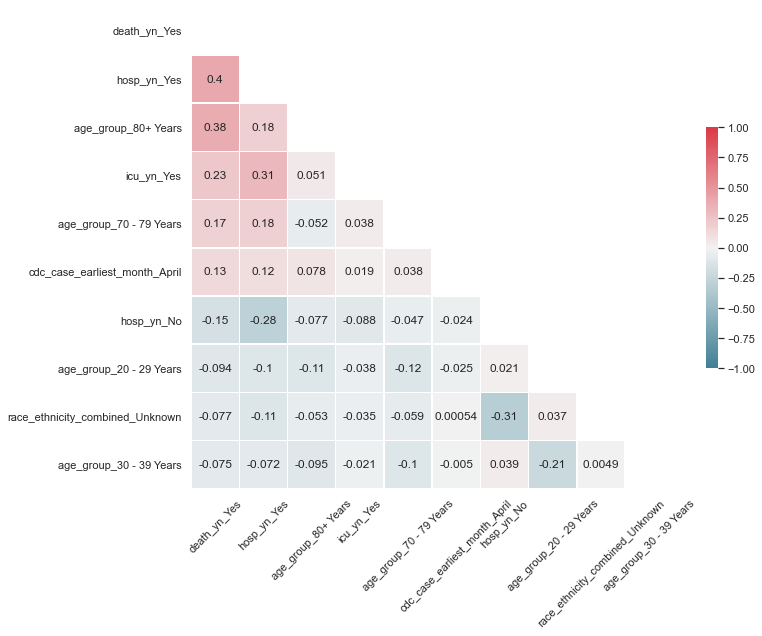

In [86]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")
continuous_columns1 = ['death_yn_Yes',
                      'hosp_yn_Yes',
                      'age_group_80+ Years',
                      'icu_yn_Yes',
                      'age_group_70 - 79 Years',
                      'cdc_case_earliest_month_April' ,
                      'hosp_yn_No',
                      'age_group_20 - 29 Years',
                      'race_ethnicity_combined_Unknown',
                      'age_group_30 - 39 Years']
# Calculate correlation of all pairs of continuous features
corr = final_df_orig_en[continuous_columns1].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig = sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)
fig = fig.get_figure()


__Results from Correlation Coefficients Analysis__
- From the above, we can see that a number of features have an impact on the target outcome (death_yn), these include:
    1. hosp_yn
        - yes values have a 0.40 corelation coefficient with death_yn_Yes
        - this is the highest coefficient seen above
    2. icu_yn
        - yes values have a 0.23 correlation coefficient with death_yn_Yes
    3. age_group
        - where age is greater than 70 we see a high correlation between age and death
        - where age is less than 50 they appear to be negatively correlated with death
    4. certain months (eg April & March)
    5. medcond_yn
        - Yes values have a 0.13 correlation coefficient with death_yn_Yes
  
- Certain features seem to be less correlated than the above values, these are:
    1. race_ethnicity_combined
    2. sex

We will take a look at these features now to ensure that they are actually not correlated with the target outcome

In [87]:
# isolate the death_yn = Yes from the dataset for future analysis
final_df_orig_death_Yes = final_df_orig.loc[final_df_orig['death_yn'] == "Yes"]

Functions to help with analysis of features wrt death=Yes

In [88]:
def feature_death_comparison(feature):
    """
    Function to create plots and statistics table
    for the given feature in comparison to the death feature
    """
    fig = sns.countplot(data=final_df_orig, y=feature, hue="death_yn")
    fig = fig.get_figure()
    plt.show()
    fig = sns.countplot(data=final_df_orig_death_Yes, y=feature, hue="death_yn") 
    fig = fig.get_figure()
    plt.show()
    # proportion of each race/ethnicity of total of deaths
    feature_deaths = final_df_orig_death_Yes[feature].value_counts(normalize=True) * 100

    # proportion of each race/ethnicity of total of all
    feature_totals = final_df_orig[feature].value_counts(normalize=True) * 100
    
    feature_comparison = pd.concat([feature_deaths.rename("Deaths by feature"), feature_totals.rename("Total by feature")], axis=1)
    feature_comparison["Difference"] = feature_comparison["Deaths by feature"] - feature_comparison["Total by feature"]
    feature_comparison["Abs_Difference"] = abs(feature_comparison["Deaths by feature"] - feature_comparison["Total by feature"])
    return feature_comparison.sort_values(by="Abs_Difference", ascending=False)

In [89]:
def summary_stats_tables(dataframe, col_type="all"):
    """
    Function to generate a summary statistics table for each feature in a dataframe
    """
    if col_type == "all":
        columns = dataframe.columns
    elif col_type == "cat":
        columns = df_1.select_dtypes(['category']).columns

    for column in columns:
        print("\n" + color.BOLD + column + color.END)
        count = 0
        t = PrettyTable(['Value', 'Proportion', 'Count'])
        for value in dataframe[column].unique():
            try:
                key = dataframe[column].value_counts(normalize=True).keys().tolist()[count]
                proportion_val = dataframe[column].value_counts(normalize=True).tolist()[count]
                count_val = dataframe[column].value_counts().tolist()[count]
                t.add_row([key, proportion_val, count_val])
                count += 1
            except:
                continue
        print(t)

In [90]:
final_df_orig["hosp_yn"].count()

9903

In [91]:
def risk_plot_analysis(feature,
                       dataframe=final_df_orig,
                       dfname="0",
                       noUnknown=False):
    #Using code from the module lab

    if noUnknown == True:
        omit = dataframe[dataframe[feature] == "Unknown"][feature].count()
        perOmit = (int)((omit / dataframe[feature].count()) * 100)
        print(f"{omit} Unknown values ommitted, {perOmit}%")
        dataframe = dataframe[dataframe[feature] != "Unknown"]

    maxDelqEver = pd.unique(dataframe["death_yn"].ravel())

    # add new column and set values to zero
    dataframe['percent'] = 0

    #print header
    print("MaxDelqEver")
    print("Index \t Count")

    # for each delinquency category
    for i in maxDelqEver:

        count = dataframe[dataframe["death_yn"] == i].count()[feature]
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = dataframe[dataframe['death_yn'] == i].index.tolist()
        for ind in index_list:
            dataframe.loc[ind, 'percent'] = count_percentage

    group = dataframe[['percent', 'death_yn',
                       feature]].groupby(['death_yn', feature]).sum()

    my_plot = group.unstack().plot(kind='bar',
                                   stacked=True,
                                   title=f"Risk of Death vs {feature}",
                                   figsize=(15, 7),
                                   grid=True)

    # add legend
    #red_patch = mpatches.Patch(color='orange', label='Good')
    #blue_patch = mpatches.Patch(color='blue', label='Bad')
    #my_plot.legend(handles=[red_patch, blue_patch], frameon = True)
    #my_plot.legend(["Good Outcome", "Bad Outcome"])

    # add gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    my_plot.set_xlabel("Death")
    my_plot.set_ylabel("% Risk")
    my_plot.set_ylim([0, 100])
    dataframe.drop(['percent'], axis = 1, inplace = True) 


In [92]:
def death_Yes_feature_value(feature, value):
    return final_df_orig_death_Yes.loc[final_df_orig_death_Yes[feature] == value]

In [93]:
def dataframe_feature_value(feature, value):
    return final_df_orig.loc[final_df_orig[feature] == value]

1. race_ethnicity_combined

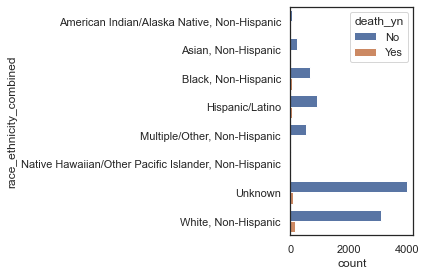

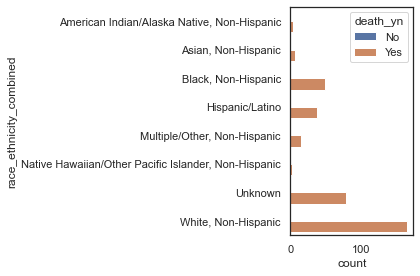

Deaths by feature  \
Unknown                                                     21.910112   
White, Non-Hispanic                                         46.348315   
Black, Non-Hispanic                                         13.483146   
Multiple/Other, Non-Hispanic                                 4.213483   
Hispanic/Latino                                             10.674157   
Asian, Non-Hispanic                                          1.966292   
Native Hawaiian/Other Pacific Islander, Non-His...           0.561798   
American Indian/Alaska Native, Non-Hispanic                  0.842697   

                                                    Total by feature  \
Unknown                                                    41.431889   
White, Non-Hispanic                                        33.181864   
Black, Non-Hispanic                                         7.098859   
Multiple/Other, Non-Hispanic                                5.513481   
Hispanic/Latino                                             9.603151   
Asian, Non-Hispanic                                         2.342724   
Native Hawaiian/Other Pacific Islander, Non-His...          0.242351   
American Indian/Alaska Native, Non-Hispanic                 0.585681   

                                                    Difference  Abs_Difference  
Unknown                                             -19.521777       19.521777  
White, Non-Hispanic                                  13.166451       13.166451  
Black, Non-Hispanic                                   6.384287        6.384287  
Multiple/Other, Non-Hispanic                         -1.299998        1.299998  
Hispanic/Latino                                       1.071007        1.071007  
Asian, Non-Hispanic                                  -0.376432        0.376432  
Native Hawaiian/Other Pacific Islander, Non-His...    0.319447        0.319447  
American Indian/Alaska Native, Non-Hispanic           0.257016        0.257016

In [94]:
feature_death_comparison("race_ethnicity_combined")

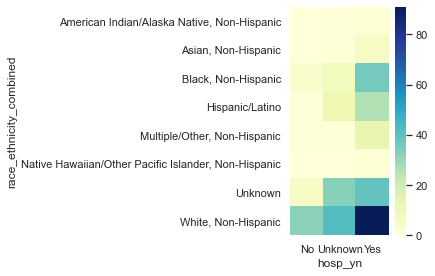

In [95]:
heatmap_death_race = pd.pivot_table(final_df_orig_death_Yes, values="death_yn", 
                     index=['race_ethnicity_combined'], 
                     columns=['hosp_yn'], aggfunc=len, fill_value=0)

heatmap_death_race = heatmap_death_race.reindex()
fig = sns.heatmap(heatmap_death_race, cmap="YlGnBu")
fig = fig.get_figure()

plt.show()

- From the above, we can see that there are three values which have major differences between the proportion of Death=Yes and the proportion of the Total dataset. These are:
    - Unknown: 
        - The difference between Total and Deaths here is 19 percentage points.
        - This may be because when a person dies, they would likely record statistics of who this person is upon death given that they will have more information about the person.
        - This hypothesis would need to be verified with the domain expert
    - White, Non-Hispanic:
        - The difference between Total and Deaths here is 13 percentage points.
        - This would likely be due to the decrease in unknown in death
    - Black, Non-Hispanic:
        - The difference between Total and Deaths here is 6 percentage points.
        - This would likely be due to the decrease in unknown in death also
        
For the above stated reasons, it is clear to see that there is very little correlation between a person's race and whether they die from Covid-19 so we will not be analysing this any further.

2. sex

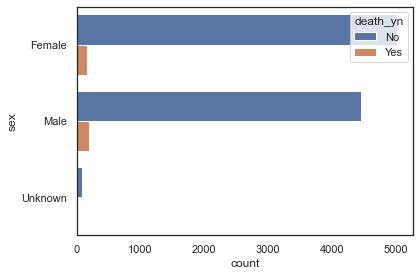

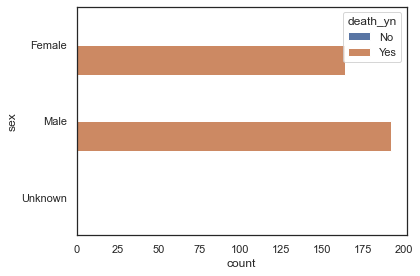

Deaths by feature  Total by feature  Difference  Abs_Difference
Male             53.932584         46.874684     7.05790         7.05790
Female           46.067416         52.337675    -6.27026         6.27026
Unknown           0.000000          0.787640    -0.78764         0.78764

In [96]:
feature_death_comparison("sex")

In [97]:
summary_stats_tables(final_df_orig[final_df_orig.sex.eq("Male")].select_dtypes(include=['category']))


current_status
+---------------------------+---------------------+-------+
|           Value           |      Proportion     | Count |
+---------------------------+---------------------+-------+
| Laboratory-confirmed case |  0.9241706161137441 |  4290 |
|       Probable Case       | 0.07582938388625593 |  352  |
+---------------------------+---------------------+-------+

sex
+-------+------------+-------+
| Value | Proportion | Count |
+-------+------------+-------+
|  Male |    1.0     |  4642 |
+-------+------------+-------+

age_group
+---------------+-----------------------+-------+
|     Value     |       Proportion      | Count |
+---------------+-----------------------+-------+
| 20 - 29 Years |  0.19215855234812582  |  892  |
| 30 - 39 Years |  0.16092201637225334  |  747  |
| 40 - 49 Years |  0.15101249461439034  |  701  |
| 50 - 59 Years |  0.14756570443774236  |  685  |
| 60 - 69 Years |   0.1059887979319259  |  492  |
| 10 - 19 Years |  0.10512710038776389  |  488  |
| 7

In [98]:
summary_stats_tables(final_df_orig[final_df_orig.sex.eq("Female")].select_dtypes(include=['category']))


current_status
+---------------------------+---------------------+-------+
|           Value           |      Proportion     | Count |
+---------------------------+---------------------+-------+
| Laboratory-confirmed case |  0.9378738182519776 |  4861 |
|       Probable Case       | 0.06212618174802238 |  322  |
+---------------------------+---------------------+-------+

sex
+--------+------------+-------+
| Value  | Proportion | Count |
+--------+------------+-------+
| Female |    1.0     |  5183 |
+--------+------------+-------+

age_group
+---------------+-----------------------+-------+
|     Value     |       Proportion      | Count |
+---------------+-----------------------+-------+
| 20 - 29 Years |  0.19062319120200655  |  988  |
| 30 - 39 Years |  0.15724483889639204  |  815  |
| 40 - 49 Years |  0.15126374686475014  |  784  |
| 50 - 59 Years |   0.1466332240015435  |  760  |
| 10 - 19 Years |  0.10380088751688211  |  538  |
| 60 - 69 Years |  0.09859154929577464  |  511  

- From the above we can see differences between the proportions of death and total
- Male make up a larger proportion of the deaths but a lesser proportion of the total, totalling a 7.2 percentage point difference
- Female make up about 6.4 percentage points less of the deaths than of the total
- This would need to be investigated further but neither gender has a large enough proportion of the deaths to be seen as a good predictor here
- Looking at the underlying statistics, it seems like men had more hospitalisation which then may have lead to more deaths
- The possible cause of the above would be the other features of the underlying sexes

### High Correlation Feature Analysis
We will now take a look at the features which we have identified to be high predictors of death in depth

1. hosp_yn

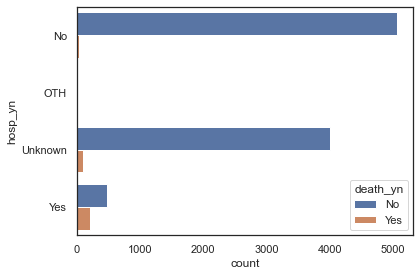

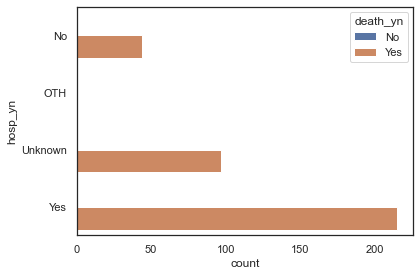

Deaths by feature  Total by feature  Difference  Abs_Difference
Yes              60.393258          6.977684   53.415575       53.415575
No               12.359551         51.590427  -39.230877       39.230877
Unknown          27.247191         41.431889  -14.184698       14.184698
OTH               0.000000          0.000000    0.000000        0.000000

In [99]:
feature_death_comparison("hosp_yn")

- Stark differences between hosp_yn = Yes and No between Deaths=Yes and total dataset would lead me to belive it is a strong predictor
- It will be useful to analyse the underlying statistics of those who are both hospitalised and died

In [100]:
final_df_orig_death_Yes_hosp_Yes = death_Yes_feature_value("hosp_yn", "Yes")

# makes up only 2.2% of the total rows
final_df_orig_death_Yes_hosp_Yes.shape

(215, 15)

In [101]:
summary_stats_tables(final_df_orig_death_Yes_hosp_Yes, col_type="cat")


current_status
+---------------------------+---------------------+-------+
|           Value           |      Proportion     | Count |
+---------------------------+---------------------+-------+
| Laboratory-confirmed case |  0.9441860465116279 |  203  |
|       Probable Case       | 0.05581395348837209 |   12  |
+---------------------------+---------------------+-------+

sex
+--------+--------------------+-------+
| Value  |     Proportion     | Count |
+--------+--------------------+-------+
|  Male  | 0.5953488372093023 |  128  |
| Female | 0.4046511627906977 |   87  |
+--------+--------------------+-------+

age_group
+---------------+----------------------+-------+
|     Value     |      Proportion      | Count |
+---------------+----------------------+-------+
|   80+ Years   | 0.34418604651162793  |   74  |
| 70 - 79 Years | 0.28837209302325584  |   62  |
| 60 - 69 Years | 0.20930232558139536  |   45  |
| 50 - 59 Years | 0.11162790697674418  |   24  |
| 40 - 49 Years | 0.03255

Some notable statistics:
- Male makes up about 60% of the total deaths who were hospitalised
- age_groups over 60 make up 73% of deaths
- icu_yn is unknown for 75% of the deaths, but for the remaining 39 deaths, icu_yn = Yes makes up 76%
- medcond_yn is unknown for 67% of the deaths, but for the remaining 68, medcond_yn = Yes makes up 97%

We will further analyse this using risk plots

4103 Unknown values ommitted, 41%
MaxDelqEver
Index 	 Count
No 	 5541
Yes 	 259


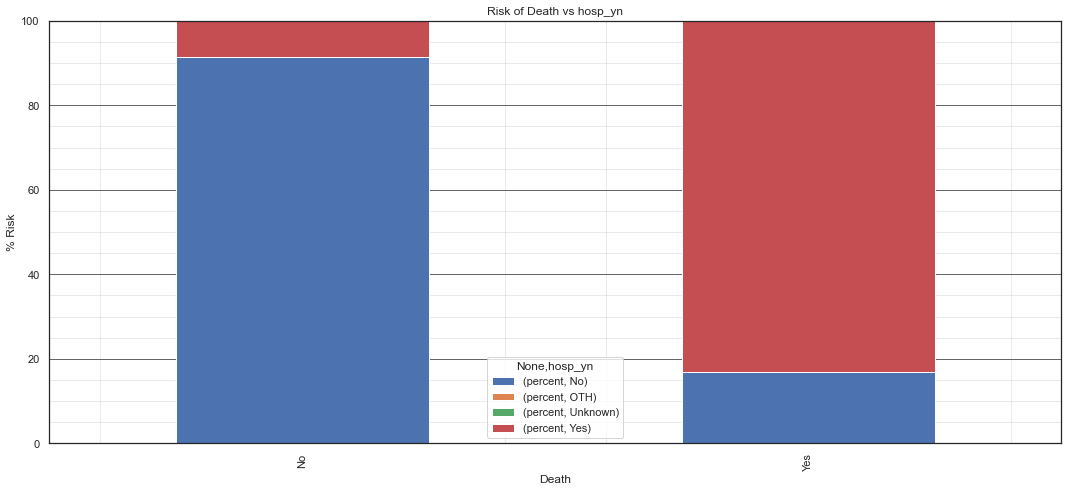

In [102]:
risk_plot_analysis("hosp_yn", noUnknown=True)

Clear risk of death can be seen when hosp_yn = Yes above

1 Unknown values ommitted, 0%
MaxDelqEver
Index 	 Count
Yes 	 215
No 	 475
0 Unknown values ommitted, 0%
MaxDelqEver
Index 	 Count
Yes 	 215
No 	 476
489 Unknown values ommitted, 70%
MaxDelqEver
Index 	 Count
No 	 150
Yes 	 52


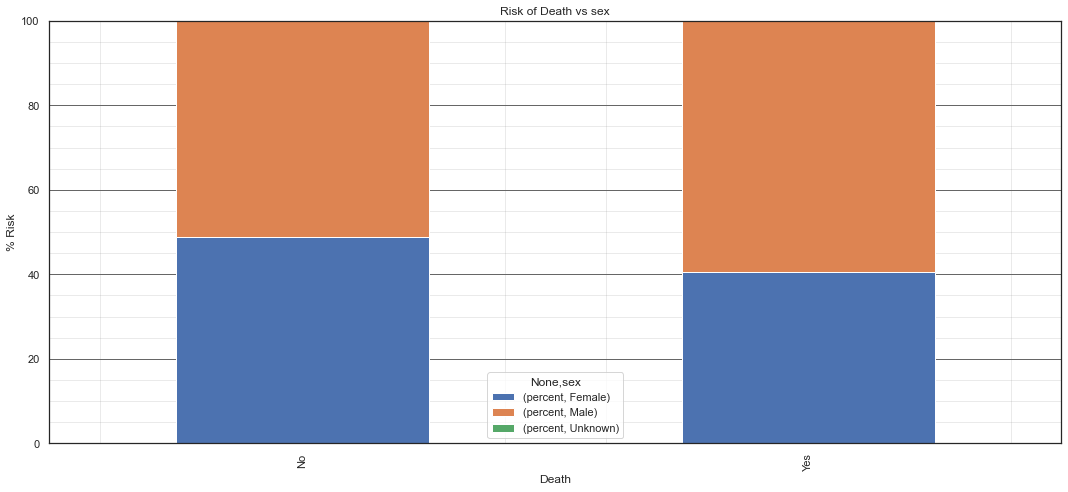

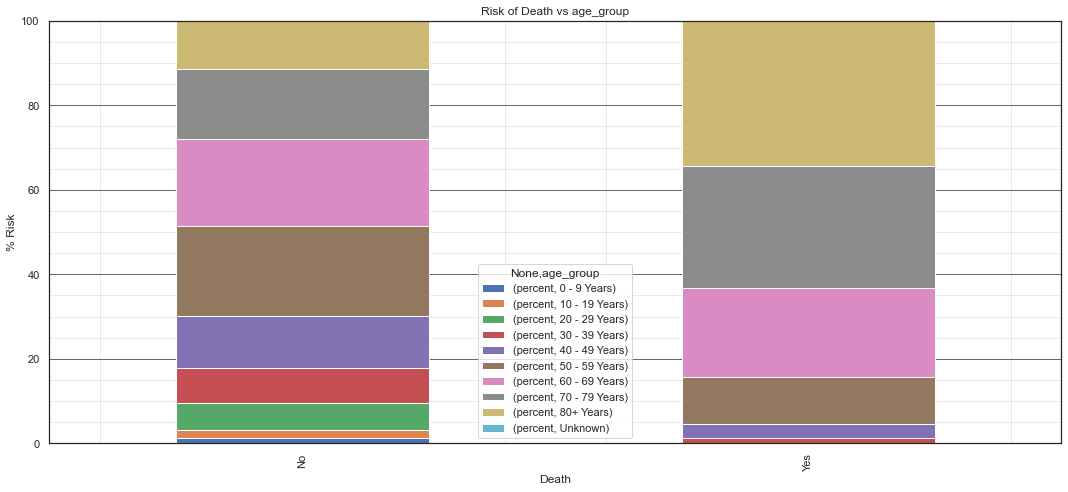

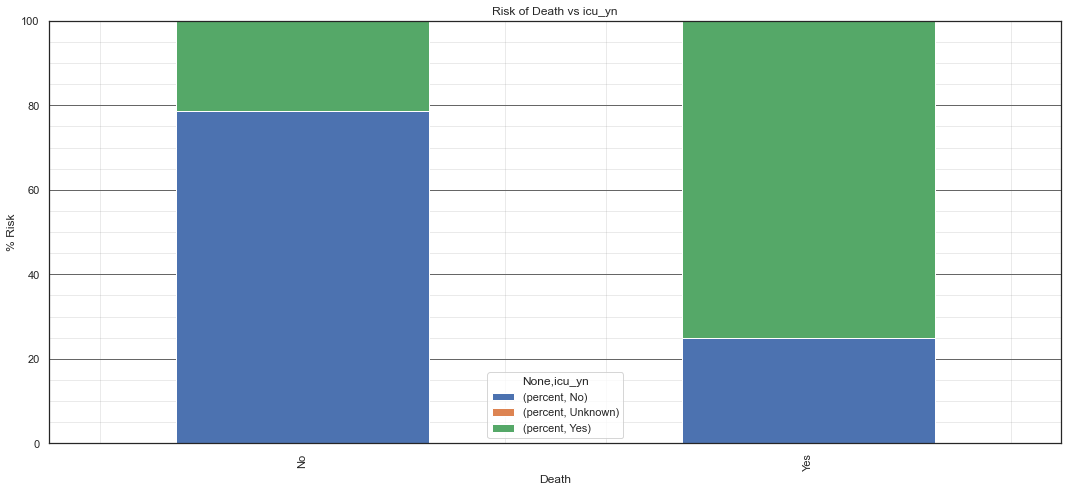

In [103]:
# The following plots represent those who were hospitalised only (ie hosp_yn = Yes)
final_df_orig_hosp_Yes = dataframe_feature_value("hosp_yn", "Yes")
risk_plot_analysis("sex", final_df_orig_hosp_Yes, dfname="final_df_orig_hosp_Yes", noUnknown=True)
risk_plot_analysis("age_group", final_df_orig_hosp_Yes, dfname="final_df_orig_hosp_Yes", noUnknown=True)
risk_plot_analysis("icu_yn", final_df_orig_hosp_Yes, dfname="final_df_orig_hosp_Yes", noUnknown=True)

From the above, we learn the following about the hosp_yn feature:
- Those who were hospitalised had a 60% risk of death
- Those were not hospitalised had a comparable 12.67% risk of death, much lower than the above
- Of those who were both hospitalised and died:
    - 60% were Male
    - 85% were over the age of 60
    - Only ~20% were in the ICU, although this is within 25% of known values - so the proportion of hospitalised and ICU patients was about 80% (given known values)

2. icu_yn

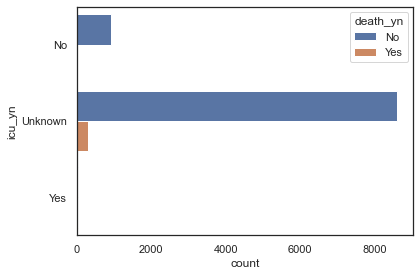

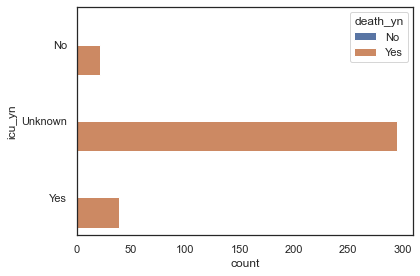

Deaths by feature  Total by feature  Difference  Abs_Difference
Yes              10.955056          0.716954   10.238102       10.238102
Unknown          82.865169         89.801070   -6.935902        6.935902
No                6.179775          9.481975   -3.302200        3.302200

In [104]:
feature_death_comparison("icu_yn")

In [105]:
final_df_orig_death_Yes_icu_Yes = death_Yes_feature_value("icu_yn", "Yes")

# makes up only 0.4% of the total rows
final_df_orig_death_Yes_icu_Yes.shape

(39, 15)

In [106]:
summary_stats_tables(final_df_orig_death_Yes_icu_Yes, col_type="cat")


current_status
+---------------------------+---------------------+-------+
|           Value           |      Proportion     | Count |
+---------------------------+---------------------+-------+
| Laboratory-confirmed case |  0.9743589743589743 |   38  |
|       Probable Case       | 0.02564102564102564 |   1   |
+---------------------------+---------------------+-------+

sex
+--------+--------------------+-------+
| Value  |     Proportion     | Count |
+--------+--------------------+-------+
|  Male  | 0.7435897435897436 |   29  |
| Female | 0.2564102564102564 |   10  |
+--------+--------------------+-------+

age_group
+---------------+---------------------+-------+
|     Value     |      Proportion     | Count |
+---------------+---------------------+-------+
|   80+ Years   | 0.28205128205128205 |   11  |
| 60 - 69 Years | 0.20512820512820512 |   8   |
| 70 - 79 Years | 0.20512820512820512 |   8   |
| 40 - 49 Years | 0.15384615384615385 |   6   |
| 50 - 59 Years | 0.102564102564

8893 Unknown values ommitted, 89%
MaxDelqEver
Index 	 Count
No 	 949
Yes 	 61


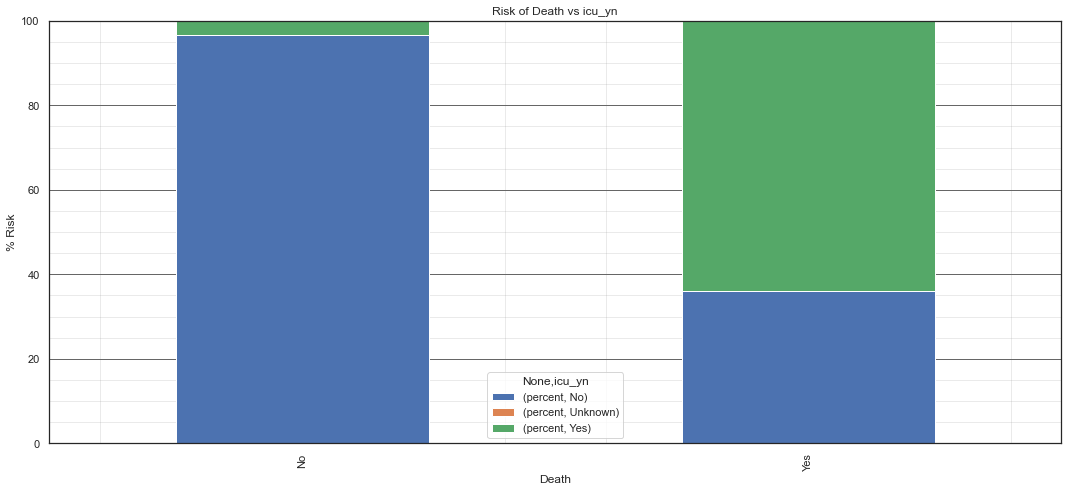

In [107]:
risk_plot_analysis("icu_yn", noUnknown=True)

0 Unknown values ommitted, 0%
MaxDelqEver
Index 	 Count
No 	 32
Yes 	 39
0 Unknown values ommitted, 0%
MaxDelqEver
Index 	 Count
No 	 32
Yes 	 39
32 Unknown values ommitted, 45%
MaxDelqEver
Index 	 Count
No 	 17
Yes 	 22


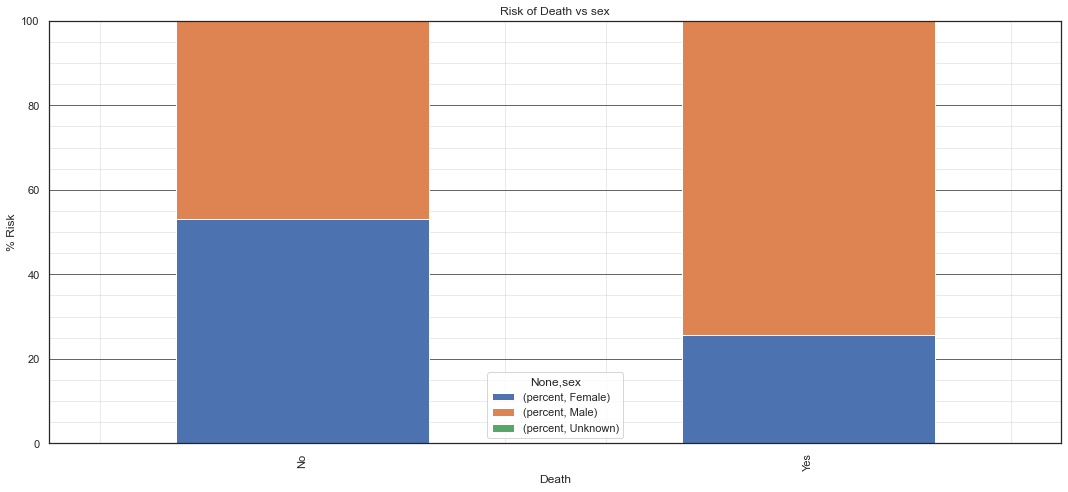

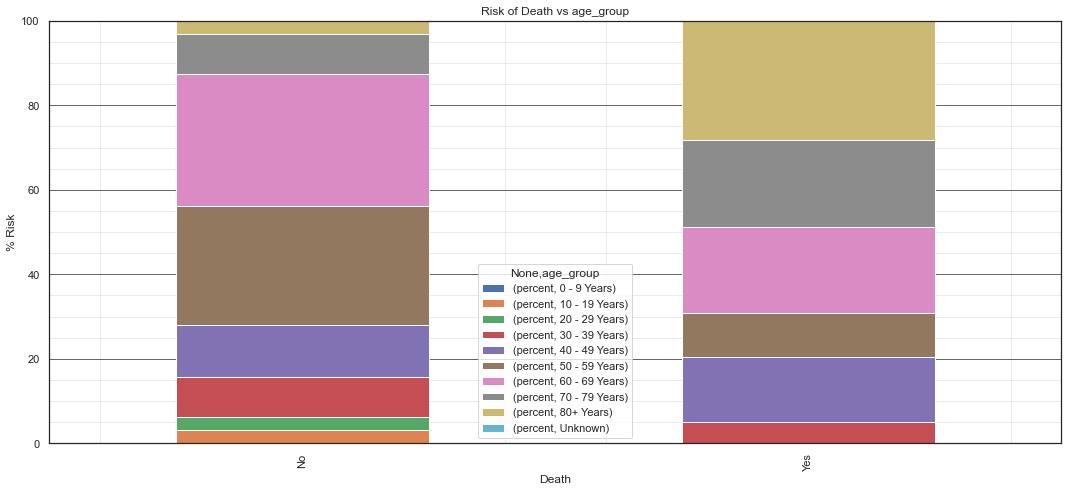

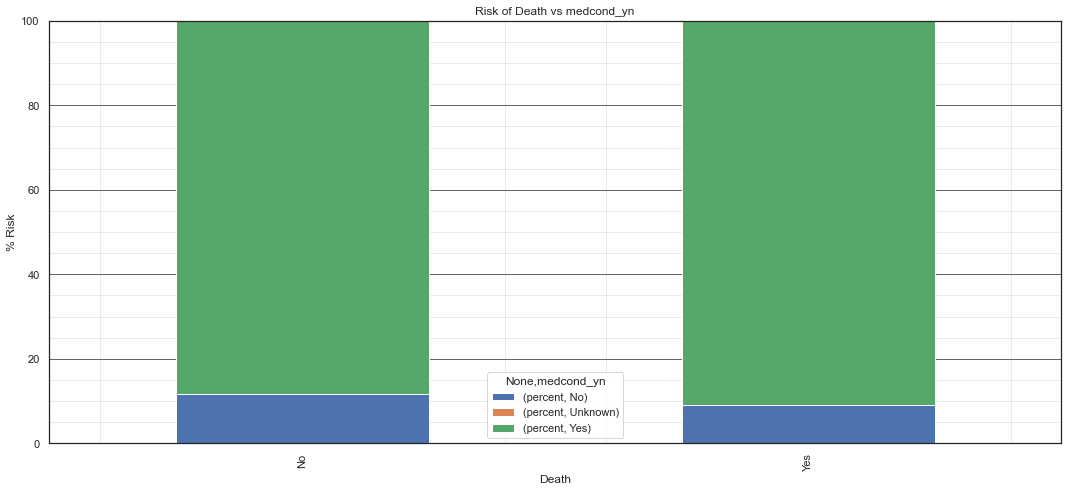

In [108]:
# The following plots represent those who were ICU only (ie icu_yn = Yes)
final_df_orig_icu_Yes = dataframe_feature_value("icu_yn", "Yes")
risk_plot_analysis("sex", final_df_orig_icu_Yes, dfname="final_df_orig_icu_Yes", noUnknown=True)
risk_plot_analysis("age_group", final_df_orig_icu_Yes, dfname="final_df_orig_icu_Yes", noUnknown=True)
risk_plot_analysis("medcond_yn", final_df_orig_icu_Yes, dfname="final_df_orig_icu_Yes", noUnknown=True)

From the above, we learn the following about the icu_yn feature:
- Those who were in the ICU had a 60% risk of death
- Those were not hospitalised had a comparable 12.67% risk of death, much lower than the above
- Of those who were both in the ICU and died:
    - 74% were Male
    - 81% were over the age of 60
    - Only ~52% had a medical condition

3. age_group

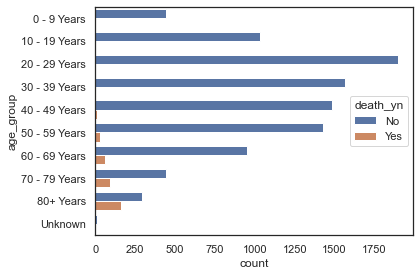

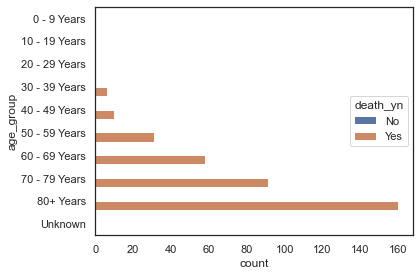

Deaths by feature  Total by feature  Difference  Abs_Difference
80+ Years              44.943820          4.533980   40.409841       40.409841
70 - 79 Years          25.561798          5.382207   20.179590       20.179590
20 - 29 Years           0.000000         19.176007  -19.176007       19.176007
30 - 39 Years           1.685393         15.873978  -14.188584       14.188584
40 - 49 Years           2.808989         15.116631  -12.307643       12.307643
10 - 19 Years           0.000000         10.421085  -10.421085       10.421085
60 - 69 Years          16.292135         10.198930    6.093205        6.093205
50 - 59 Years           8.707865         14.743007   -6.035142        6.035142
0 - 9 Years             0.000000          4.463294   -4.463294        4.463294
Unknown                 0.000000          0.090882   -0.090882        0.090882

In [109]:
feature_death_comparison("age_group")

In [110]:
final_df_orig_death_Yes_age_80 = death_Yes_feature_value("age_group", "80+ Years")

# makes up only 1.6% of the total rows
final_df_orig_death_Yes_age_80.shape

(160, 15)

In [111]:
summary_stats_tables(final_df_orig_death_Yes_age_80, col_type="cat")


current_status
+---------------------------+------------+-------+
|           Value           | Proportion | Count |
+---------------------------+------------+-------+
| Laboratory-confirmed case |   0.9375   |  150  |
|       Probable Case       |   0.0625   |   10  |
+---------------------------+------------+-------+

sex
+--------+------------+-------+
| Value  | Proportion | Count |
+--------+------------+-------+
| Female |   0.5375   |   86  |
|  Male  |   0.4625   |   74  |
+--------+------------+-------+

age_group
+-----------+------------+-------+
|   Value   | Proportion | Count |
+-----------+------------+-------+
| 80+ Years |    1.0     |  160  |
+-----------+------------+-------+

race_ethnicity_combined
+---------------------------------------------+------------+-------+
|                    Value                    | Proportion | Count |
+---------------------------------------------+------------+-------+
|             White, Non-Hispanic             |  0.56875   |   

MaxDelqEver
Index 	 Count
No 	 9547
Yes 	 356


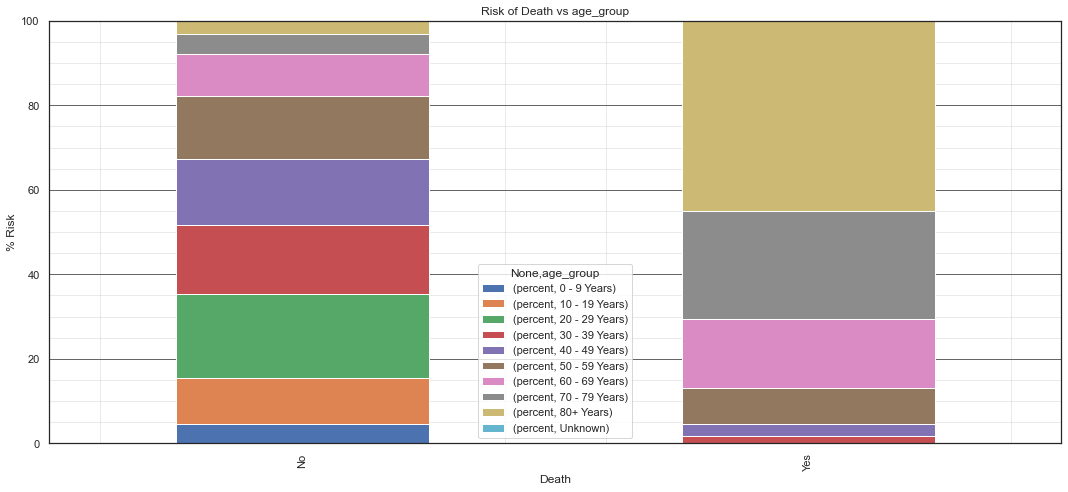

In [112]:
risk_plot_analysis("age_group")

1 Unknown values ommitted, 0%
MaxDelqEver
Index 	 Count
No 	 288
Yes 	 160
169 Unknown values ommitted, 37%
MaxDelqEver
Index 	 Count
No 	 179
Yes 	 101
345 Unknown values ommitted, 76%
MaxDelqEver
Index 	 Count
No 	 57
Yes 	 47


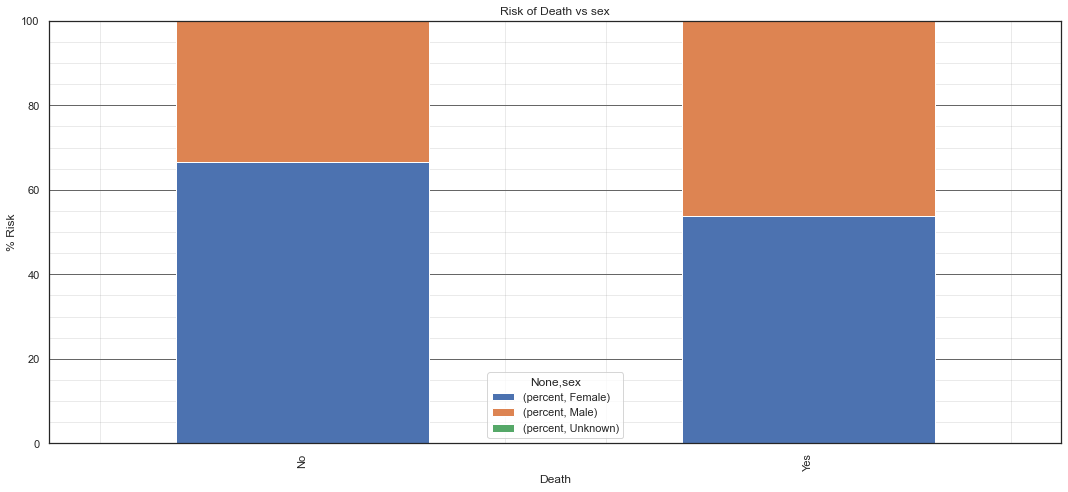

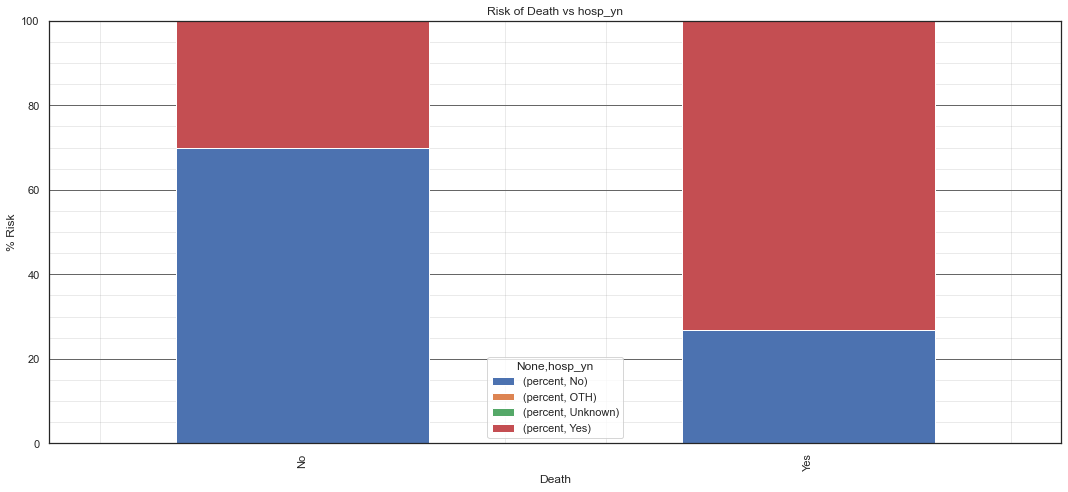

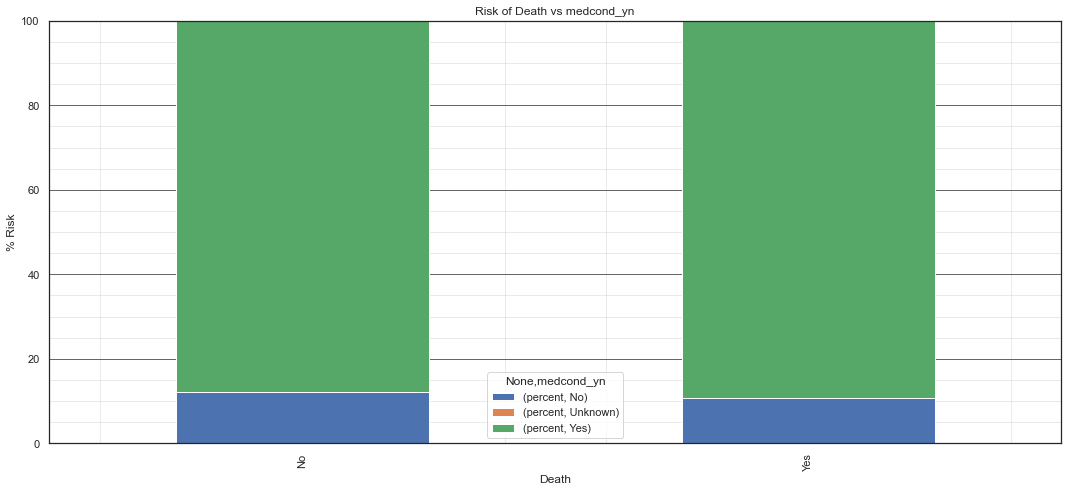

In [113]:
# The following plots represent those who were 80+
final_df_orig_age_80 = dataframe_feature_value("age_group", "80+ Years")
risk_plot_analysis("sex", final_df_orig_age_80, dfname="final_df_orig_age_80", noUnknown=True)
risk_plot_analysis("hosp_yn", final_df_orig_age_80, dfname="final_df_orig_age_80", noUnknown=True)
risk_plot_analysis("medcond_yn", final_df_orig_age_80, dfname="final_df_orig_age_80", noUnknown=True)

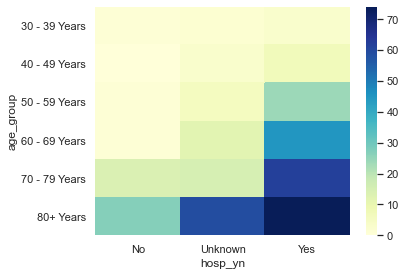

In [114]:

heatmap_death_age = pd.pivot_table(final_df_orig_death_Yes, values="death_yn", 
                     index=['age_group'], 
                     columns=['hosp_yn'], aggfunc=len, fill_value=0)

heatmap_death_age = heatmap_death_age.reindex()
fig = sns.heatmap(heatmap_death_age, cmap="YlGnBu")
fig = fig.get_figure()
plt.show()

From the above, we learn the following about the age_group feature:
- 45% of those who died were aged above 80
- ~40% of those who died were aged between 60 and 80
- Of those aged above 80 who died:
    - 55% were female
    - 55% were known to be hospitalised
    - 25% were known to have a medical condition

4. Looking at days and months

In [115]:
# orderings of days and months for graphs
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_order = ['February','March','April',  'May', 'June',  'July','August', 'September', 'October','November', 'December',  'January']

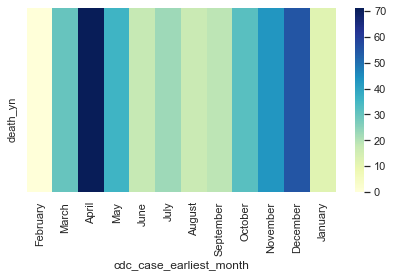

In [116]:
# Heatmap by Month
heatmap_death = pd.pivot_table(final_df_orig_death_Yes, values="death_yn",  
                     columns=['cdc_case_earliest_month'], aggfunc=len, fill_value=0)
heatmap_death = heatmap_death.reindex(columns=month_order)
fig = sns.heatmap(heatmap_death, cmap="YlGnBu")
fig = fig.get_figure()
plt.show()

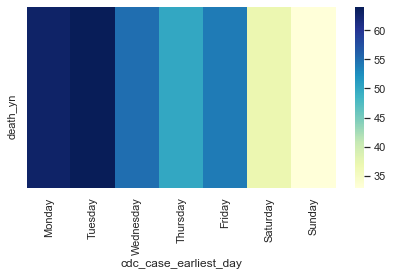

In [117]:
# Heatmap by Day of the Week
heatmap_death = pd.pivot_table(final_df_orig_death_Yes, values="death_yn",  
                     columns=['cdc_case_earliest_day'], aggfunc=len, fill_value=0)
heatmap_death = heatmap_death.reindex(columns=day_order)
fig = sns.heatmap(heatmap_death, cmap="YlGnBu")
fig = fig.get_figure()
plt.show()

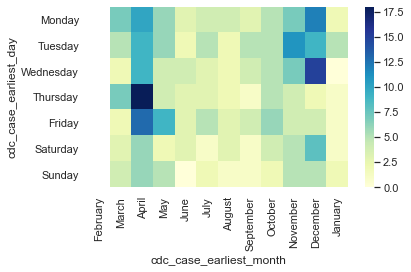

In [118]:
heatmap_death = pd.pivot_table(final_df_orig_death_Yes, values="death_yn", 
                     index=['cdc_case_earliest_day'], 
                     columns=['cdc_case_earliest_month'], aggfunc=len, fill_value=0)
heatmap_death = heatmap_death.reindex(index=day_order, columns=month_order)
fig = sns.heatmap(heatmap_death, cmap="YlGnBu")
fig = fig.get_figure()
plt.show()

- Here we can see clusters of deaths in and around April and December
- The most frequest day to die in April was Thursday while the most frequest day to die in December was Wednesday
    - Both of these are midweek

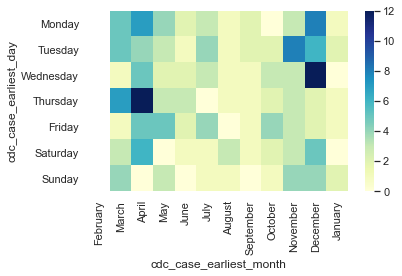

In [119]:
# Heatmap of hospitalisation = yes death = Yes
heatmap_death = pd.pivot_table(final_df_orig_death_Yes_hosp_Yes, values="hosp_yn", 
                     index=['cdc_case_earliest_day'], 
                     columns=['cdc_case_earliest_month'], aggfunc=len, fill_value=0)

heatmap_death = heatmap_death.reindex(index=day_order, columns=month_order)
fig = sns.heatmap(heatmap_death, cmap="YlGnBu")
fig = fig.get_figure()
plt.show()

- Of those who were hospitalised and died the distribution looks very similar to that above

5. medcond_yn

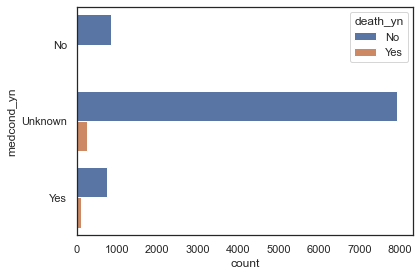

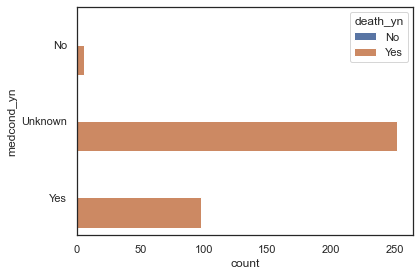

Deaths by feature  Total by feature  Difference  Abs_Difference
Yes              27.528090          8.694335   18.833755       18.833755
Unknown          70.786517         82.682016  -11.895499       11.895499
No                1.685393          8.623649   -6.938256        6.938256

In [120]:
feature_death_comparison("medcond_yn")

- Here we can see that there is a large difference between the deaths=Yes and total sets
- There is a 19 percentage point difference between medcond_yn=Yes in total and deaths
- This is accounted for by the decrease in medcond_yn=Unknown and No in deaths=Yes than total
- One possible reason of the above is that it may not be likely to collect medical condition information unless the person is ill or hospitalised from Covid
- The large increase of Yes values would leave me to believe that there may be some correlation between this and death and would need further investigation

### Interactive Plots using Plotly
Original Code for these plots from [here](https://www.kaggle.com/accountstatus/covid-data-analysis). Various modifications have been made to better visualise the data sample here.

In [121]:
age_order = ['Unknown', '0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years', '60 - 69 Years','70 - 79 Years', '80+ Years'][::-1]

1. Density Contour Plot of Deaths by age_group and month of death

In [122]:
month_orders_dict = {"cdc_case_earliest_month":month_order, "age_group":age_order}

def show_cont_1():
    fig_contour = px.density_contour(final_df_orig_death_Yes, title="Deaths by Age Group and Months", x="cdc_case_earliest_month", y="age_group",category_orders=month_orders_dict)
    fig_contour.update_traces(contours_coloring="fill", contours_showlabels = True)
    fig_contour.write_html("charts/interactive/interactive_contour_age_month.html")
    fig_contour.show()

# this is commented out because it uses a lot of memory, uncomment to see chart
#show_cont_1()

- Here we can see clusters forming at the older age groups (ie over the age of 60)
- Clusters of deaths can be seen happening within both April & December as we've previously stated above

2. Density Contour Plot of Deaths by week and month of death

In [123]:
age_order = ['Missing', '0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years', '60 - 69 Years','70 - 79 Years', '80+ Years'][::-1]

month_day_orders_dict = {"cdc_case_earliest_month":month_order, "cdc_case_earliest_day":day_order}

def show_cont_2():
    fig_contour = px.density_contour(final_df_orig_death_Yes, title="Deaths by Day of Week and Month", x="cdc_case_earliest_month", y="cdc_case_earliest_day",category_orders=month_day_orders_dict)
    fig_contour.update_traces(contours_coloring="fill", contours_showlabels = True)
    fig_contour.write_html("charts/interactive/interactive_contour_day_month.html")
    fig_contour.show()
  
# this is commented out because it uses a lot of memory, uncomment to see chart
#show_cont_2()

- From the above, we can see clusters around April & December as stated previously above

3. Sunburst Plot of Deaths by Hospitalisation, ICU, Age Group and Month of death

In [124]:
def show_sunburst():
    grouped_data_1=final_df_orig_death_Yes.groupby(['hosp_yn','icu_yn', 'age_group', 'cdc_case_earliest_month']).count()
    df_grouped_1=pd.DataFrame()
    df_grouped_1['hosp_yn']=np.array(list(grouped_data_1.index))[:,0]
    df_grouped_1['icu_yn']=np.array(list(grouped_data_1.index))[:,1]
    df_grouped_1['age_group']=np.array(list(grouped_data_1.index))[:,2]
    df_grouped_1['cdc_case_earliest_month']=np.array(list(grouped_data_1.index))[:,3]
    df_grouped_1['Count']=grouped_data_1['cdc_case_earliest_dt'].values
    fig = px.sunburst(df_grouped_1, path=['hosp_yn', 'icu_yn', 'age_group', 'cdc_case_earliest_month'], values='Count', title="Deaths grouped by Hospitalisation, ICU, Age Group and Month")
    fig.write_html("charts/interactive/interactive_sunburst_by_features.html")
    fig.show()

# this is commented out because it uses a lot of memory, uncomment to see chart
#show_sunburst()

- The sunburst chart above lets you interact with the data more to see what proportions each value of feature makes up
- From the inside out we represent each of the features which most strongly affect the data:
    - Ordering starting from the centre: hosp_yn, icu_yn, age_group, cdc_case_earliest_month

4. Parallel Categories plot of the whole dataframe  
These plots use up a lot of memory so are commented out but can be run by uncommenting or going to the interactive folder in the charts folder

In [125]:
# parallel categories

#fig = px.parallel_categories(final_df_orig)
#fig.write_html("charts/interactive/interactive_parallel_all.html")
#fig.show()

In [126]:
#fig = px.parallel_categories(final_df_orig_death_Yes)
#fig.write_html("charts/interactive/interactive_parallel_death.html")
#fig.show()

### - Discuss your findings from the plots above. Do you find any features or feature combinations that are indicative of the target outcome (i.e., churn)? Explain in plain words (a short paragraph) the story of your findings so far.

- Categorical vs Categorical
    - The dataset consisted moslty of categorical features, with datetime features also
    - The analysis above shows that the following features strongly affect the target outcome (death_yn = Yes):
        - Hospitalisation: Among those who died 83% were hospitalised. This is therefore a strong predictor of death in this dataset
        - ICU: Among those who died, 65% were in the ICU 
        - age_group: This is a strong predictor of death, older age groups make up a large proportion of the total deaths. i.e. those over 60 made up ~85% of all deaths recorded here.
        - Date/Time of Death: We see clusters of deaths in both April and December, and midweek tended to be more common for deaths (Wednesday and Thursday)
- Continuous vs Categorical & Continuous vs Continuous
    - The dataset did not any explicit continuous features, although it did contain datetime features which have been analysed as categorical (e.g. by Day of the Week or Month above)
    - Below I will be adding some continous features to the dataframe and analysing them

# (4). Transform, extend or combine the existing features to create a few new features (at least 3)

Aim to better capture the problem domain and the target outcome. Justify the steps and choices you are making. Add these features to your clean dataset and save it as a CSV file with a self explanatory name. 

#### Ideas for Further Analysis:
1. Use encoded dataset & added month and day features from above to do more statistical analysis
2. Create moving averages of counts of certain variables
3. Calculate the time interval between report date of the case and start of onset of symptoms

## ADDING NEW FEATURES

at-risk = where medical condition is true and age is above 60
young-old = regroup the age column into a binary category: either young or old
month and day were added in part 2 and this has been left here so it can be analysed.
number of cases per month = as suggested by Prof Ifrim in lab

# Covid Cases Per Month

In [127]:
#3 count of cases per month
final_df_orig['case_per_month'] = df_1.groupby([df_1.cdc_case_earliest_dt.dt.year, df_1.cdc_case_earliest_dt.dt.month])['cdc_case_earliest_dt'].transform('size')

In [128]:
final_df_orig['case_per_month'] 

0        255
1       2457
2        625
3        799
4       1178
        ... 
9995     255
9996    2457
9997     799
9998     899
9999     799
Name: case_per_month, Length: 9903, dtype: int64

# Covid Cases Per Day

In [129]:
final_df_orig['case_per_day'] = df_1.groupby([df_1.cdc_case_earliest_dt.dt.year, df_1.cdc_case_earliest_dt.dt.month, df_1.cdc_case_earliest_dt.dt.day])['cdc_case_earliest_dt'].transform('size')

In [130]:
final_df_orig['case_per_day'] 

0       23
1       80
2       32
3       22
4       92
        ..
9995    11
9996    30
9997    36
9998    43
9999    18
Name: case_per_day, Length: 9903, dtype: int64

# Number of Days between report date and onset date

In [131]:
final_df_orig["onset_days"] = (final_df_orig["onset_dt"] - final_df_orig["cdc_case_earliest_dt"]) / pd.Timedelta(days=1)

In [132]:
final_df_orig.dtypes

cdc_case_earliest_dt       datetime64[ns]
onset_dt                   datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                         category
medcond_yn                       category
cdc_case_earliest_day            category
onset_day                        category
cdc_case_earliest_month          category
onset_month                      category
onset_dt_missing                    int32
case_per_month                      int64
case_per_day                        int64
onset_days                        float64
dtype: object

# At Risk - Older than 59 & have medical condition

In [133]:
#1 at risk
def at_risk(s):
    if (((s["age_group"] == "80+ Years") | (s["age_group"] == "70 - 79 Years") | (s["age_group"] == "60 - 69 Years")) & (s["medcond_yn"] == "Yes")):
        return "Yes"
    else:
        return "No"

In [134]:
final_df_orig['at_risk'] = final_df_orig.apply(at_risk, axis=1)

In [135]:
final_df_orig['at_risk']

0        No
1        No
2       Yes
3        No
4        No
       ... 
9995     No
9996     No
9997     No
9998     No
9999     No
Name: at_risk, Length: 9903, dtype: object

# old_aged: Older than 59 = Yes

In [136]:
#2 young_old
def young_old(s):
    if ((s["age_group"] == "80+ Years") | (s["age_group"] == "70 - 79 Years") | (s["age_group"] == "60 - 69 Years")):
        return "Yes"
    else:
        return "No"

In [137]:
final_df_orig['old_aged'] = final_df_orig.apply(young_old, axis=1)

In [138]:
final_df_orig['old_aged']

0        No
1        No
2       Yes
3       Yes
4        No
       ... 
9995     No
9996    Yes
9997     No
9998     No
9999     No
Name: old_aged, Length: 9903, dtype: object

In [139]:
final_df_orig["onset_days"] = (final_df_orig["onset_dt"] - final_df_orig["cdc_case_earliest_dt"]) / pd.Timedelta(days=1)

In [140]:
final_df_orig

cdc_case_earliest_dt                      onset_dt  \
0              2020-03-30 2020-03-30 00:00:00.000000000   
1              2020-12-11 2020-12-11 07:28:59.373645853   
2              2020-08-19 2020-08-19 07:28:59.373645853   
3              2020-10-24 2020-10-24 00:00:00.000000000   
4              2021-01-11 2021-01-11 07:28:59.373645853   
...                   ...                           ...   
9995           2020-03-21 2020-03-21 07:28:59.373645853   
9996           2020-12-25 2020-12-25 00:00:00.000000000   
9997           2020-10-19 2020-10-19 00:00:00.000000000   
9998           2020-07-13 2020-07-13 07:28:59.373645853   
9999           2020-10-17 2020-10-17 00:00:00.000000000   

                 current_status     sex      age_group  \
0     Laboratory-confirmed case  Female  30 - 39 Years   
1     Laboratory-confirmed case    Male  50 - 59 Years   
2     Laboratory-confirmed case    Male  70 - 79 Years   
3     Laboratory-confirmed case    Male  70 - 79 Years   
4     Laboratory-confirmed case    Male  10 - 19 Years   
...                         ...     ...            ...   
9995  Laboratory-confirmed case  Female  40 - 49 Years   
9996  Laboratory-confirmed case    Male  60 - 69 Years   
9997  Laboratory-confirmed case  Female  30 - 39 Years   
9998  Laboratory-confirmed case    Male  30 - 39 Years   
9999  Laboratory-confirmed case  Female  20 - 29 Years   

           race_ethnicity_combined  hosp_yn   icu_yn death_yn medcond_yn  \
0              Black, Non-Hispanic       No  Unknown       No    Unknown   
1     Multiple/Other, Non-Hispanic  Unknown  Unknown       No    Unknown   
2              White, Non-Hispanic       No  Unknown       No        Yes   
3                          Unknown       No  Unknown       No    Unknown   
4              White, Non-Hispanic       No  Unknown       No    Unknown   
...                            ...      ...      ...      ...        ...   
9995                       Unknown       No  Unknown       No        Yes   
9996           White, Non-Hispanic       No  Unknown       No    Unknown   
9997               Hispanic/Latino       No  Unknown       No    Unknown   
9998               Hispanic/Latino  Unknown  Unknown       No    Unknown   
9999           Black, Non-Hispanic  Unknown  Unknown       No         No   

     cdc_case_earliest_day  onset_day cdc_case_earliest_month onset_month  \
0                   Monday     Monday                   March       March   
1                   Friday     Friday                December    December   
2                Wednesday  Wednesday                  August      August   
3                 Saturday   Saturday                 October     October   
4                   Monday     Monday                 January     January   
...                    ...        ...                     ...         ...   
9995              Saturday   Saturday                   March       March   
9996                Friday     Friday                December    December   
9997                Monday     Monday                 October     October   
9998                Monday     Monday                    July        July   
9999              Saturday   Saturday                 October     October   

      onset_dt_missing  case_per_month  case_per_day  onset_days at_risk  \
0                    0             255            23    0.000000      No   
1                    1            2457            80    0.311798      No   
2                    1             625            32    0.311798     Yes   
3                    0             799            22    0.000000      No   
4                    1            1178            92    0.311798      No   
...                ...             ...           ...         ...     ...   
9995                 1             255            11    0.311798      No   
9996                 0            2457            30    0.000000      No   
9997                 0             799            36    0.000000      No   
9

# Number of days since start and end dates

In [141]:
df_for_part_5 = final_df_orig.copy()

In [142]:
import datetime
df_for_part_5.cdc_case_earliest_duration =  df_for_part_5.cdc_case_earliest_dt.apply(datetime.datetime.toordinal)
df_for_part_5.cdc_case_earliest_duration

0       737514
1       737770
2       737656
3       737722
4       737801
         ...  
9995    737505
9996    737784
9997    737717
9998    737619
9999    737715
Name: cdc_case_earliest_dt, Length: 9903, dtype: int64

In [143]:
df_for_part_5.onset_duration =  df_for_part_5.onset_dt.apply(datetime.datetime.toordinal)
df_for_part_5.onset_duration

0       737514
1       737770
2       737656
3       737722
4       737801
         ...  
9995    737505
9996    737784
9997    737717
9998    737619
9999    737715
Name: onset_dt, Length: 9903, dtype: int64

In [144]:
final_df_orig["time_since_start"] = ((final_df_orig["cdc_case_earliest_dt"] - min(final_df_orig["cdc_case_earliest_dt"]))/(max(final_df_orig["cdc_case_earliest_dt"]) - min(final_df_orig["cdc_case_earliest_dt"])))

In [145]:
final_df_orig["time_since_start"] = ((final_df_orig["cdc_case_earliest_dt"] - min(final_df_orig["cdc_case_earliest_dt"]))/(max(final_df_orig["cdc_case_earliest_dt"]) - min(final_df_orig["cdc_case_earliest_dt"])))

In [146]:
max(final_df_orig["time_since_start"])

1.0

In [147]:
min(final_df_orig["time_since_start"])

0.0

In [148]:
final_df_orig["time_since_start"]

0       0.227513
1       0.904762
2       0.603175
3       0.777778
4       0.986772
          ...   
9995    0.203704
9996    0.941799
9997    0.764550
9998    0.505291
9999    0.759259
Name: time_since_start, Length: 9903, dtype: float64

# Encode the Dataframe to study the correlation with the target feature

In [149]:
# encode dataset
final_df_orig_encoded = pd.get_dummies(final_df_orig)

In [150]:
# show month and day columns
new_features = []
for col in final_df_orig_encoded.columns:
    if "time_since_start" in col or "cdc_case_earliest_day" in col or "cdc_case_earliest_month" in col or "onset_day" in col or "onset_month" in col or "case_per_day" in col or "case_per_month" in col or "onset_days" in col:
        new_features.append(col)
new_features.append("death_yn_Yes")

In [151]:
# look at correlations for just new_features
final_df_orig_encoded[new_features].corr()["death_yn_Yes"].sort_values().head(10) 

time_since_start                   -0.129503
case_per_day                       -0.082886
case_per_month                     -0.081153
onset_month_January                -0.050848
cdc_case_earliest_month_January    -0.050682
cdc_case_earliest_month_December   -0.041102
onset_month_December               -0.040983
onset_month_November               -0.023982
cdc_case_earliest_month_November   -0.023936
onset_month_July                   -0.017297
Name: death_yn_Yes, dtype: float64

In [152]:
# look at all features correlations
final_df_orig_encoded.corr()["death_yn_Yes"].sort_values().head(10) 

death_yn_No                       -1.000000
old_aged_No                       -0.321226
at_risk_No                        -0.218535
hosp_yn_No                        -0.151590
time_since_start                  -0.129503
age_group_20 - 29 Years           -0.094059
case_per_day                      -0.082886
case_per_month                    -0.081153
race_ethnicity_combined_Unknown   -0.076527
age_group_30 - 39 Years           -0.074976
Name: death_yn_Yes, dtype: float64

In [153]:
# look at the negative correlations
final_df_orig_encoded.corr()["death_yn_Yes"].sort_values().tail(10) 

onset_month_April                0.131459
cdc_case_earliest_month_April    0.133307
age_group_70 - 79 Years          0.172678
at_risk_Yes                      0.218535
icu_yn_Yes                       0.234330
old_aged_Yes                     0.321226
age_group_80+ Years              0.375072
hosp_yn_Yes                      0.404865
death_yn_Yes                     1.000000
hosp_yn_OTH                           NaN
Name: death_yn_Yes, dtype: float64

# Save to data folder for assignment 2

In [154]:
# saving the non-encoded version of the dataset
final_df_orig.to_csv("../2_Homework2/data/covid19-cdc-17324576-clean-new-features.csv")
df_for_part_5.to_csv("../2_Homework2/data/covid19-cdc-17324576-for-part-5.csv")